In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../GlacierLakeDetectionICESat2/GlacierLakeIS2ML/')

from IS2ML_utils import *
from figscode import *

import statsmodels.api as sm

def get_ordered_groups(group_size, length):
    np.random.seed(42)
    n_groups, remainder = divmod(length, group_size)
    n_add, remainder = divmod(remainder, n_groups)
    lengthlist = [n_add+1] * remainder + [n_add] * (n_groups - remainder)
    np.random.shuffle(lengthlist)
    addlist = group_size + np.array(lengthlist)
    groups = []
    for i, j in enumerate(addlist):
        groups += [i] * j
    return groups

# Read in relevant data

In [109]:
gdf_basins = gpd.read_file('data/shapefiles/GRE_basins_merged_GRIMP.shp')
gdf_basins['geometry'] = gdf_basins['geometry'].simplify(1000, preserve_topology=False)
gdf_gre_full = gdf_basins.dissolve()

# df = pd.read_csv('data/GLD3_GrIS_lakestats.csv')
df = pd.read_csv('data/FLUID-SuRRF_GrIS2019-23_lakestats.csv')
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, crs=gdf_basins.crs)

dfg = pd.read_csv('data/FLUID-SuRRF_GrIS2019-23_lakestats_goodlakes.csv')
dfg['geometry'] = dfg['geometry'].apply(wkt.loads)
gdfg = gpd.GeoDataFrame(dfg, crs=gdf_basins.crs)
gdfnnz = gdfg[gdfg.max_depth > 0].copy().reset_index(drop=True)

gre_coastline = gpd.read_file('data/shapefiles/Greenland_coast.shp').to_crs(gdf_basins.crs)
gre_coastline = gre_coastline[gre_coastline.geometry.area > 1e8]

df_stats = pd.read_csv('data/FLUID-SuRRF_GrIS2019-23_groupstats.csv')
df_stats['depth_print'] = df_stats.depth_90pctl.apply(lambda x: '$%.1f$' % x)
df_stats['elev_print'] = df_stats.elev_mean.apply(lambda x: '$%.0f$' % x)
df_stats['doy_print'] = df_stats.doy_mean.apply(lambda x: (datetime(2019, 1, 1) + timedelta(days=x-1)).strftime("%b %d"))
df_stats['percent_water_print'] = df_stats.pct_xatc_water.apply(lambda x: '$%.1g$' % x)
df_stats['ngranules_print'] = df_stats.n_granules.apply(lambda x: '$%.0f$' % x)
df_stats['qual_print'] = df_stats.log_qual_mean.apply(lambda x: '$%.2f$' % x)

In [110]:
df_stats

group  xatc_total_m   nphot_total       data_mb  n_granules  xatc_water  \
0   total  1.224240e+10  1.709707e+11  3.145494e+07     11304.0   4209735.0   
1      CE  9.845941e+08  2.528115e+10  3.115251e+06       902.0    163665.0   
2      CW  8.237589e+08  8.372163e+09  1.551389e+06       532.0    729780.0   
3      NE  2.769508e+09  3.961249e+10  6.408843e+06      2245.0   1038800.0   
4      NO  3.306321e+09  3.881244e+10  1.259195e+07      4930.0    759570.0   
5      NW  2.128533e+09  3.101740e+10  4.572173e+06      1486.0    700150.0   
6      SE  7.141371e+08  1.493961e+10  1.579615e+06       646.0     12240.0   
7      SW  1.515548e+09  1.293542e+10  1.635720e+06       563.0    805530.0   
8    2019  2.259661e+09  3.103321e+10  5.198778e+06      2083.0   1129105.0   
9    2020  2.522613e+09  3.208271e+10  6.029418e+06      2329.0    759050.0   
10   2021  2.457307e+09  3.903215e+10  7.222613e+06      2283.0    835860.0   
11   2022  2.506308e+09  3.458637e+10  6.593101e+06      2305.0    701575.0   
12   2023  2.496511e+09  3.423623e+10  6.411036e+06      2304.0    784145.0   

    pct_xatc_water  depth_90pctl    elev_mean  log_qual_mean    doy_mean  \
0         0.034387     12.149372   981.138823       1.175579  203.924408   
1         0.016623     11.965937  1349.694652       1.061594  202.008130   
2         0.088591     12.596210  1164.333057       1.363038  198.766221   
3         0.037508     11.269271   782.002881       1.115739  208.409910   
4         0.022973     10.898492   678.171570       1.120981  204.036120   
5         0.032894     15.940344   878.679362       1.257276  210.984362   
6         0.001714      9.598809  1095.409968       0.988867  204.052632   
7         0.053151      9.278767  1392.942646       1.135231  196.632050   
8         0.049968     13.811320  1066.798382       1.229964  199.159468   
9         0.030090     12.311791   944.072730       1.185656  199.574737   
10        0.034015     10.875665   991.185845       1.205091  207.698953   
11        0.027992     11.707670   889.688314       1.085578  209.055982   
12        0.031410     11.297028   982.653562       1.145313  205.684685   

   depth_print elev_print doy_print percent_water_print ngranules_print  \
0       $12.1$      $981$    Jul 22              $0.03$         $11304$   
1       $12.0$     $1350$    Jul 21              $0.02$           $902$   
2       $12.6$     $1164$    Jul 17              $0.09$           $532$   
3       $11.3$      $782$    Jul 27              $0.04$          $2245$   
4       $10.9$      $678$    Jul 23              $0.02$          $4930$   
5       $15.9$      $879$    Jul 29              $0.03$          $1486$   
6        $9.6$     $1095$    Jul 23             $0.002$           $646$   
7        $9.3$     $1393$    Jul 15              $0.05$           $563$   
8       $13.8$     $1067$    Jul 18              $0.05$          $2083$   
9       $12.3$      $944$    Jul 18              $0.03$          $2329$   
10      $10.9$      $991$    Jul 26              $0.03$          $2283$   
11      $11.7$      $890$    Jul 28              $0.03$          $2305$   
12      $11.3$      $983$    Jul 24              $0.03$          $2304$   

   qual_print  
0      $1.18$  
1      $1.06$  
2      $1.36$  
3      $1.12$  
4      $1.12$  
5      $1.26$  
6      $0.99$  
7      $1.14$  
8      $1.23$  
9      $1.19$  
10     $1.21$  
11     $1.09$  
12     $1.15$

# Print some overall statistics from the dataset

In [81]:
totals = df_stats[df_stats.group=='total'].iloc[0]
print('In total, we processed %i granules over Greenland.' % totals.n_granules)
print('with a total size of %.0f TB' % (totals.data_mb/1e6))
print('Comprising %.0f million kilometers of along-track data' % (totals.xatc_total_m/1e9))
print('and about %.0f billion geolocated photons.' % (totals.nphot_total/1e9))
print('\nIn total, %.2g%% of along-track distance was surface of supraglacial lakes with visible lakebed.' % totals.pct_xatc_water)
print('amounting to %.0f km of along-track lake depth data' % (totals.xatc_water/1e3))
print('mean of >90th percentile depth: %.3g m' % totals.depth_90pctl)
print('mean elevation: %.0f m' % totals.elev_mean)
print('mean date: %s' % totals.doy_print)
display(df_stats)

In total, we processed 11304 granules over Greenland.
with a total size of 31 TB
Comprising 12 million kilometers of along-track data
and about 171 billion geolocated photons.

In total, 0.034% of along-track distance was surface of supraglacial lakes with visible lakebed.
amounting to 4210 km of along-track lake depth data
mean of >90th percentile depth: 12.1 m
mean elevation: 981 m
mean date: Jul 22


group  xatc_total_m   nphot_total       data_mb  n_granules  xatc_water  \
0   total  1.224240e+10  1.709707e+11  3.145494e+07     11304.0   4209735.0   
1      CE  9.845941e+08  2.528115e+10  3.115251e+06       902.0    163665.0   
2      CW  8.237589e+08  8.372163e+09  1.551389e+06       532.0    729780.0   
3      NE  2.769508e+09  3.961249e+10  6.408843e+06      2245.0   1038800.0   
4      NO  3.306321e+09  3.881244e+10  1.259195e+07      4930.0    759570.0   
5      NW  2.128533e+09  3.101740e+10  4.572173e+06      1486.0    700150.0   
6      SE  7.141371e+08  1.493961e+10  1.579615e+06       646.0     12240.0   
7      SW  1.515548e+09  1.293542e+10  1.635720e+06       563.0    805530.0   
8    2019  2.259661e+09  3.103321e+10  5.198778e+06      2083.0   1129105.0   
9    2020  2.522613e+09  3.208271e+10  6.029418e+06      2329.0    759050.0   
10   2021  2.457307e+09  3.903215e+10  7.222613e+06      2283.0    835860.0   
11   2022  2.506308e+09  3.458637e+10  6.593101e+06      2305.0    701575.0   
12   2023  2.496511e+09  3.423623e+10  6.411036e+06      2304.0    784145.0   

    pct_xatc_water  depth_90pctl    elev_mean  log_qual_mean    doy_mean  \
0         0.034387     12.149372   981.138823       1.175579  203.924408   
1         0.016623     11.965937  1349.694652       1.061594  202.008130   
2         0.088591     12.596210  1164.333057       1.363038  198.766221   
3         0.037508     11.269271   782.002881       1.115739  208.409910   
4         0.022973     10.898492   678.171570       1.120981  204.036120   
5         0.032894     15.940344   878.679362       1.257276  210.984362   
6         0.001714      9.598809  1095.409968       0.988867  204.052632   
7         0.053151      9.278767  1392.942646       1.135231  196.632050   
8         0.049968     13.811320  1066.798382       1.229964  199.159468   
9         0.030090     12.311791   944.072730       1.185656  199.574737   
10        0.034015     10.875665   991.185845       1.205091  207.698953   
11        0.027992     11.707670   889.688314       1.085578  209.055982   
12        0.031410     11.297028   982.653562       1.145313  205.684685   

   depth_print elev_print doy_print percent_water_print ngranules_print  \
0       $12.1$      $981$    Jul 22              $0.03$         $11304$   
1       $12.0$     $1350$    Jul 21              $0.02$           $902$   
2       $12.6$     $1164$    Jul 17              $0.09$           $532$   
3       $11.3$      $782$    Jul 27              $0.04$          $2245$   
4       $10.9$      $678$    Jul 23              $0.02$          $4930$   
5       $15.9$      $879$    Jul 29              $0.03$          $1486$   
6        $9.6$     $1095$    Jul 23             $0.002$           $646$   
7        $9.3$     $1393$    Jul 15              $0.05$           $563$   
8       $13.8$     $1067$    Jul 18              $0.05$          $2083$   
9       $12.3$      $944$    Jul 18              $0.03$          $2329$   
10      $10.9$      $991$    Jul 26              $0.03$          $2283$   
11      $11.7$      $890$    Jul 28              $0.03$          $2305$   
12      $11.3$      $983$    Jul 24              $0.03$          $2304$   

   qual_print  
0      $1.18$  
1      $1.06$  
2      $1.36$  
3      $1.12$  
4      $1.12$  
5      $1.26$  
6      $0.99$  
7      $1.14$  
8      $1.23$  
9      $1.19$  
10     $1.21$  
11     $1.09$  
12     $1.15$

# Figure 2, show some of the more "interesting" stats 

In [83]:
print('\\textbf{lake fraction (\\%)}')

\textbf{fraction lakes (\%)


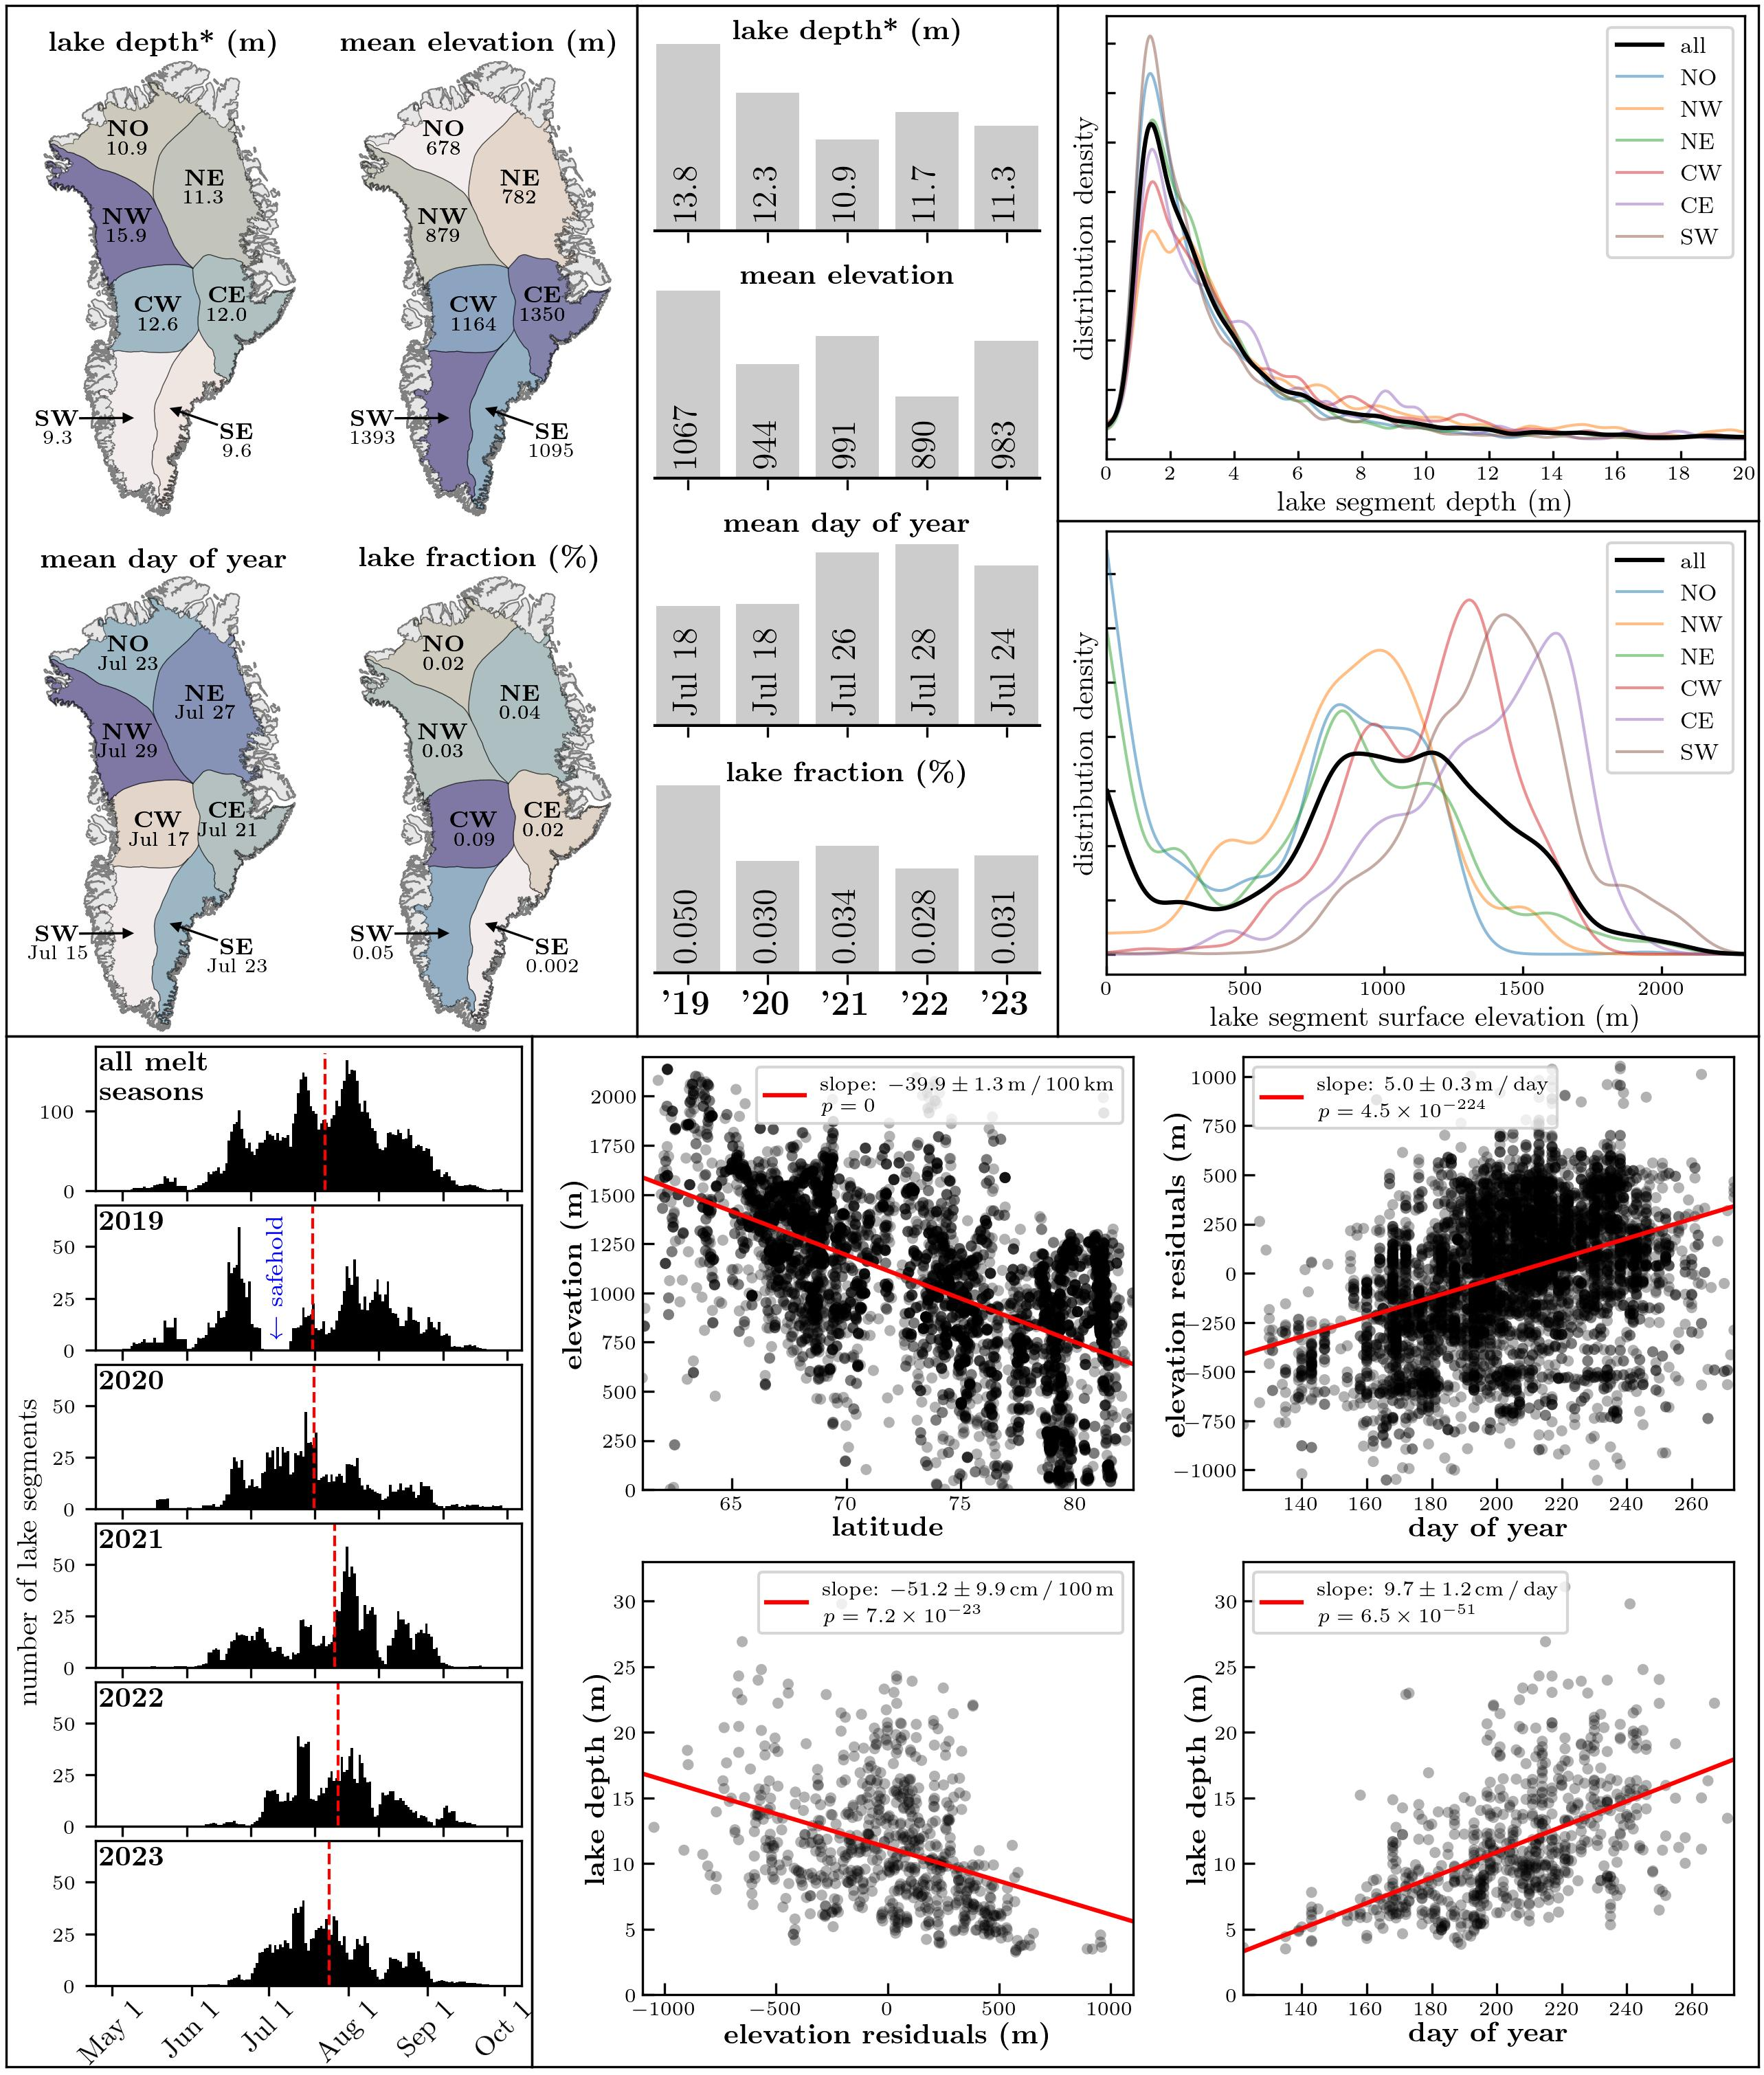

In [220]:
plt.close('all')
from matplotlib.ticker import MaxNLocator

plt.rcParams.update({
    'font.size': 7,
    'text.usetex': True,
    'font.family': 'Optima',
    'text.latex.preamble': r"\usepackage{amsmath}"
})

def ith_letter(i):
    return chr(97 + i)

plot_scatter = True
plot_timing = True
plot_elevs = True
plot_depths = True
plot_regions = True
plot_years = True

figwid = 8.5
fighgt = 10
fig = plt.figure(figsize=[figwid,fighgt], dpi=80)

tempsize = 16
templabels = ['scatter plots', 'timing\nhistograms', 'elev distributions', 'depth distributions', 'stats by region', 'stats\nby\nyear']

w_scatt = 0.7
h_scatt = 0.5
w_elev_dep = 0.4
frac_regions = 0.6

coords_scatters = [1-w_scatt, 0, w_scatt, h_scatt]
box_scatters = fig.add_axes(coords_scatters)
coords_timing = [0, 0, 1-w_scatt, h_scatt]
box_timing = fig.add_axes(coords_timing)
coords_elev = [1-w_elev_dep, h_scatt, w_elev_dep, (1-h_scatt)/2]
box_elev = fig.add_axes(coords_elev)
coords_depth = [1-w_elev_dep, h_scatt+(1-h_scatt)/2, w_elev_dep, (1-h_scatt)/2]
box_depth = fig.add_axes(coords_depth)
coords_regions = [0, h_scatt, (1-w_elev_dep)*frac_regions, 1-h_scatt]
box_regions = fig.add_axes(coords_regions)
coords_years = [(1-w_elev_dep)*frac_regions, h_scatt, (1-w_elev_dep)*(1-frac_regions), 1-h_scatt]
box_years = fig.add_axes(coords_years)

boxes = [box_scatters, box_timing, box_depth, box_elev, box_regions, box_years]

for ib, box in enumerate(boxes):
    box.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
    # box.text(0.5, 0.5, templabels[ib], ha='center', va='center', color='red', fontsize=tempsize, transform=box.transAxes, zorder=1000)
    box.set_facecolor('none')

###########################################################################################################
#### REGION STATS
###########################################################################################################
if plot_regions:
    box = box_regions
    axs_regions = []
    h = 0.45
    axs_regions.append(box.inset_axes([0, 0.5, 0.5, h]))
    axs_regions.append(box.inset_axes([0.5, 0.5, 0.5, h], sharex=axs_regions[0], sharey=axs_regions[0]))
    axs_regions.append(box.inset_axes([0, 0, 0.5, h], sharex=axs_regions[0], sharey=axs_regions[0]))
    axs_regions.append(box.inset_axes([0.5, 0, 0.5, h], sharex=axs_regions[0], sharey=axs_regions[0]))
    
    basins = gdf_basins.rename(columns={'SUBREGION1':'basin'}).merge(df_stats.rename(columns={'group':'basin'}), on='basin', how='left')
    
    region_locs = {
        'NO': {'x': -136000, 'y': -1130000},
        'NW': {'x': -139778.890, 'y': -1647117.016},
        'NE': {'x': 315495.132, 'y': -1419480.005},
        'CW': {'x': 47000, 'y': -2167000},
        'CE': {'x': 452077.339, 'y': -2109978.939},
        'SW': {'x': -550000, 'y': -2838417.374, 'x_arr': -101839.388, 'y_arr': -2770126.271},
        'SE': {'x': 506630.926, 'y': -2916540.146, 'x_arr': 106998.394, 'y_arr': -2711937.862}
    }
    
    def print_stat_map(x, stat, ax, name_sz=8, count_sz=7):
        region = x.basin
        thename = '\\textbf{%s}' % region
        thestat = x[stat]
        if region in region_locs.keys():
            locs = region_locs[region]
            xytext = [locs['x'], locs['y']]
            ax.annotate(text=thename, xy=xytext, ha='center',va='bottom',color='k',fontsize=name_sz, weight='bold')
            ax.annotate(text=thestat, xy=xytext, ha='center',va='top',color='k',fontsize=count_sz)
            if 'x_arr' in locs.keys():
                xyarr = [locs['x_arr'], locs['y_arr']]
                frac = 0.2
                xystart = np.array(xytext) + frac*(np.array(xyarr) - np.array(xytext)) 
                ax.annotate(' ', xy=xyarr, xytext=xystart,ha='center',va='center',color='k',fontsize=count_sz,
                             arrowprops=dict(width=0.8, headwidth=4, headlength=4, color='k', linewidth=0),zorder=1000)
            else:
                ax.annotate(text=thestat, xy=xytext, ha='center',va='top',color='k',fontsize=count_sz)
        else:
            ax.annotate(text=thename, xy=x.geometry.centroid.coords[0], ha='center',va='bottom', color='k',fontsize=name_sz, weight='bold')
            ax.annotate(text=thestat, xy=x.geometry.centroid.coords[0], ha='center',va='top', color='k',fontsize=count_sz)
    
    for ax in axs_regions:
        gre_coastline.plot(ax=ax, facecolor=[0.9]*3, edgecolor='gray', lw=0.5, zorder=-3)
        ax.axis('off')
        ax.set_xlim((-750000, 898000))
        ax.set_ylim((-3378000, -640000))
    
    cmap_regions = cmc.lapaz_r
    alpha = 0.5
    lw = 0.3
    tit_size = 10
    
    ax = axs_regions[0]
    smp = basins.plot(ax=ax, column='depth_90pctl', cmap=cmap_regions, edgecolor='k', linewidth=lw, alpha=alpha)
    basins.apply(print_stat_map, stat='depth_print', ax=ax, axis=1)
    ax.text(0.5, 1.0, '\\textbf{lake depth* (m)}', ha='center', va='bottom', transform=ax.transAxes, fontsize=tit_size)
    
    ax = axs_regions[1]
    smp = basins.plot(ax=ax, column='elev_mean', cmap=cmap_regions, edgecolor='k', linewidth=lw, alpha=alpha)
    basins.apply(print_stat_map, stat='elev_print', ax=ax, axis=1)
    ax.text(0.5, 1.0, '\\textbf{mean elevation (m)}', ha='center', va='bottom', transform=ax.transAxes, fontsize=tit_size)
    
    ax = axs_regions[2]
    smp = basins.plot(ax=ax, column='doy_mean', cmap=cmap_regions, edgecolor='k', linewidth=lw, alpha=alpha)
    basins.apply(print_stat_map, stat='doy_print', ax=ax, axis=1)
    ax.text(0.5, 1.0, '\\textbf{mean day of year}', ha='center', va='bottom', transform=ax.transAxes, fontsize=tit_size)
    
    ax = axs_regions[3]
    smp = basins.plot(ax=ax, column='pct_xatc_water', cmap=cmap_regions, edgecolor='k', linewidth=lw, alpha=alpha)
    basins.apply(print_stat_map, stat='percent_water_print', ax=ax, axis=1)
    ax.text(0.5, 1.0, '\\textbf{lake fraction (\\%)}', ha='center', va='bottom', transform=ax.transAxes, fontsize=tit_size)
    

###########################################################################################################
#### SCATTER PLOTS
###########################################################################################################
if plot_scatter:
    box = box_scatters
    l = 0.09
    b = 0.07
    r = 0.01
    t = 0.01
    w = (1 - (l+r)*2) / 2
    h = (1 - (b+t)*2) / 2
    axs_scatt = []
    axs_scatt.append(box.inset_axes([l, b*2+h, w, h]))
    axs_scatt.append(box.inset_axes([l*2+w, b*2+h, w, h]))
    axs_scatt.append(box.inset_axes([l, b, w, h]))
    axs_scatt.append(box.inset_axes([l*2+w, b, w, h]))
    
    group_size = 50
    min_elev = 0
    quantile = 0.9
    descr_fsz = 7
    km_per_lat = 111
    gdfnnz = gdfg[gdfg.max_depth > 0].copy()
    gdfnnz = gdfnnz[gdfnnz.is_grounded]
    
    # get linear model: elev vs lat
    elevation_lat_model = sm.OLS(gdfnnz['surface_elevation'], sm.add_constant(gdfnnz['lat'])).fit()
    gdfnnz['elevation_residuals'] = elevation_lat_model.resid
    km_per_lat = 111
    slope_elev = elevation_lat_model.params.lat / km_per_lat * 100 # m / 100 km
    ci = np.abs(elevation_lat_model.params.lat - elevation_lat_model.conf_int().iloc[1,0])
    ci_slope_elev = ci / km_per_lat * 100 # m / 100 km
    pval = ('%.2g' % elevation_lat_model.pvalues[1]).replace('e', '\\times 10^{')
    if '{' in pval:
        pval = pval + '}'
    elev_lat_label = 'slope: $%.1f \\pm %.1f \\mathrm{\\,m\\,/\\,100\\,km}$\n$p=%s$' % (slope_elev, ci_slope_elev, pval)
    
    # get linear model: depth vs elev (residuals, corrected for lat)
    df_sorted = gdfnnz.copy().sort_values(by='elevation_residuals').reset_index(drop=True)
    df_sorted['elev_group'] = get_ordered_groups(group_size=group_size, length=len(df_sorted))
    dfs = []
    for g in df_sorted.elev_group.unique():
        thisdf = df_sorted[df_sorted.elev_group == g]
        dfs.append(thisdf[thisdf.max_depth >= thisdf.max_depth.quantile(quantile)])
    dfdeep_res = pd.concat(dfs)
    depth_elev_res_model = sm.OLS(dfdeep_res['max_depth'], sm.add_constant(dfdeep_res['elevation_residuals'])).fit()
    slope_depth_elevres = depth_elev_res_model.params[1] * 10000 # cm / 100 m
    ci_depth_elevres = np.abs(depth_elev_res_model.params[1] - depth_elev_res_model.conf_int().iloc[1,0]) * 10000 # cm / 100 m
    pval = ('%.2g' % depth_elev_res_model.pvalues[1]).replace('e', '\\times 10^{')
    if '{' in pval:
        pval = pval + '}'
    depth_elevres_label = 'slope: $%.1f \\pm %.1f \\mathrm{\\,cm\\,/\\,100\\,m}$\n$p=%s$' % (slope_depth_elevres, ci_depth_elevres, pval)
    
    # get linear model: DOY vs elev (residuals, corrected for lat)
    doy_elev_res_model = sm.OLS(gdfnnz['elevation_residuals'], sm.add_constant(gdfnnz['doy'])).fit()
    slope_doy_elev = doy_elev_res_model.params[1] # m / day
    ci_doy_elev = np.abs(doy_elev_res_model.params[1] - doy_elev_res_model.conf_int().iloc[1,0]) # m / day
    pval = ('%.2g' % doy_elev_res_model.pvalues[1]).replace('e', '\\times 10^{')
    if '{' in pval:
        pval = pval + '}'
    doy_elev_label = 'slope: $%.1f \\pm %.1f \\mathrm{\\,m\\,/\\,day}$\n$p=%s$' % (slope_doy_elev, ci_doy_elev, pval)
    
    # get linear model: depth vs DOY 
    df_sorted = gdfnnz.copy().sort_values(by='doy').reset_index(drop=True)
    df_sorted['doy_group'] = get_ordered_groups(group_size=group_size, length=len(df_sorted))
    dfs = []
    for g in df_sorted.doy_group.unique():
        thisdf = df_sorted[df_sorted.doy_group == g]
        dfs.append(thisdf[thisdf.max_depth >= thisdf.max_depth.quantile(quantile)])
    dfdeep_doy = pd.concat(dfs)
    doy_depth_model = sm.OLS(dfdeep_doy['max_depth'], sm.add_constant(dfdeep_doy['doy'])).fit()
    slope_doy_depth = doy_depth_model.params[1] * 100 # cm / day
    ci_doy_depth = np.abs(doy_depth_model.params[1] - doy_depth_model.conf_int().iloc[1,0]) * 100 # cm / day
    pval = ('%.2g' % doy_depth_model.pvalues[1]).replace('e', '\\times 10^{')
    if '{' in pval:
        pval = pval + '}'
    doy_depth_label = 'slope: $%.1f \\pm %.1f \\mathrm{\\,cm\\,/\\,day}$\n$p=%s$' % (slope_doy_depth, ci_doy_depth, pval)
    
    # define limits
    lim_elev = (0,2200)
    lim_depth = (0, 33)
    lim_resid = (-1100, 1100)
    lim_lat = (gdfnnz.lat.min(), gdfnnz.lat.max())
    lim_doy = (gdfnnz.doy.min(), gdfnnz.doy.max())
    
    # get linear fit predictions from the models
    pred_lats = np.linspace(lim_lat[0], lim_lat[1])
    pred_resid = np.linspace(lim_resid[0], lim_resid[1])
    pred_doy = np.linspace(lim_doy[0], lim_doy[1])
    elevs_predicted = elevation_lat_model.predict(sm.add_constant(pred_lats))
    resid_predicted_doy = doy_elev_res_model.predict(sm.add_constant(pred_doy_elev))
    depths_predicted_resid = depth_elev_res_model.predict(sm.add_constant(pred_resid))
    depth_predicted_doy = doy_depth_model.predict(sm.add_constant(pred_doy))
    
    txt_bbx = dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle="Round, pad=0.3")
    xlab_pad = 1
    ylab_pad = 1
    lab_size = 10
    dot_size = 15
    dot_alpha = 0.3
    
    ###############
    # scatter elev vs. lat
    ax = axs_scatt[0]
    cmap_depth = cmc.lapaz_r
    cmap_lat = cmc.acton
    scatt = ax.scatter(dfsort.lat, dfsort.surface_elevation, s=dot_size, color='k', alpha=dot_alpha, edgecolors='none')
    ax.plot(pred_lats, elevs_predicted, 'r-', label=elev_lat_label)
    ax.set_xlabel('\\textbf{latitude}', fontsize=lab_size, labelpad=xlab_pad)
    ax.set_xlim(lim_lat)
    ax.set_ylabel('\\textbf{elevation (m)}', fontsize=lab_size, labelpad=ylab_pad)
    ax.set_ylim(lim_elev)
    ax.legend(loc='upper right')
    
    ###############
    # scatter depth vs. elev
    ax = axs_scatt[2]
    scatt = ax.scatter(dfdeep_res.elevation_residuals, dfdeep_res.max_depth, s=dot_size, color='k', alpha=dot_alpha, edgecolors='none')
    ax.plot(pred_resid, depths_predicted_resid, 'r-', label=depth_elevres_label)
    ax.set_xlabel('\\textbf{elevation residuals (m)}', fontsize=lab_size, labelpad=xlab_pad)
    ax.set_xlim(lim_resid)
    ax.set_ylabel('\\textbf{lake depth (m)}', fontsize=lab_size, labelpad=ylab_pad)
    ax.set_ylim(lim_depth)
    ax.legend(loc='upper right')
    
    ###############
    # scatter depth vs. elev
    ax = axs_scatt[1]
    ax.scatter(gdfnnz.doy, gdfnnz.elevation_residuals, s=dot_size, edgecolors='none', alpha=dot_alpha, color='k')
    ax.plot(pred_doy_elev, resid_predicted_doy, 'r-', label=doy_elev_label)
    ax.set_xlabel('\\textbf{day of year}', fontsize=lab_size, labelpad=xlab_pad)
    ax.set_xlim(lim_doy)
    ax.set_ylabel('\\textbf{elevation residuals (m)}', fontsize=lab_size, labelpad=ylab_pad-7)
    ax.set_ylim(lim_resid)
    ax.legend(loc='upper left')
    
    ###############
    # scatter depth vs. elev
    ax = axs_scatt[3]
    ax.scatter(dfdeep_doy.doy, dfdeep_doy.max_depth, s=dot_size, edgecolors='none', alpha=dot_alpha, color='k')
    ax.plot(pred_doy, depth_predicted_doy, 'r-', label=doy_depth_label)
    ax.set_xlabel('\\textbf{day of year}', fontsize=lab_size, labelpad=xlab_pad)
    ax.set_xlim(lim_doy)
    ax.set_ylabel('\\textbf{lake depth (m)}', fontsize=lab_size, labelpad=ylab_pad)
    ax.set_ylim(lim_depth)
    ax.legend(loc='upper left')
    
    for ax in axs_scatt:
        ax.tick_params(axis='both', direction='in', length=4, pad=2)
        ax.set_facecolor('none')

###########################################################################################################
#### YEAR/SEASON STATS
###########################################################################################################
if plot_years:
    box = box_years
    yrs = df_stats.set_index('group').loc[['2019', '2020', '2021', '2022', '2023']].copy()
    xs = np.arange(2019, 2024)
    
    b = 0.02
    bb = 0.04
    ny = 4
    h = (1-b*ny-bb)/ny
    fc = [0.8]*3
    # fc=cmc.grayC(np.linspace(0.15, 0.35, 5))
    tit_size = 10
    txt_y = 0.95
    yf = 0.05
    labsz = 12
    
    axs_years = []
    for i in range(ny):
        axs_years.append(box.inset_axes([0, 1-(i+1)*h-i*b, 1, h]))
    
    ax = axs_years[0]
    yl = (8,15)
    yrng = yl[1]-yl[0]
    bars = ax.bar(xs, yrs.depth_90pctl, color=fc)
    [ax.text(bar.get_x()+bar.get_width()/2, yl[0]+yf*yrng, yrs.depth_print.iloc[ib],ha='center',va='bottom',
             rotation='vertical', fontsize=labsz) for ib,bar in enumerate(bars)]
    ax.set_ylim(yl)
    ax.text(0.5, txt_y, '\\textbf{lake depth* (m)}', ha='center', va='top', transform=ax.transAxes, fontsize=tit_size)
    
    ax = axs_years[1]
    yl = (750,1130)
    yrng = yl[1]-yl[0]
    bars = ax.bar(xs, yrs.elev_mean, color=fc)
    [ax.text(bar.get_x()+bar.get_width()/2, yl[0]+yf*yrng, yrs.elev_print.iloc[ib],ha='center',va='bottom',
             rotation='vertical', fontsize=labsz) for ib,bar in enumerate(bars)]
    ax.set_ylim(yl)
    ax.text(0.5, txt_y, '\\textbf{mean elevation}', ha='center', va='top', transform=ax.transAxes, fontsize=tit_size)
    
    ax = axs_years[2]
    yl = (180,216)
    yrng = yl[1]-yl[0]
    bars = ax.bar(xs, yrs.doy_mean, color=fc)
    [ax.text(bar.get_x()+bar.get_width()/2, yl[0]+yf*yrng, yrs.doy_print.iloc[ib],ha='center',va='bottom',
             rotation='vertical', fontsize=labsz) for ib,bar in enumerate(bars)]
    ax.set_ylim(yl)
    ax.text(0.5, txt_y, '\\textbf{mean day of year}', ha='center', va='top', transform=ax.transAxes, fontsize=tit_size)
    
    ax = axs_years[3]
    yl = (0,0.06)
    yrng = yl[1]-yl[0]
    bars = ax.bar(xs, yrs.pct_xatc_water, color=fc)
    yrs['percent_water_print'] = yrs.pct_xatc_water.apply(lambda x: '$%.3f$' % x)
    [ax.text(bar.get_x()+bar.get_width()/2, yl[0]+yf*yrng, yrs.percent_water_print.iloc[ib],ha='center',va='bottom',
             rotation='vertical', fontsize=labsz) for ib,bar in enumerate(bars)]
    ax.set_ylim(yl)
    ax.text(0.5, txt_y, '\\textbf{lake fraction (\\%)}', ha='center', va='top', transform=ax.transAxes, fontsize=tit_size)
    ax.set_xticks(np.arange(2019,2024), ["\\textbf{'%d}" % x for x in np.arange(19,24)],fontsize=12, rotation=0)
    ax.tick_params(axis='x', pad=2)
    
    for iax, ax in enumerate(axs_years):
        ax.set_facecolor('none')
        ax.plot([2018.6, 2023.4], [ax.get_ylim()[0]]*2, 'k-', lw=2, zorder=100)
        for spine in ax.spines.values():
            spine.set_visible(False)
        labelbottom = True if iax == (ny - 1) else False
        ax.tick_params(left=False,labelbottom=labelbottom,labelleft=False)

###########################################################################################################
#### SEASON TIMING
###########################################################################################################
if plot_timing:
    box = box_timing
    box.text(0.02, 0.5, 'number of lake segments', fontsize=10, rotation=90, ha='center', va='top', transform=box.transAxes, rotation_mode='anchor')
    ny = 6
    b = 0.014
    bb = 0.065
    t = 0.01
    l = 0.17
    r = 0.02
    h = (1-b*ny-bb-t)/ny
    axs_timing = []
    for i in range(ny):
        axs_timing.append(box.inset_axes([l, 1-(i+1)*h-i*b-t, 1-l-r, h]))
    for ax in axs_timing[:-1]:
        ax.tick_params(axis='both', which='both', labelbottom=False)

    year_list = np.arange(2019,2024)
    dt_list = [datetime(2019,i,1) for i in np.arange(5,11)]
    doy_list = [x.timetuple().tm_yday for x in dt_list]
    ylab_list = [x.strftime('%b %-d') for x in dt_list]
    
    bins = np.arange(gdfg.doy.min()-0.5, gdfg.doy.max()+0.5)
    mids = bins[:-1] + np.diff(bins)
    
    ax = axs_timing[0]
    hist = np.histogram(gdfg.doy, bins)
    hist_smooth = pd.Series(hist[0]).rolling(window=5, center=True, min_periods=1).mean()
    ax.bar(mids, hist_smooth, width=1.0, color='k')
    daymean = gdfg.doy.mean()
    daymean_str = (datetime(2019, 1, 1) + timedelta(days=daymean)).strftime("%b %d")
    yl = ax.get_ylim()
    ax.plot([daymean]*2, yl, color='r', lw=1, ls='--')
    ax.text(0.01, 0.97, '\\textbf{all melt}\n\\textbf{seasons}', ha='left', va='top', transform=ax.transAxes, fontsize=10)
    
    for iyr, yr in enumerate(year_list):
        ax = axs_timing[iyr+1]
        gdfgyr = gdfg[gdfg.melt_season == yr].copy()
        hist = np.histogram(gdfgyr.doy, bins)
        hist_smooth = pd.Series(hist[0]).rolling(window=5, center=True, min_periods=1).mean()
        ax.bar(mids, hist_smooth, width=1.0, color='k')
        daymean = gdfgyr.doy.mean()
        daymean_str = (datetime(2019, 1, 1) + timedelta(days=daymean)).strftime("%b %d")
        yl = (0,70)
        ax.set_ylim(yl)
        ax.plot([daymean]*2, yl, color='r', lw=1, ls='--')
        ax.text(0.01, 0.97, '\\textbf{%i}' % yr, ha='left', va='top', transform=ax.transAxes, fontsize=10)

    ax.set_xticks(doy_list, labels=ylab_list ,fontsize=10, rotation=45)
    ax.tick_params(axis='x', pad=0)
    safehold_date = datetime(2019, 7, 4)
    safehold_doy = safehold_date.timetuple().tm_yday
    axs_timing[1].text(safehold_doy, 5, '← safehold', ha='center', va='bottom', rotation='vertical', color='blue', fontsize=8.5)

###########################################################################################################
#### DEPTH DISTRIBUTION
###########################################################################################################
if plot_depths:
    box = box_depth
    l = 0.07
    r = 0.02
    t = 0.02
    b = 0.12
    ax = box.inset_axes([l, b, 1-l-r, 1-b-t])

    basin_list = ['NO', 'NW', 'NE', 'CW', 'CE', 'SW'] # , 'SE'
    year_list = np.arange(2019,2024)

    maxdepth = 35
    step_hist = 0.01
    smooth_len = 0.3
    xl = [0, 20]
    gdfnnz = gdfg[gdfg.max_depth > 0].copy()
    bins = np.arange(0,maxdepth+step_hist, step_hist)
    mids = bins[:-1] + np.diff(bins)
    hist = np.histogram(gdfnnz.max_depth, bins=bins, density=True)
    wdw = int(np.ceil(smooth_len/step_hist))
    hist_smooth = pd.Series(hist[0]).rolling(window=wdw*10, min_periods=1, center=True, win_type='gaussian').mean(std=wdw)
    ax.plot(mids, hist_smooth, 'k-', zorder=10, label='all')
    for ib, bas in enumerate(basin_list):
        dfb = gdfnnz[gdfnnz.basin==bas].copy()
        hist_bs = np.histogram(dfb.max_depth, bins=bins, density=True)
        hist_bs_smooth = pd.Series(hist_bs[0]).rolling(window=wdw*10, min_periods=1, center=True, win_type='gaussian').mean(std=wdw)
        ax.plot(mids, hist_bs_smooth, alpha=0.5, lw=1, label=bas)
    ax.legend(loc='upper right', fontsize=8)
    ax.set_xlim(xl)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel('lake segment depth (m)', fontsize=10, labelpad=2)
    ax.set_ylabel('distribution density', fontsize=10, labelpad=3)
    ax.tick_params(axis='both', direction='in', length=3, pad=2)
    ax.set_facecolor('none')
    ax.tick_params(labelleft=False)

###########################################################################################################
#### DEPTH DISTRIBUTION
###########################################################################################################
if plot_elevs:
    box = box_elev
    l = 0.07
    r = 0.02
    t = 0.02
    b = 0.12
    ax = box.inset_axes([l, b, 1-l-r, 1-b-t])

    maxelev = 2300
    step_hist = 2
    smooth_len = 70
    xl = [0, 2300]
    gdfnnz = gdfg[gdfg.max_depth > 0].copy()
    bins = np.arange(0,maxelev+step_hist, step_hist)
    mids = bins[:-1] + np.diff(bins)
    hist = np.histogram(gdfg.surface_elevation, bins=bins, density=True)
    wdw = int(np.ceil(smooth_len/step_hist))
    hist_smooth = pd.Series(hist[0]).rolling(window=wdw*10, min_periods=1, center=True, win_type='gaussian').mean(std=wdw)
    
    ax.plot(mids, hist_smooth, 'k-', zorder=10, label='all')
    for bas in basin_list:
        dfb = gdfg[gdfg.basin==bas].copy()
        hist_bs = np.histogram(dfb.surface_elevation, bins=bins, density=True)
        hist_bs_smooth = pd.Series(hist_bs[0]).rolling(window=wdw*10, min_periods=1, center=True, win_type='gaussian').mean(std=wdw)
        ax.plot(mids, hist_bs_smooth, alpha=0.5, lw=1, label=bas)
    
    ax.legend(loc='upper right', fontsize=8)
    ax.set_xlim(xl)
    ax.set_xlabel('lake segment surface elevation (m)', fontsize=10, labelpad=2)
    ax.set_ylabel('distribution density', fontsize=10, labelpad=3)
    ax.tick_params(axis='both', direction='in', length=3, pad=2)
    ax.set_facecolor('none')
    ax.tick_params(labelleft=False)

figfn = 'figures/fig02_icesat2-data-stats.jpg'
for savefn in [figfn, figfn.replace('.jpg', '.pdf')]:
    fig.savefig(savefn, dpi=300, bbox_inches='tight', pad_inches=0.03)
fig.savefig(figfn.replace('.jpg','_lowres.jpg'), dpi=60, bbox_inches='tight', pad_inches=0.03)
plt.close(fig)
display(Image(figfn))

# Stats grouped by basin

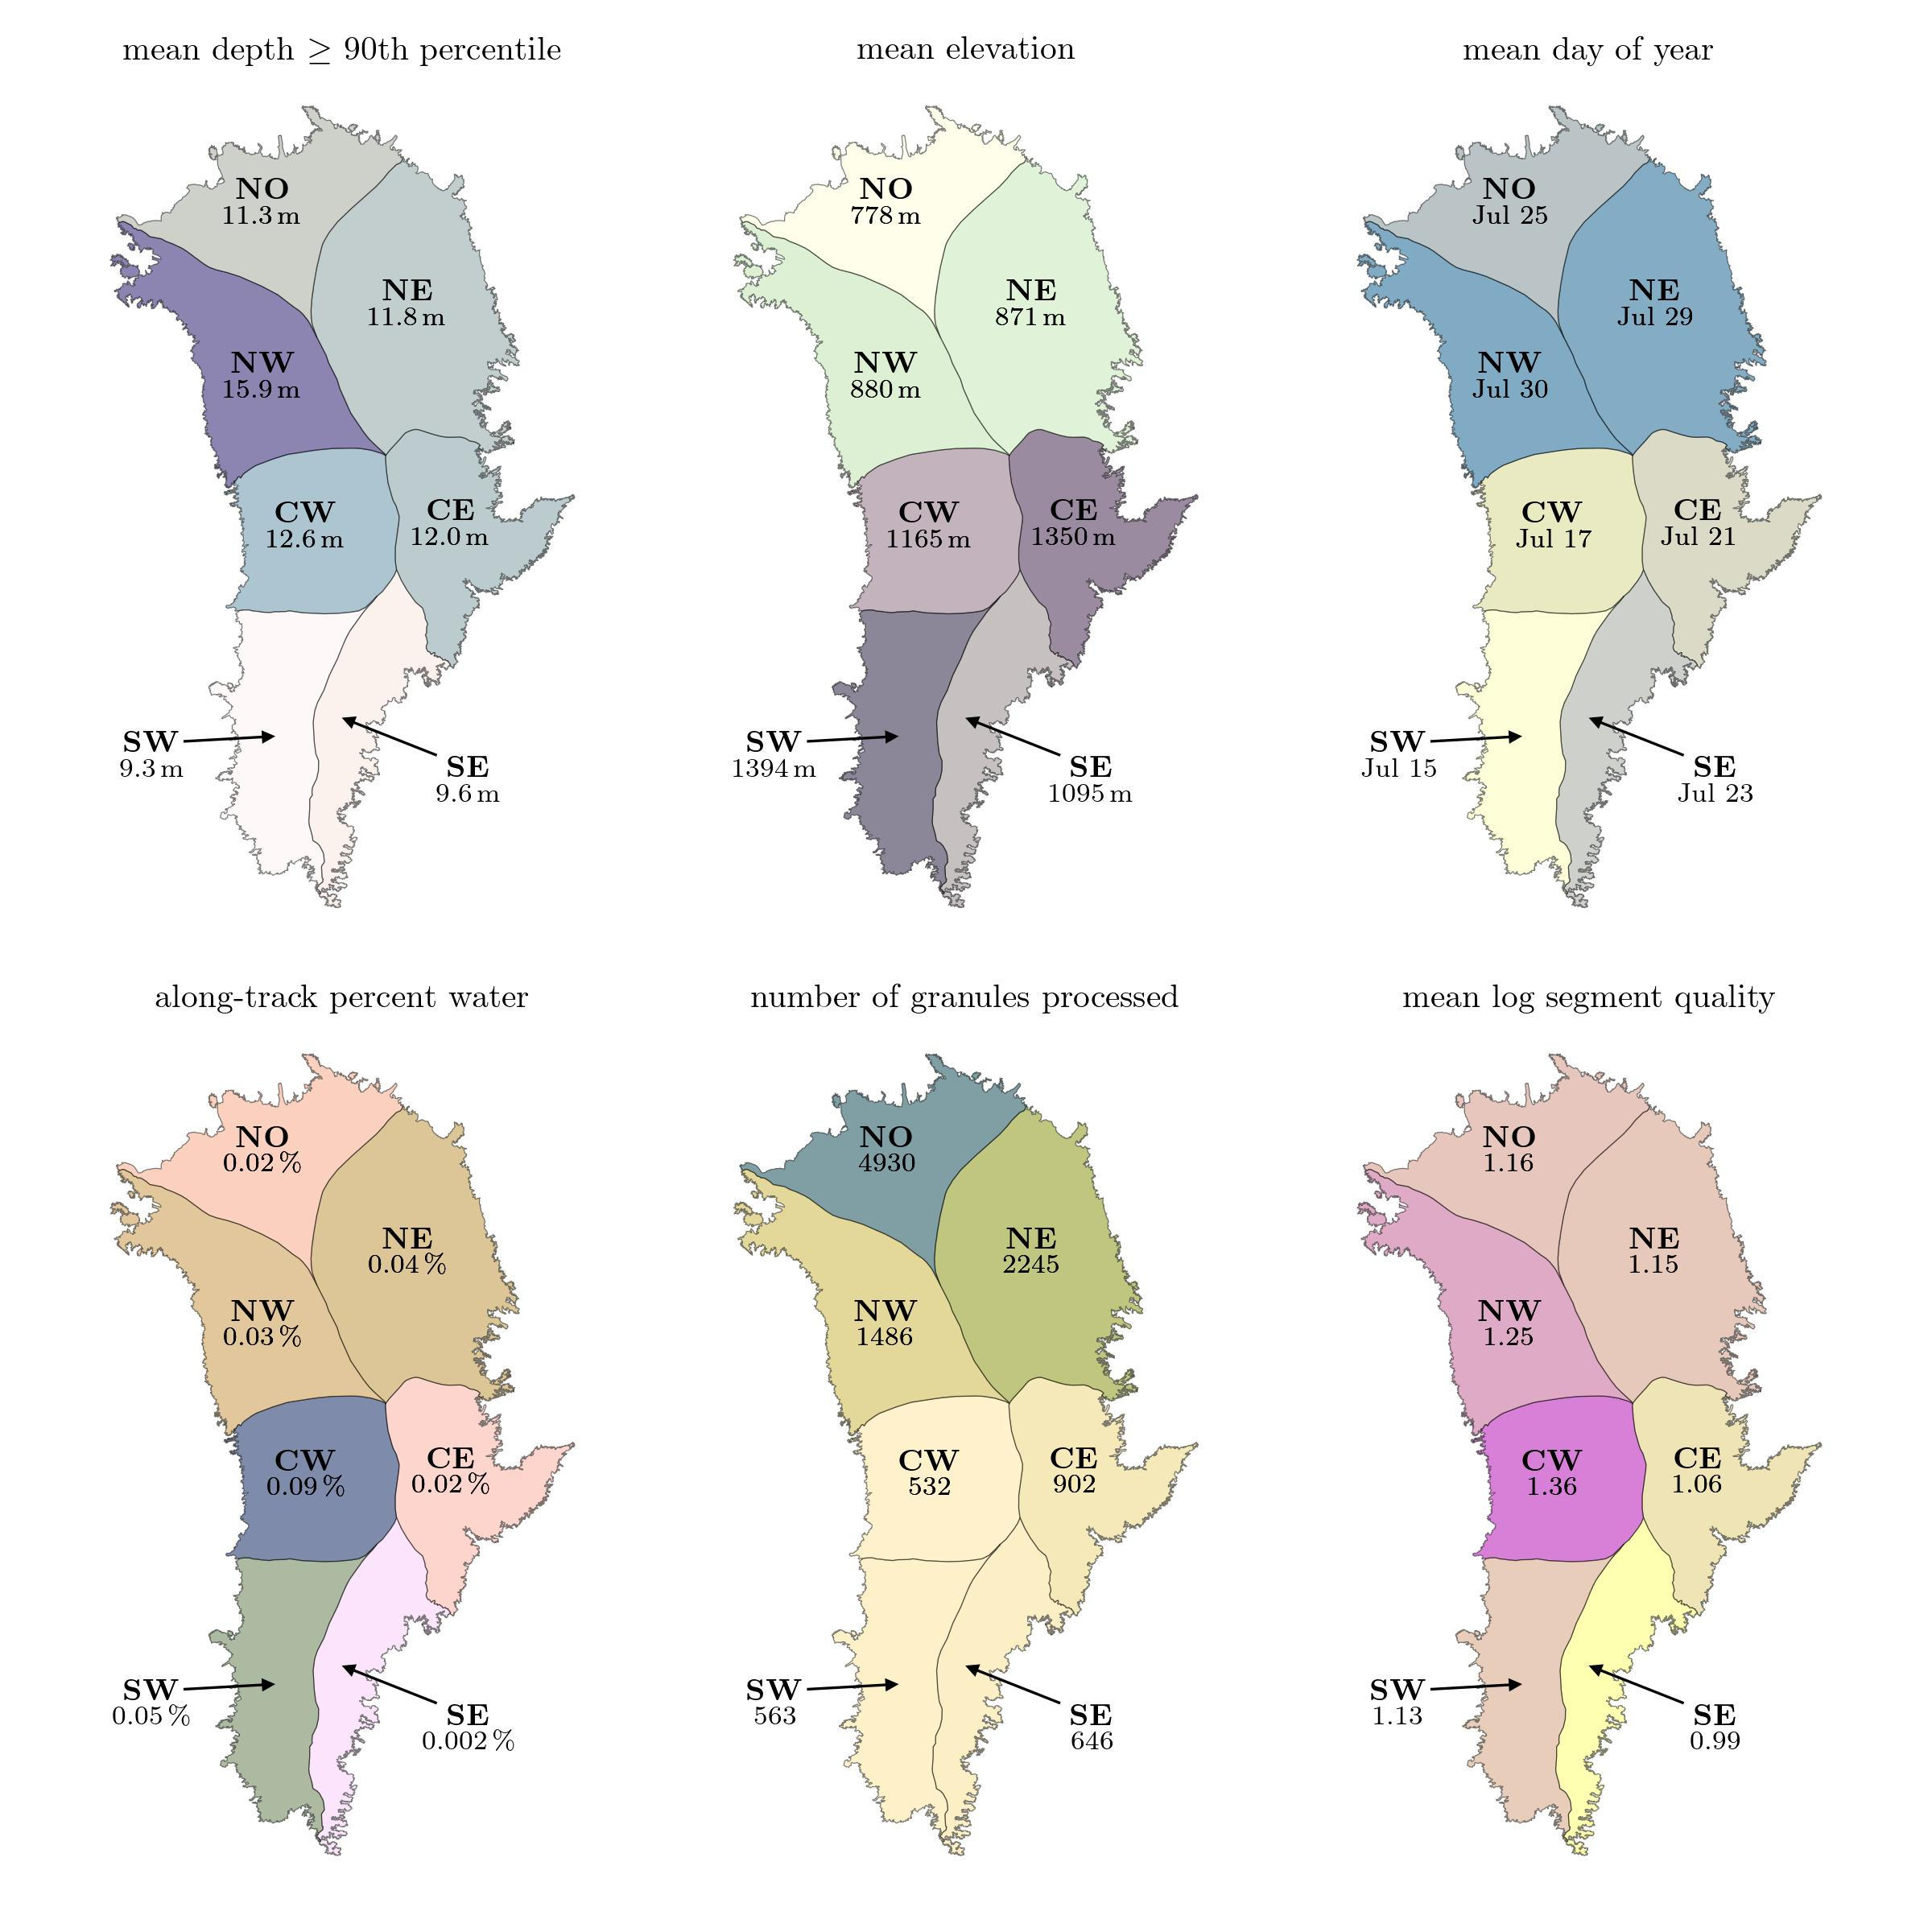

In [3]:
plt.close('all')
basins = gdf_basins.rename(columns={'SUBREGION1':'basin'}).merge(df_stats.rename(columns={'group':'basin'}), on='basin', how='left')

region_locs = {
    'NO': {'x': -139778.890, 'y': -1100788.189},
    'NW': {'x': -139778.890, 'y': -1647117.016},
    'NE': {'x': 315495.132, 'y': -1419480.005},
    'CW': {'x': -3196.683, 'y': -2117566.839},
    'CE': {'x': 452077.339, 'y': -2109978.939},
    'SW': {'x': -488822.307, 'y': -2838417.374, 'x_arr': -101839.388, 'y_arr': -2770126.271},
    'SE': {'x': 506630.926, 'y': -2916540.146, 'x_arr': 106998.394, 'y_arr': -2711937.862}
}

def print_stat_map(x, stat, ax, name_sz=9, count_sz=8):
    region = x.basin
    thename = '\\textbf{%s}' % region
    thestat = x[stat]
    if region in region_locs.keys():
        locs = region_locs[region]
        xytext = [locs['x'], locs['y']]
        ax.annotate(text=thename, xy=xytext, ha='center',va='bottom',color='k',fontsize=name_sz, weight='bold')
        ax.annotate(text=thestat, xy=xytext, ha='center',va='top',color='k',fontsize=count_sz)
        if 'x_arr' in locs.keys():
            xyarr = [locs['x_arr'], locs['y_arr']]
            frac = 0.2
            xystart = np.array(xytext) + frac*(np.array(xyarr) - np.array(xytext)) 
            ax.annotate(' ', xy=xyarr, xytext=xystart,ha='center',va='center',color='k',fontsize=count_sz,
                         arrowprops=dict(width=0.8, headwidth=4, headlength=4, color='k', linewidth=0),zorder=1000)
        else:
            ax.annotate(text=thestat, xy=xytext, ha='center',va='top',color='k',fontsize=count_sz)
    else:
        ax.annotate(text=thename, xy=x.geometry.centroid.coords[0], ha='center',va='bottom',
                                           color='k',fontsize=name_sz, weight='bold')
        ax.annotate(text=thestat, xy=x.geometry.centroid.coords[0], ha='center',va='top',
                                           color='k',fontsize=count_sz)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima",
    'font.size': 10,
})

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=[8,8], sharex=True, sharey=True)
axs = axs.flatten()
for ax in axs:
    ax.axis('off')

ax = axs[0]
smp = basins.plot(ax=ax, column='depth_90pctl', cmap=cmc.lapaz_r, edgecolor='k', linewidth=0.3, alpha=0.5)
basins.apply(print_stat_map, stat='depth_print', ax=ax, axis=1)
ax.text(0.5, 1.0, 'mean depth $\\geq$ 90th percentile', ha='center', va='bottom', transform=ax.transAxes)

ax = axs[1]
smp = basins.plot(ax=ax, column='elev_mean', cmap=cmc.tokyo_r, edgecolor='k', linewidth=0.3, alpha=0.5)
basins.apply(print_stat_map, stat='elev_print', ax=ax, axis=1)
ax.text(0.5, 1.0, 'mean elevation', ha='center', va='bottom', transform=ax.transAxes)

ax = axs[2]
smp = basins.plot(ax=ax, column='doy_mean', cmap=cmc.nuuk_r, edgecolor='k', linewidth=0.3, alpha=0.5)
basins.apply(print_stat_map, stat='doy_print', ax=ax, axis=1)
ax.text(0.5, 1.0, 'mean day of year', ha='center', va='bottom', transform=ax.transAxes)

ax = axs[3]
smp = basins.plot(ax=ax, column='pct_xatc_water', cmap=cmc.batlow_r, edgecolor='k', linewidth=0.3, alpha=0.5)
basins.apply(print_stat_map, stat='percent_water_print', ax=ax, axis=1)
ax.text(0.5, 1.0, 'along-track percent water', ha='center', va='bottom', transform=ax.transAxes)

ax = axs[4]
smp = basins.plot(ax=ax, column='n_granules', cmap=cmc.bamako_r, edgecolor='k', linewidth=0.3, alpha=0.5)
basins.apply(print_stat_map, stat='ngranules_print', ax=ax, axis=1)
ax.text(0.5, 1.0, 'number of granules processed', ha='center', va='bottom', transform=ax.transAxes)

ax = axs[5]
smp = basins.plot(ax=ax, column='log_qual_mean', cmap=cmc.buda_r, edgecolor='k', linewidth=0.3, alpha=0.5)
basins.apply(print_stat_map, stat='qual_print', ax=ax, axis=1)
ax.text(0.5, 1.0, 'mean log segment quality', ha='center', va='bottom', transform=ax.transAxes)

fig.tight_layout()
figname = 'figures/others/stats_by_basin.jpg'
fig.savefig(figname, dpi=300)
plt.close(fig)
display(Image(figname))

# to get coordinates from clicks
# coords = []
# def onclick(event):
#     global ix, iy
#     ix, iy = event.xdata, event.ydata
#     print("'x': %.3f, 'y': %.3f" % (ix,iy))
#     global coords
#     coords.append((ix,iy))
#     if len(coords) > 100:
#         fig.canvas.mpl_disconnect(cid)
#     return coords
# cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Stats grouped by year

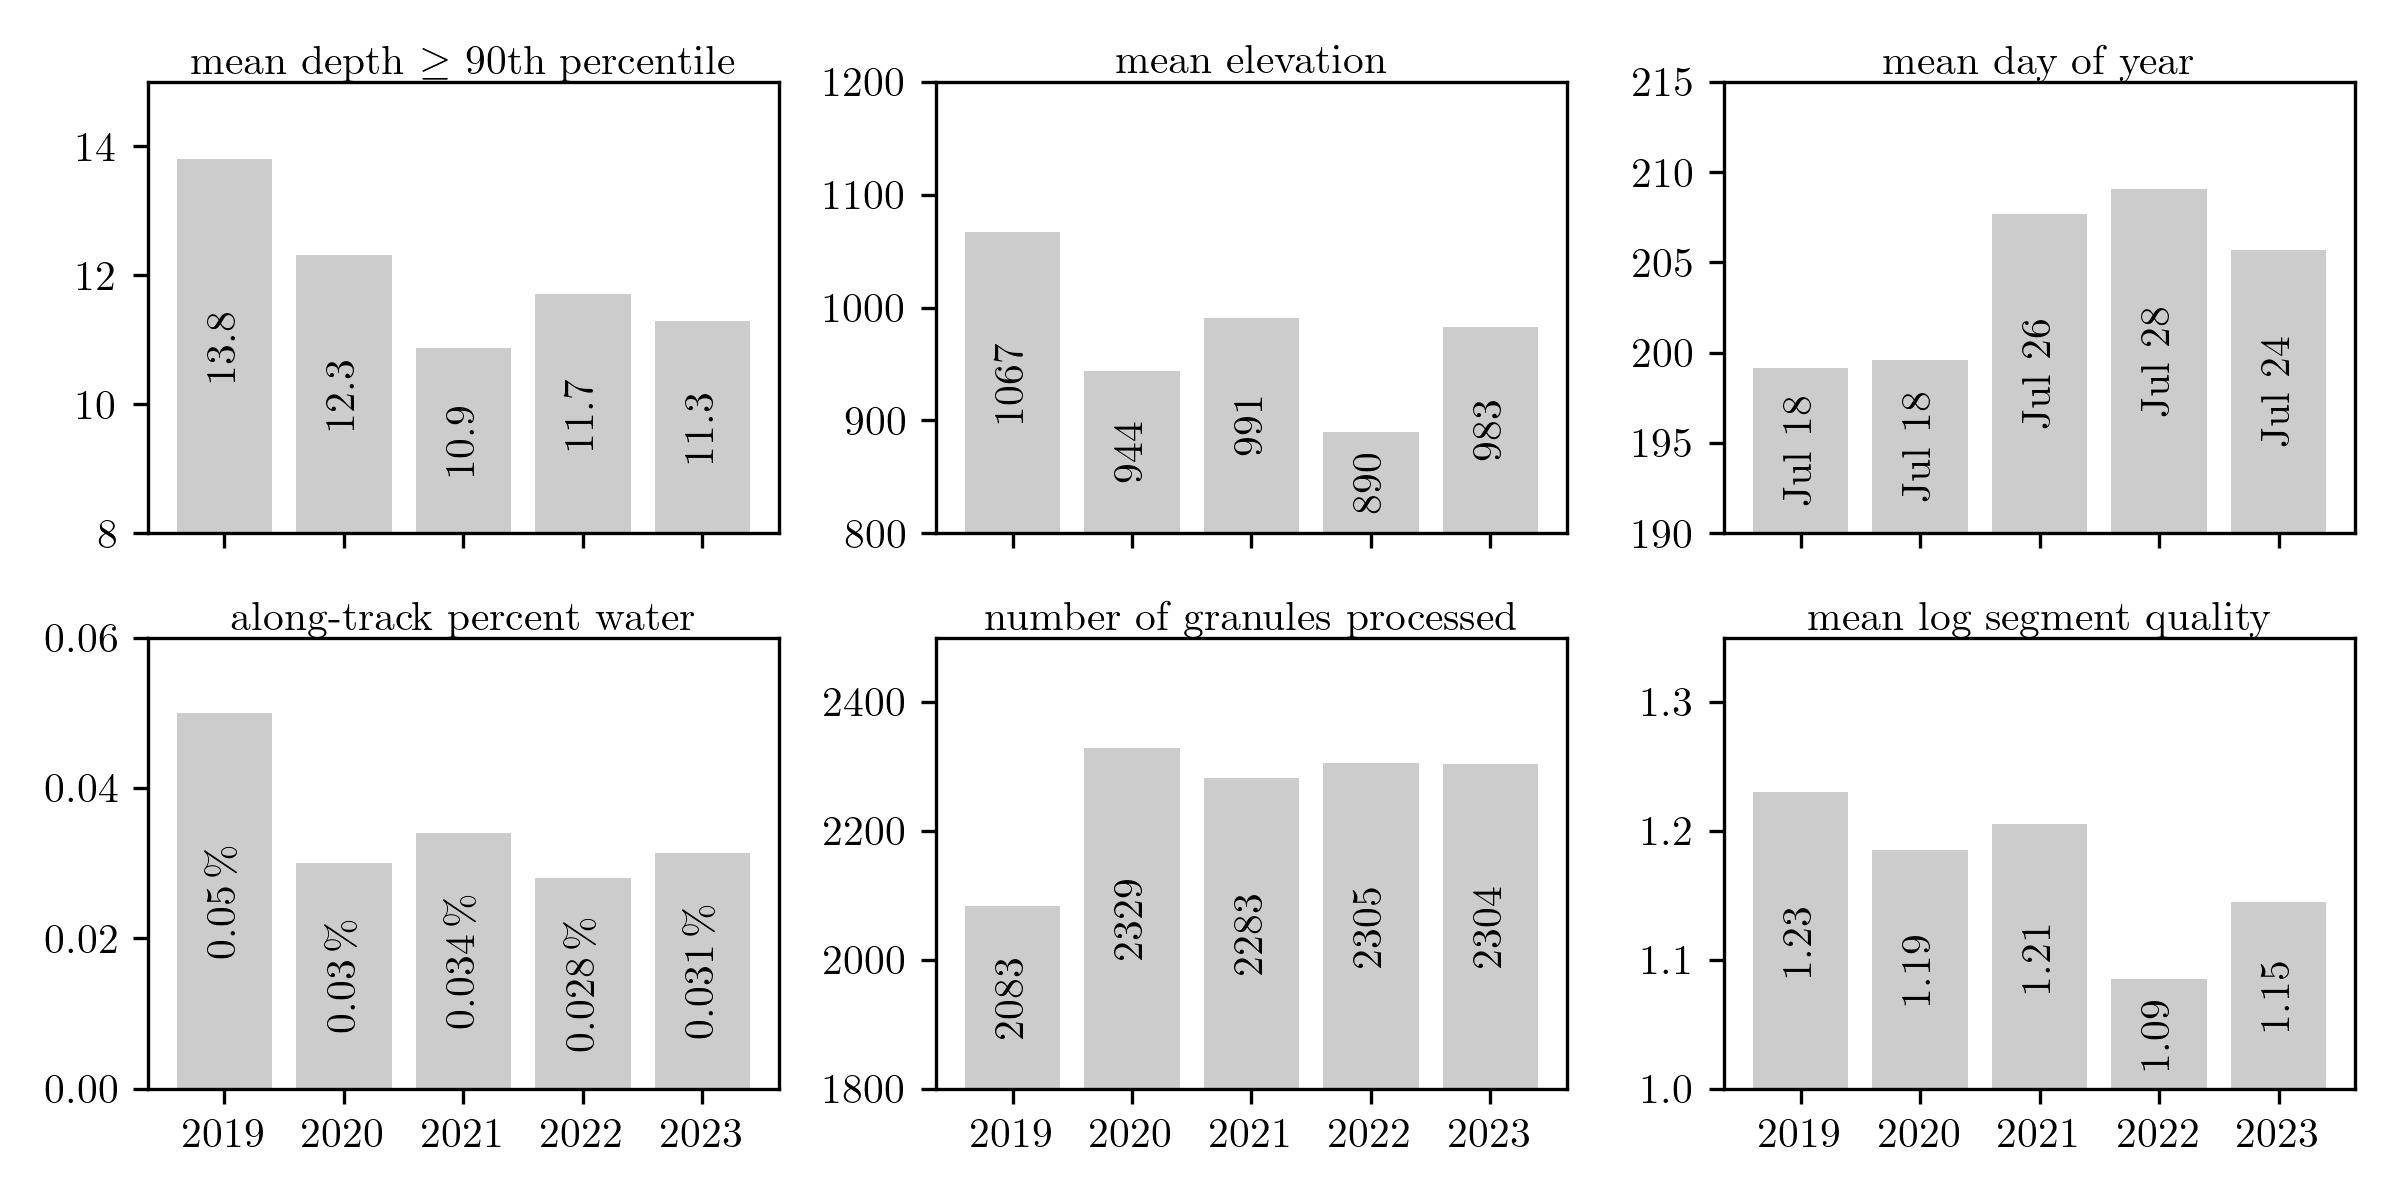

In [108]:
plt.close('all')
# df_stats = pd.read_csv('data/FLUID-SuRRF_GrIS2019-23_groupstats_grounded.csv')
yrs = df_stats.set_index('group').loc[['2019', '2020', '2021', '2022', '2023']].copy()

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima",
    'font.size': 10,
})

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=[8,4], sharex=True)
axs = axs.flatten()

fc = [0.8]*3

ax = axs[0]
yl = (8,15)
bars = ax.bar(yrs.depth_90pctl.index, yrs.depth_90pctl, color=fc)
[ax.text(bar.get_x()+bar.get_width()/2,(bar.get_height()+yl[0])/2,yrs.depth_print.iloc[ib],ha='center',va='center',rotation='vertical') for ib,bar in enumerate(bars)]
ax.set_ylim(yl)
ax.text(0.5, 1.0, 'mean depth $\\geq$ 90th percentile', ha='center', va='bottom', transform=ax.transAxes)

ax = axs[1]
yl = (800,1200)
bars = ax.bar(yrs.elev_mean.index, yrs.elev_mean, color=fc)
[ax.text(bar.get_x()+bar.get_width()/2,(bar.get_height()+yl[0])/2,yrs.elev_print.iloc[ib],ha='center',va='center',rotation='vertical') for ib,bar in enumerate(bars)]
ax.set_ylim(yl)
ax.text(0.5, 1.0, 'mean elevation', ha='center', va='bottom', transform=ax.transAxes)

ax = axs[2]
yl = (190,215)
bars = ax.bar(yrs.doy_mean.index, yrs.doy_mean, color=fc)
# [ax.text(bar.get_x()+bar.get_width()/2,bar.get_height(),yrs.doy_print.iloc[ib],ha='center',va='bottom') for ib,bar in enumerate(bars)]
[ax.text(bar.get_x()+bar.get_width()/2,(bar.get_height()+yl[0])/2,yrs.doy_print.iloc[ib],ha='center',va='center',rotation='vertical') for ib,bar in enumerate(bars)]
ax.set_ylim(yl)
ax.text(0.5, 1.0, 'mean day of year', ha='center', va='bottom', transform=ax.transAxes)

ax = axs[3]
yl = (0,0.06)
bars = ax.bar(yrs.pct_xatc_water.index, yrs.pct_xatc_water, color=fc)
yrs['percent_water_print'] = yrs.pct_xatc_water.apply(lambda x: '$%.2g\\mathrm{\\,\\%%}$' % x)
[ax.text(bar.get_x()+bar.get_width()/2,(bar.get_height()+yl[0])/2,yrs.percent_water_print.iloc[ib],ha='center',va='center',rotation='vertical') for ib,bar in enumerate(bars)]
# [ax.text(bar.get_x()+bar.get_width()/2,bar.get_height(),yrs.percent_water_print.iloc[ib],ha='center',va='bottom') for ib,bar in enumerate(bars)]
ax.set_ylim(yl)
ax.text(0.5, 1.0, 'along-track percent water', ha='center', va='bottom', transform=ax.transAxes)

ax = axs[4]
yl = (1800,2500)
bars = ax.bar(yrs.n_granules.index, yrs.n_granules, color=fc)
[ax.text(bar.get_x()+bar.get_width()/2,(bar.get_height()+yl[0])/2,yrs.ngranules_print.iloc[ib],ha='center',va='center',rotation='vertical') for ib,bar in enumerate(bars)]
# [ax.text(bar.get_x()+bar.get_width()/2,bar.get_height(),yrs.ngranules_print.iloc[ib],ha='center',va='bottom') for ib,bar in enumerate(bars)]
ax.set_ylim(yl)
ax.text(0.5, 1.0, 'number of granules processed', ha='center', va='bottom', transform=ax.transAxes)

ax = axs[5]
yl = (1,1.35)
bars = ax.bar(yrs.log_qual_mean.index, yrs.log_qual_mean, color=fc)
[ax.text(bar.get_x()+bar.get_width()/2,(bar.get_height()+yl[0])/2,yrs.qual_print.iloc[ib],ha='center',va='center',rotation='vertical') for ib,bar in enumerate(bars)]
# [ax.text(bar.get_x()+bar.get_width()/2,bar.get_height(),yrs.qual_print.iloc[ib],ha='center',va='bottom') for ib,bar in enumerate(bars)]
ax.set_ylim(yl)
ax.text(0.5, 1.0, 'mean log segment quality', ha='center', va='bottom', transform=ax.transAxes)

fig.tight_layout()
figname = 'figures/others/stats_by_year.jpg'
fig.savefig(figname, dpi=300)
plt.close(fig)
display(Image(figname))

In [112]:
pct_more_2019 = (yrs.pct_xatc_water.loc['2019'] / yrs.pct_xatc_water[yrs.index != '2019'].mean() - 1) * 100
print('Lake density was %.0f%% higher in 2019, than in the remaining years.' % pct_more_2019)

Lake density was 65% higher in 2019, than in the remaining years.


0.029607901228180675

# lake segments time of year

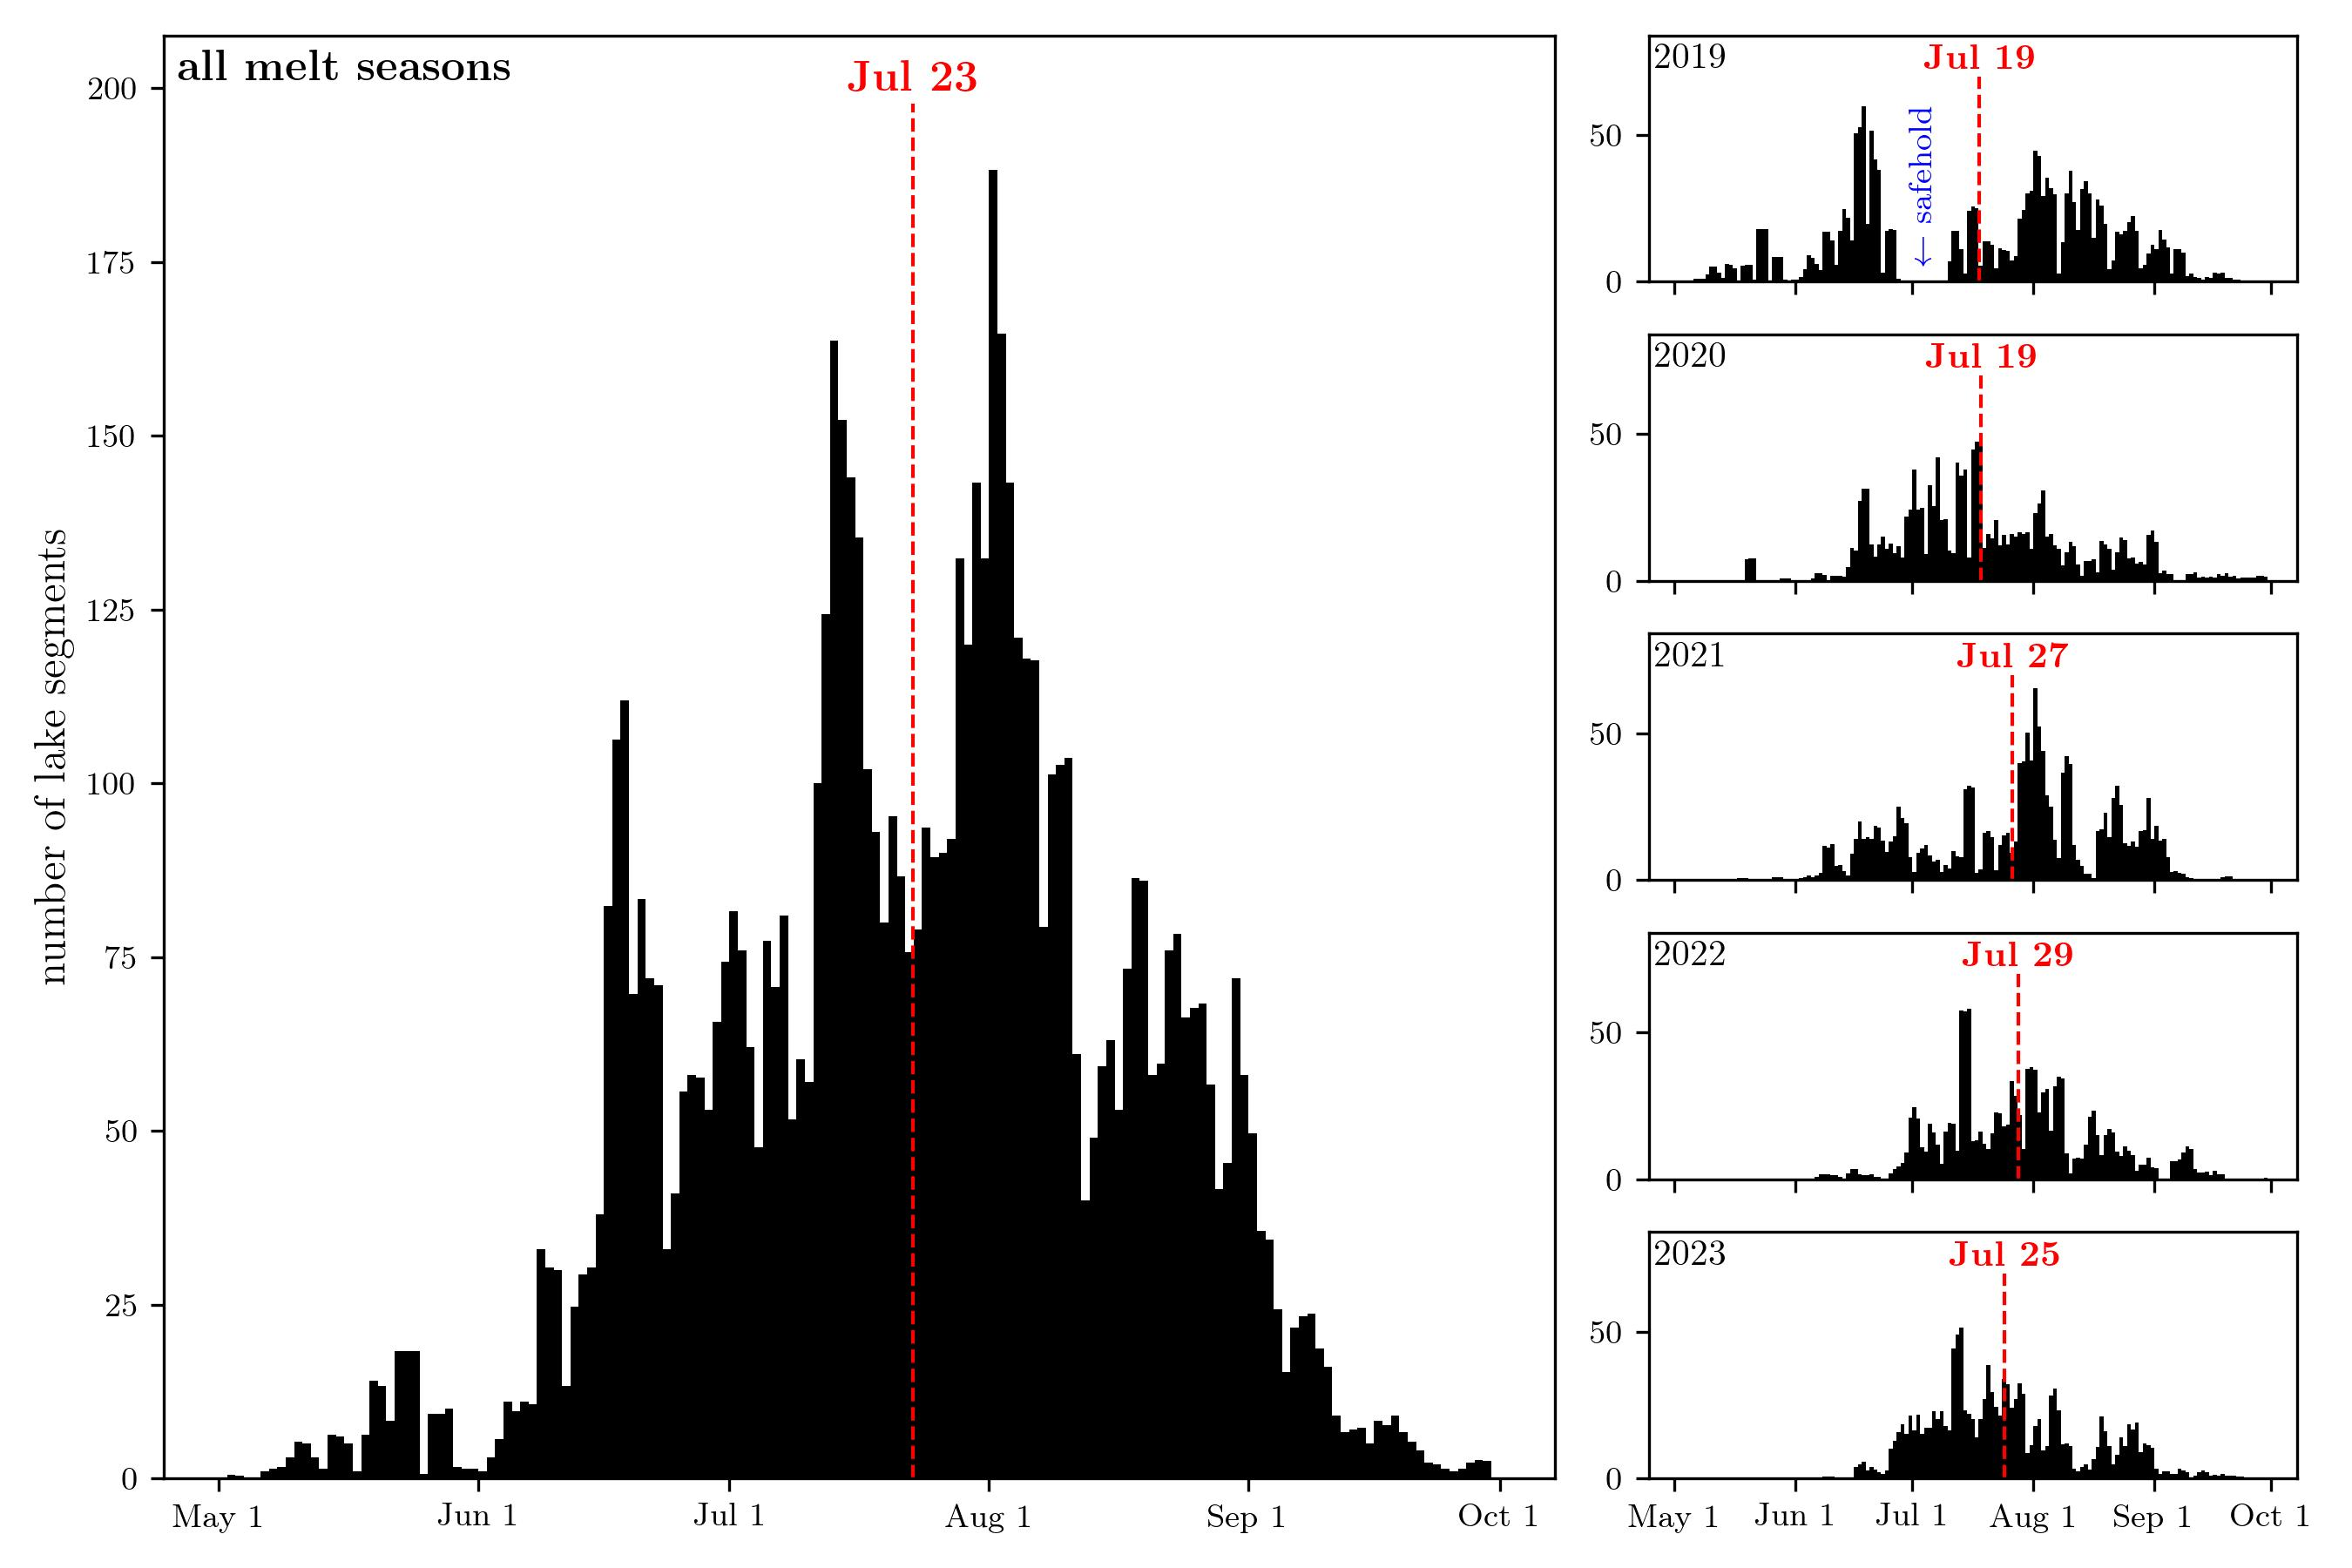

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima",
    'font.size': 9,
})

fig = plt.figure(figsize=[9,6])
gs = fig.add_gridspec(5, 3)

year_list = np.arange(2019,2024)
dt_list = [datetime(2019,i,1) for i in np.arange(5,11)]
doy_list = [x.timetuple().tm_yday for x in dt_list]
ylab_list = [x.strftime('%b %-d') for x in dt_list]

axs = []
axs.append(fig.add_subplot(gs[:,:2]))
for i in range(5):
    axs.append(fig.add_subplot(gs[i,2], sharex=axs[-1]))
    if i < 4:
        axs[-1].tick_params(axis='both', which='both', labelbottom=False)

bins = np.arange(gdfg.doy.min()-0.5, gdfg.doy.max()+0.5)
mids = bins[:-1] + np.diff(bins)

ax = axs[0]
hist = np.histogram(gdfg.doy, bins)
hist_smooth = pd.Series(hist[0]).rolling(window=3, center=True, min_periods=1).mean()
ax.bar(mids, hist_smooth, width=1.0, color='k')
daymean = gdfg.doy.mean()
daymean_str = (datetime(2019, 1, 1) + timedelta(days=daymean)).strftime("%b %d")
yl = ax.get_ylim()
ax.plot([daymean]*2, yl, color='r', lw=1, ls='--')
ax.text(daymean, yl[1]+0.003*(yl[1]-yl[0]), '\\textbf{%s}' % daymean_str, ha='center', va='bottom', color='r', fontsize=12)
ax.set_ylim((yl[0], yl[1] + 0.05*(yl[1] - yl[0])))
ax.set_ylabel('number of lake segments', fontsize=12)
ax.set_xticks(doy_list, labels=ylab_list)
ax.text(0.01, 0.99, '\\textbf{all melt seasons}', ha='left', va='top', transform=ax.transAxes, fontsize=12)

for iyr, yr in enumerate(year_list):
    ax = axs[iyr+1]
    gdfgyr = gdfg[gdfg.melt_season == yr].copy()
    hist = np.histogram(gdfgyr.doy, bins)
    hist_smooth = pd.Series(hist[0]).rolling(window=3, center=True, min_periods=1).mean()
    ax.bar(mids, hist_smooth, width=1.0, color='k')
    daymean = gdfgyr.doy.mean()
    daymean_str = (datetime(2019, 1, 1) + timedelta(days=daymean)).strftime("%b %d")
    yl = (0,70)
    ax.set_ylim(yl)
    ax.plot([daymean]*2, yl, color='r', lw=1, ls='--')
    ax.text(daymean, yl[1]+0.003*(yl[1]-yl[0]), '\\textbf{%s}' % daymean_str, ha='center', va='bottom', color='r', fontsize=10)
    ax.set_ylim((yl[0], yl[1] + 0.2*(yl[1] - yl[0])))
    ax.set_xticks(doy_list, labels=ylab_list)
    ax.text(0.01, 0.97, yr, ha='left', va='top', transform=ax.transAxes, fontsize=10)

safehold_date = datetime(2019, 7, 4)
safehold_doy = safehold_date.timetuple().tm_yday
axs[1].text(safehold_doy, 5, '$\\leftarrow$ safehold', ha='center', va='bottom', rotation='vertical', color='blue')

fig.tight_layout()
figname = 'figures/others/lake_segment_timing.jpg'
fig.savefig(figname, dpi=300)
plt.close(fig)
display(Image(figname))

# map of lake segment color-coded by depth, with ICESat-2 RGT coverage

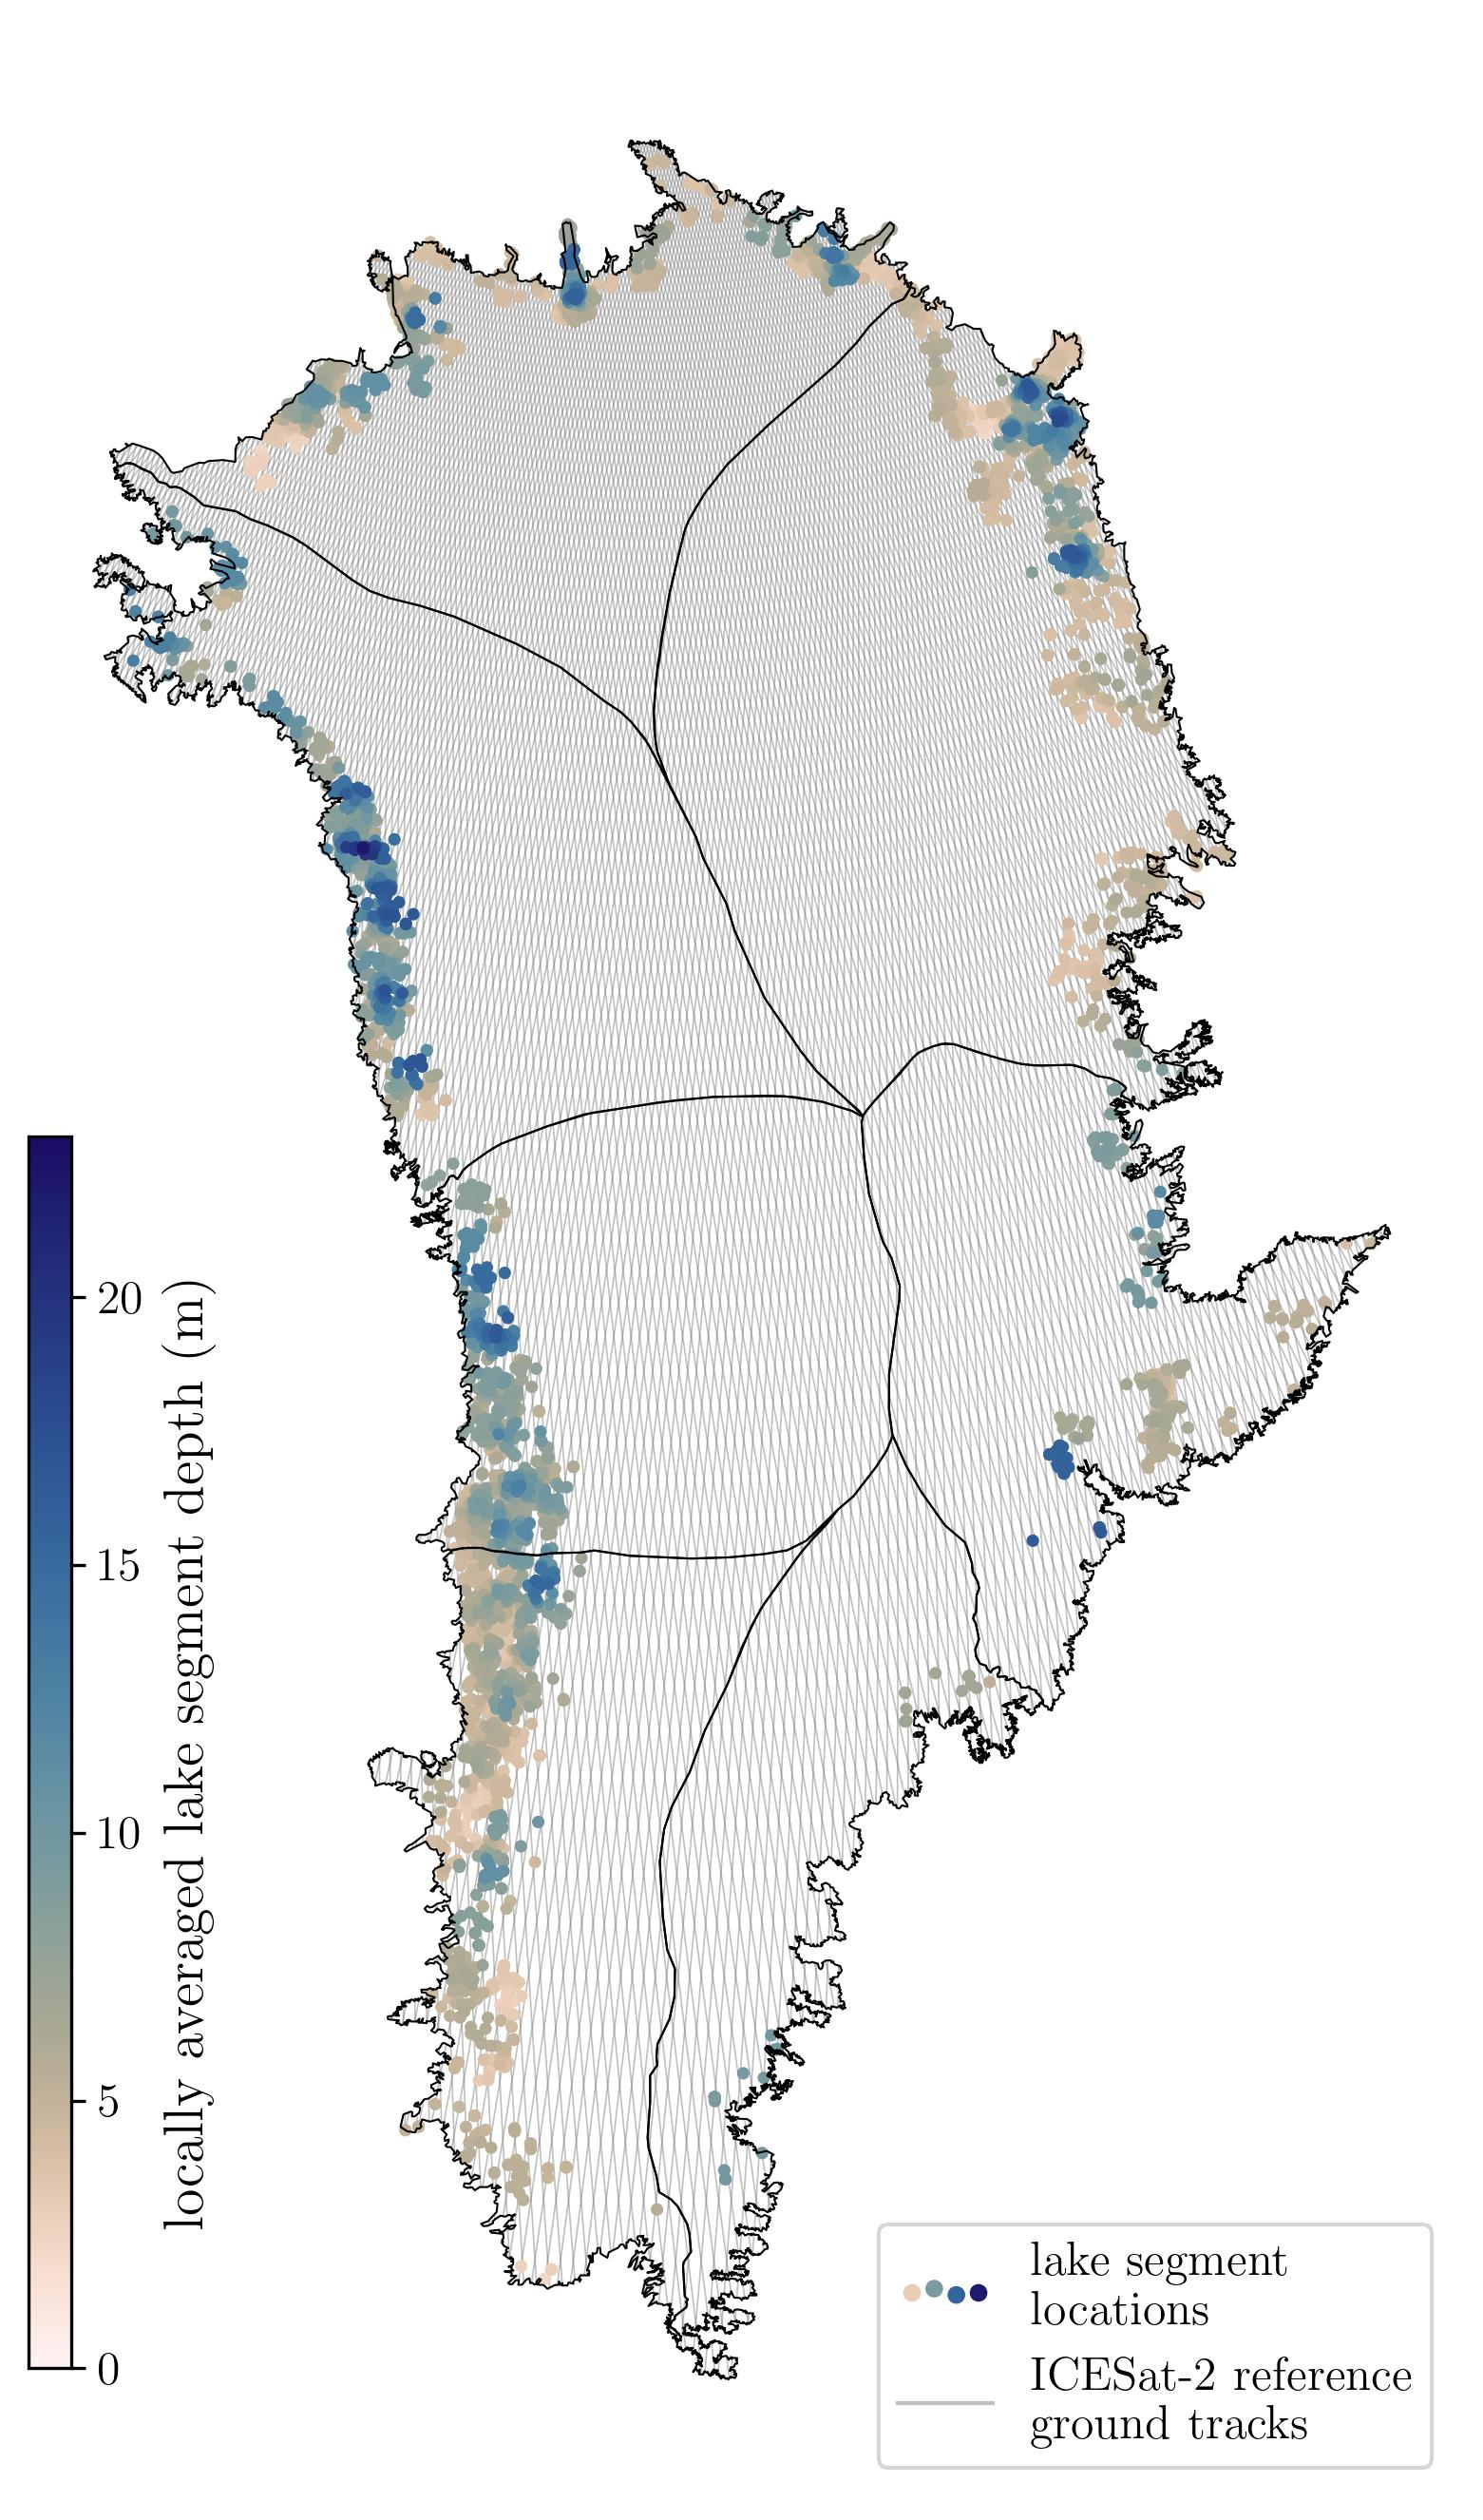

In [6]:
from scipy.spatial import cKDTree

k_nearest = 30
quantile = 0.75
maxdist = 1e5 # 100 km

gdfnnz[['x', 'y']] = gdfnnz.get_coordinates()
coordinates = gdfnnz[['x', 'y']].values
kdtree = cKDTree(coordinates)
distances, indices = kdtree.query(coordinates, k=k_nearest)
neighbor_max_depths = gdfnnz['max_depth'].values[indices]
neighbor_max_depths[distances > maxdist] = np.nan
mean_neighbor_depth = pd.DataFrame(neighbor_max_depths).apply(lambda x: (x[x >= x.quantile(quantile)]).mean(), axis=1)
gdfnnz['mean_neighbor_depth'] = mean_neighbor_depth

plt.close('all')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima",
    'font.size': 12,
})

rgt_gre = gpd.read_file('data/shapefiles/rgts_gris_clipped.shp')

fig, ax = plt.subplots(figsize=[6,9], dpi=70)

ax.axis('off')
gdf_basins.plot(ax=ax, color='none', edgecolor='black', lw=0.5, zorder=10)
xlim_map = ax.get_xlim()
ylim_map = ax.get_ylim()

rgt_color = 'gray'
rgt_gre.plot(ax=ax, lw=0.4, color=rgt_color, alpha=0.5, zorder=8)
hdl_rgt, = ax.plot([0,0], [0,0], lw=1, color=rgt_color, alpha=0.5, label='ICESat-2 reference\nground tracks')

gdfscatt = gdfnnz.copy().sort_values(by='mean_neighbor_depth').reset_index(drop=False)

vmin = 0
vmax = np.ceil(gdfscatt.mean_neighbor_depth.max())
cmap = cmc.lapaz_r
# cmap = cmc.buda_r
# gdfscatt.plot(ax=ax, markersize=10, alpha=1, column='mean_neighbor_depth', cmap=cmap, vmin=vmin, vmax=vmax, edgecolors='k', linewidth=0.1)
gdfscatt.plot(ax=ax, markersize=10, alpha=1, column='mean_neighbor_depth', cmap=cmap, vmin=vmin, vmax=vmax, 
                          edgecolors='none', linewidth=0, zorder=9)
npts = 4
hdl_scatt = ax.scatter([0]*npts, [0]*npts, s=20, c=np.linspace(vmin+3,vmax-1,npts), edgecolors='none', linewidth=0, 
                       cmap=cmap, label='lake segment\nlocations', vmin=vmin, vmax=vmax)

divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='3%', pad=0.05)
cax = ax.inset_axes([0.0, 0.05, 0.03, 0.5])
smap = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
smap._A = []
cbar = plt.colorbar(smap, cax=cax, orientation='vertical')
cax.set_ylabel('locally averaged lake segment depth (m)', fontsize=14)

ax.set_xlim(xlim_map)
ax.set_ylim(ylim_map)

ax.legend(handles=[hdl_scatt, hdl_rgt], scatterpoints=npts)

fig.tight_layout()
figname = 'figures/others/map_locations_depthcolored_rgts.jpg'
fig.savefig(figname, dpi=300, bbox_inches='tight')
plt.close(fig)
display(Image(figname))

# RGT coverage map on it's own

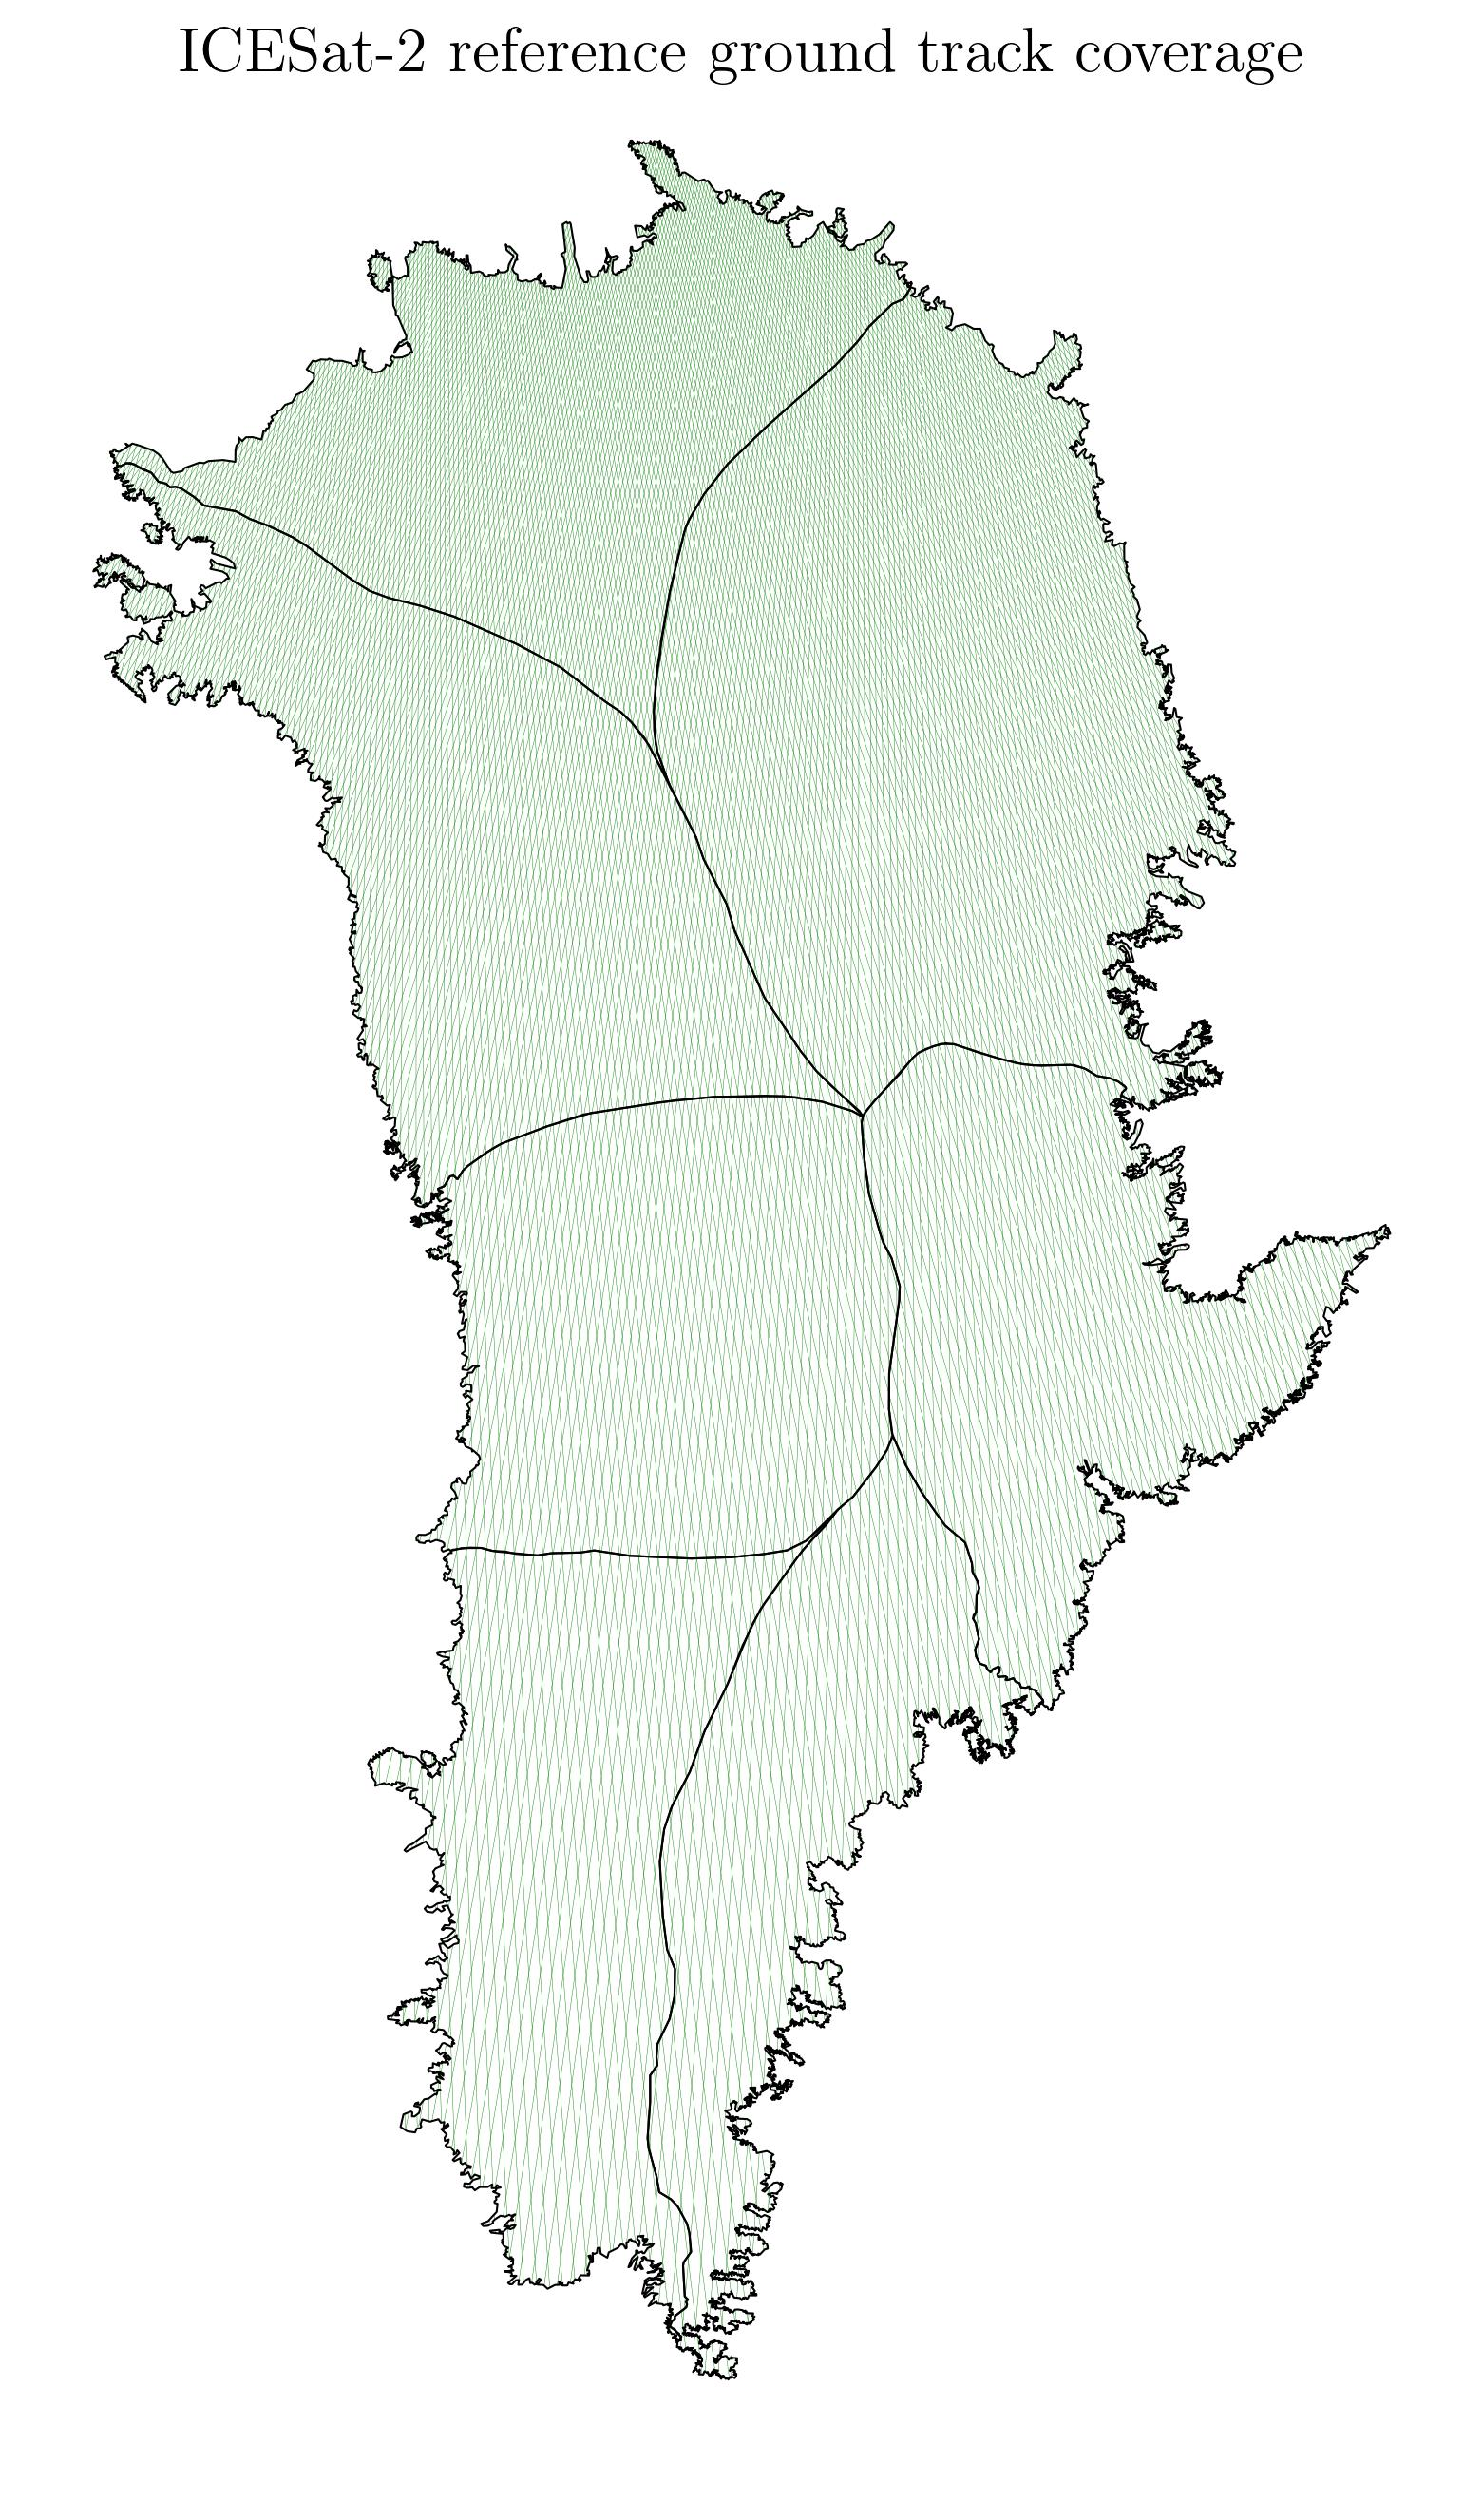

In [7]:
fig, ax = plt.subplots(figsize=[6,9], dpi=70)
ax.axis('off')
gdf_basins.plot(ax=ax, color='none', edgecolor='black', lw=0.5, zorder=10)
rgt_gre.clip(gdf_basins).plot(ax=ax, lw=0.1, color='green', alpha=1)
ax.text(0.5, 1.0, 'ICESat-2 reference ground track coverage', ha='center', va='top', transform=ax.transAxes, fontsize=16)

fig.tight_layout()
figname = 'figures/others/greenland_icesat2_rgt_coverage.jpg'
fig.savefig(figname, dpi=300, bbox_inches='tight')
plt.close(fig)
display(Image(figname))

# distributions of depth/elevation by season/basin

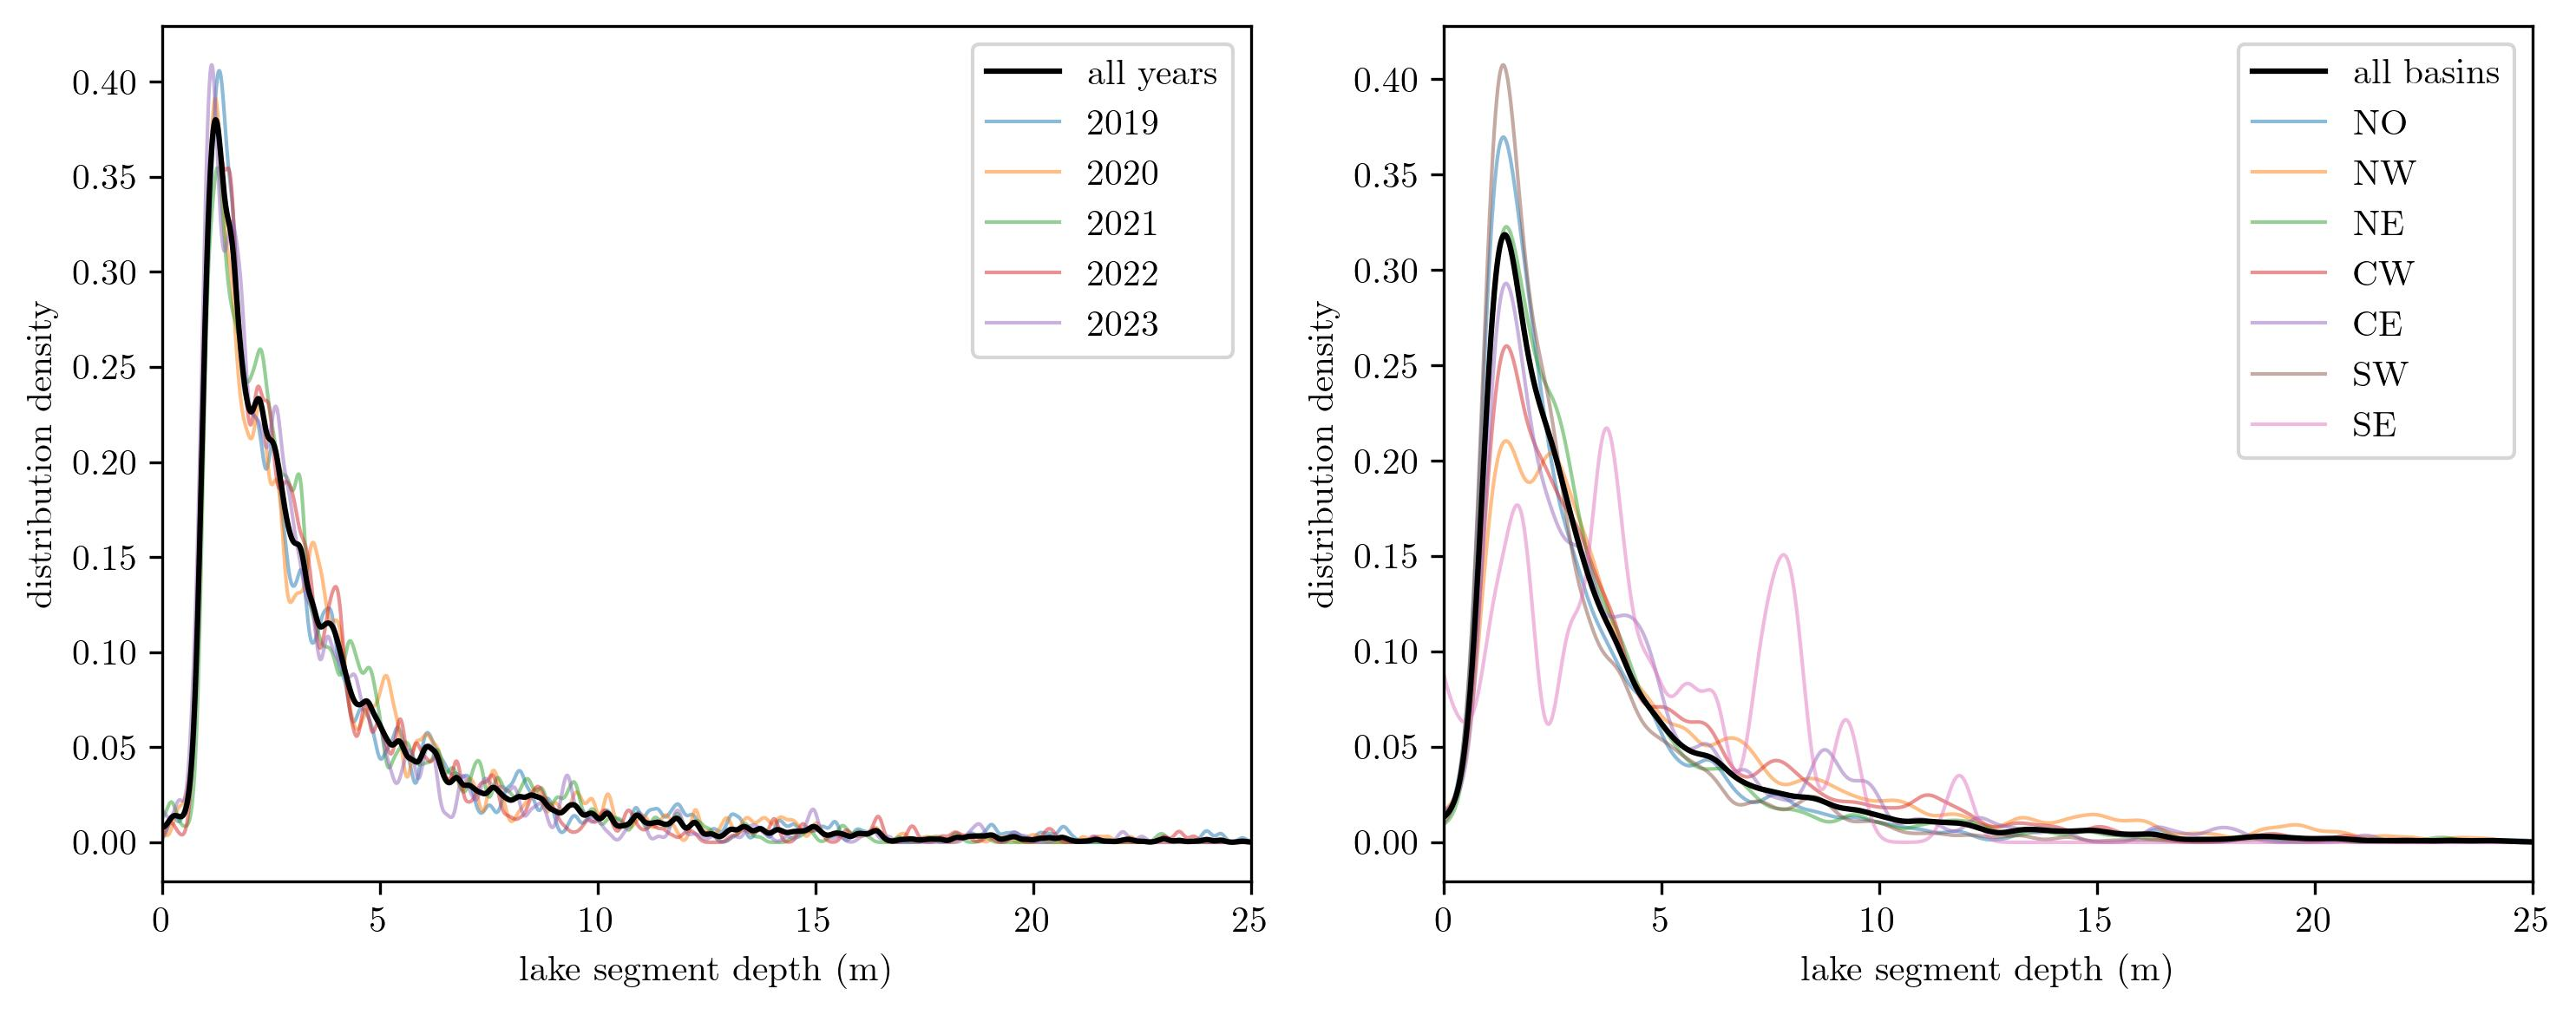

In [8]:
plt.close('all')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima",
    'font.size': 10,
})

fig, axs = plt.subplots(ncols=2, figsize=[10,4])

basin_list = ['NO', 'NW', 'NE', 'CW', 'CE', 'SW', 'SE']
year_list = np.arange(2019,2024)

maxdepth = 35
step_hist = 0.01
smooth_len = 0.1

xl = [0, 25]

gdfnnz = gdfg[gdfg.max_depth > 0].copy()

bins = np.arange(0,maxdepth+step_hist, step_hist)
mids = bins[:-1] + np.diff(bins)
ax = axs[0]
hist = np.histogram(gdfnnz.max_depth, bins=bins, density=True)
wdw = int(np.ceil(smooth_len/step_hist))
hist_smooth = pd.Series(hist[0]).rolling(window=wdw*10, min_periods=1, center=True, win_type='gaussian').mean(std=wdw)
ax.plot(mids, hist_smooth, 'k-', zorder=10, label='all years')
for yr in year_list:
    dfy = gdfnnz[gdfnnz.melt_season==yr].copy()
    hist_yr = np.histogram(dfy.max_depth, bins=bins, density=True)
    hist_yr_smooth = pd.Series(hist_yr[0]).rolling(window=wdw*10, min_periods=1, center=True, win_type='gaussian').mean(std=wdw)
    ax.plot(mids, hist_yr_smooth, alpha=0.5, lw=1, label=yr)
ax.legend(loc='upper right')
ax.set_xlim(xl)
ax.set_xlabel('lake segment depth (m)')
ax.set_ylabel('distribution density')

ax = axs[1]
smooth_len = 0.3
wdw = int(np.ceil(smooth_len/step_hist))
hist_smooth = pd.Series(hist[0]).rolling(window=wdw*10, min_periods=1, center=True, win_type='gaussian').mean(std=wdw)
ax.plot(mids, hist_smooth, 'k-', zorder=10, label='all basins')
for bas in basin_list:
    dfb = gdfnnz[gdfnnz.basin==bas].copy()
    hist_bs = np.histogram(dfb.max_depth, bins=bins, density=True)
    hist_bs_smooth = pd.Series(hist_bs[0]).rolling(window=wdw*10, min_periods=1, center=True, win_type='gaussian').mean(std=wdw)
    ax.plot(mids, hist_bs_smooth, alpha=0.5, lw=1, label=bas)
ax.legend(loc='upper right')
ax.set_xlim(xl)
ax.set_xlabel('lake segment depth (m)')
ax.set_ylabel('distribution density')

fig.tight_layout()
figname = 'figures/others/depth_distributions_by_basin_year.jpg'
fig.savefig(figname, dpi=300, bbox_inches='tight')
plt.close(fig)
display(Image(figname))

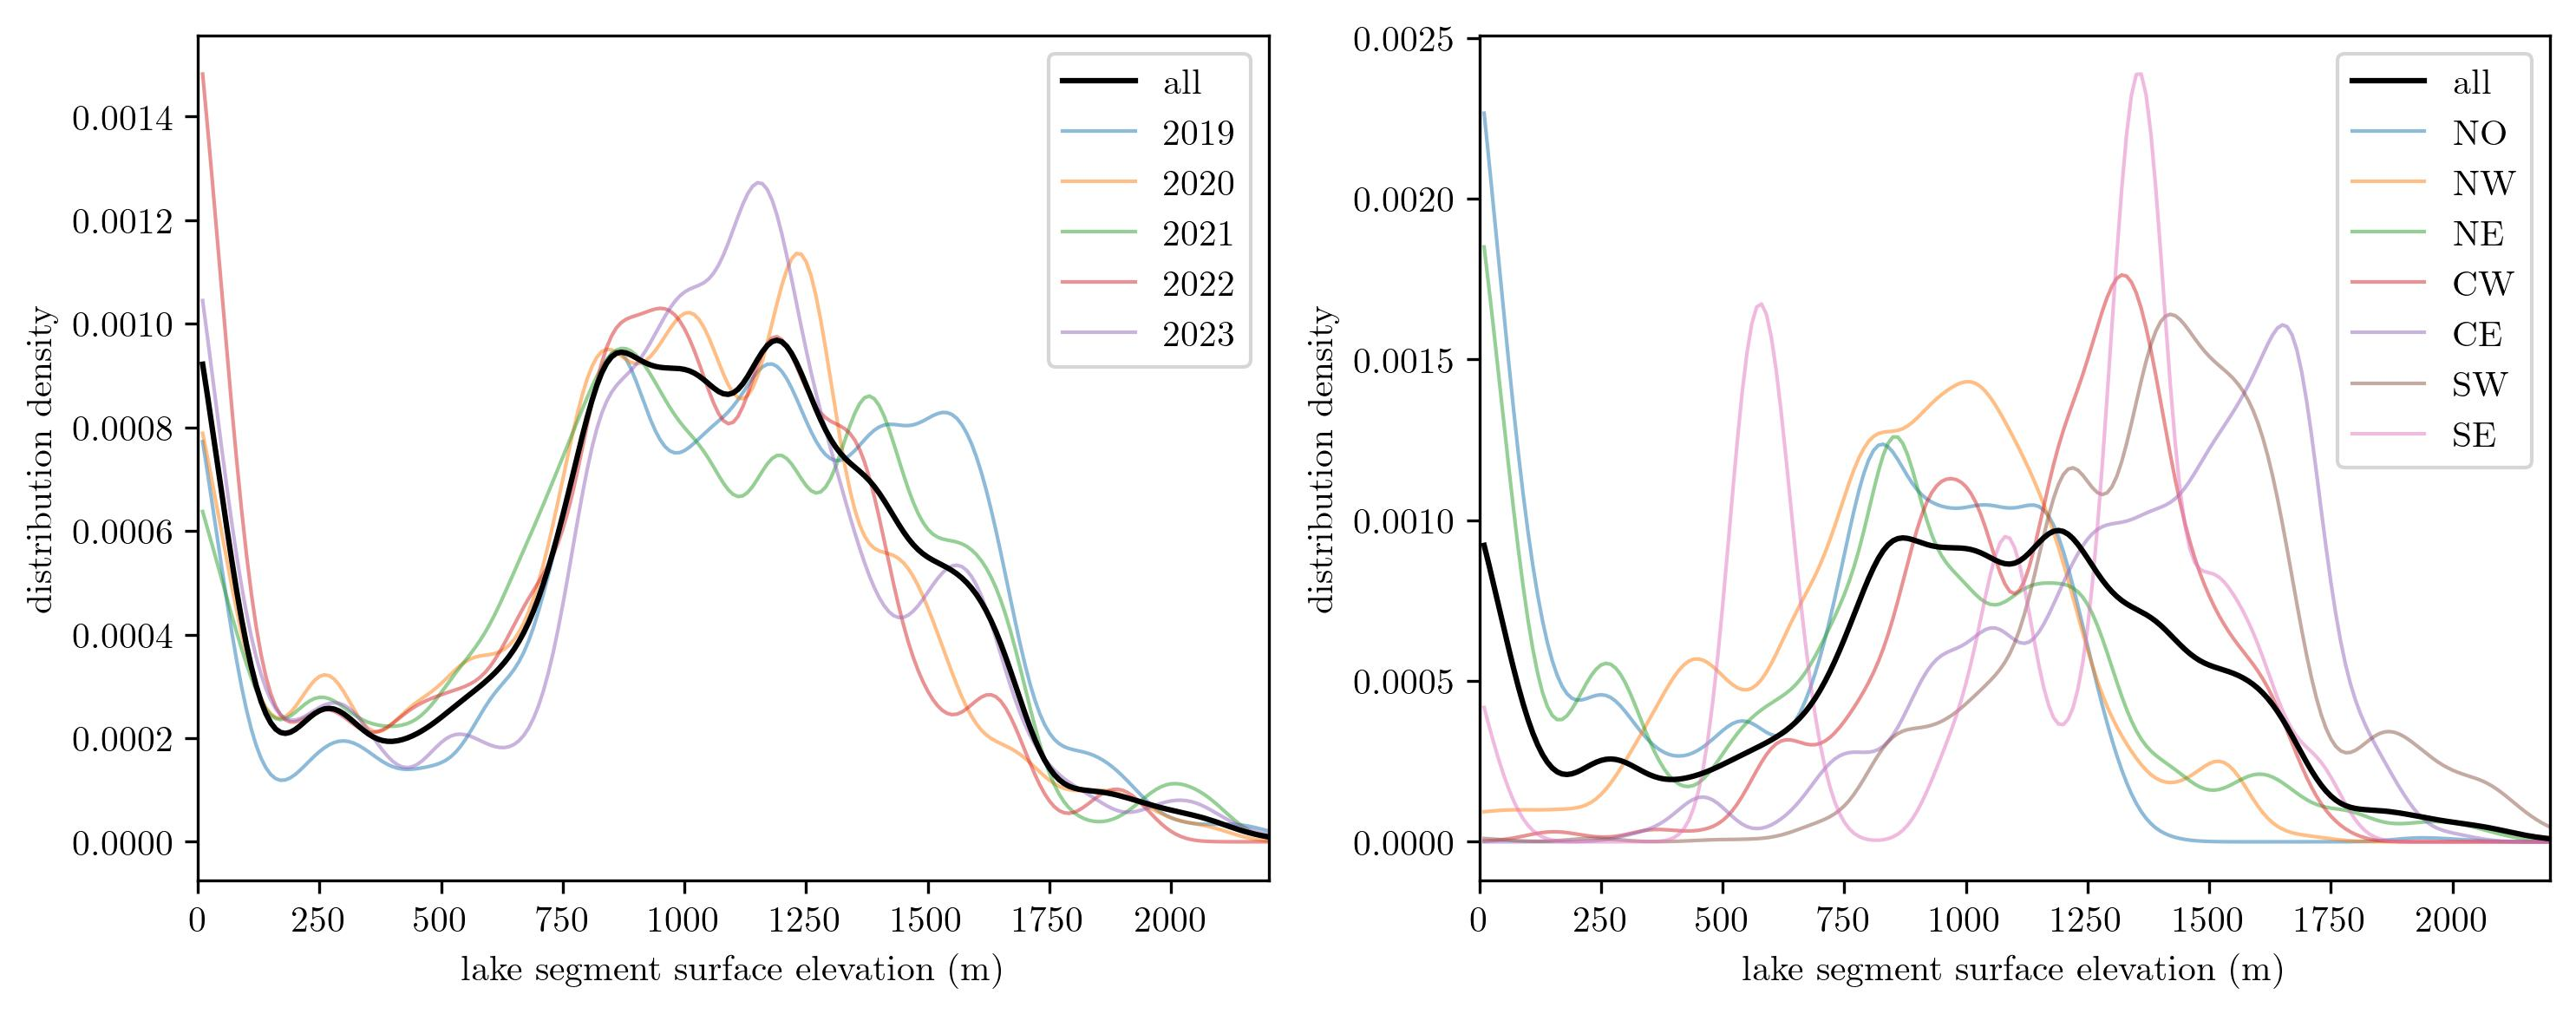

In [9]:
plt.close('all')

fig, axs = plt.subplots(ncols=2, figsize=[10,4])

maxelev = 2200
step_hist = 10
smooth_len = 50

# remove "zero-depth" lake segments and segments below elevation threshold (floating tongues)
gdfnnz = gdfg[gdfg.max_depth > 0].copy()
# gdfnnz = gdfnnz[gdfnnz.surface_elevation >= min_elev]
gdfnnz = gdfnnz[gdfnnz.is_grounded]

xl = [0, 2200]

bins = np.arange(0,maxelev+step_hist, step_hist)
mids = bins[:-1] + np.diff(bins)
ax = axs[0]
hist = np.histogram(gdfg.surface_elevation, bins=bins, density=True)
wdw = int(np.ceil(smooth_len/step_hist))
hist_smooth = pd.Series(hist[0]).rolling(window=wdw*10, min_periods=1, center=True, win_type='gaussian').mean(std=wdw)
ax.plot(mids, hist_smooth, 'k-', zorder=10, label='all')
for yr in year_list:
    dfy = gdfg[gdfg.melt_season==yr].copy()
    hist_yr = np.histogram(dfy.surface_elevation, bins=bins, density=True)
    hist_yr_smooth = pd.Series(hist_yr[0]).rolling(window=wdw*10, min_periods=1, center=True, win_type='gaussian').mean(std=wdw)
    ax.plot(mids, hist_yr_smooth, alpha=0.5, lw=1, label=yr)

ax.legend(loc='upper right')
ax.set_xlim(xl)
ax.set_xlabel('lake segment surface elevation (m)')
ax.set_ylabel('distribution density')

ax = axs[1]
ax.plot(mids, hist_smooth, 'k-', zorder=10, label='all')
for bas in basin_list:
    dfb = gdfg[gdfg.basin==bas].copy()
    hist_bs = np.histogram(dfb.surface_elevation, bins=bins, density=True)
    hist_bs_smooth = pd.Series(hist_bs[0]).rolling(window=wdw*10, min_periods=1, center=True, win_type='gaussian').mean(std=wdw)
    ax.plot(mids, hist_bs_smooth, alpha=0.5, lw=1, label=bas)

ax.legend(loc='upper right')
ax.set_xlim(xl)
ax.set_xlabel('lake segment surface elevation (m)')
ax.set_ylabel('distribution density')

fig.tight_layout()
figname = 'figures/others/elev_distributions_by_basin_year.jpg'
fig.savefig(figname, dpi=300, bbox_inches='tight')
plt.close(fig)
display(Image(figname))

# elevation - grounded only

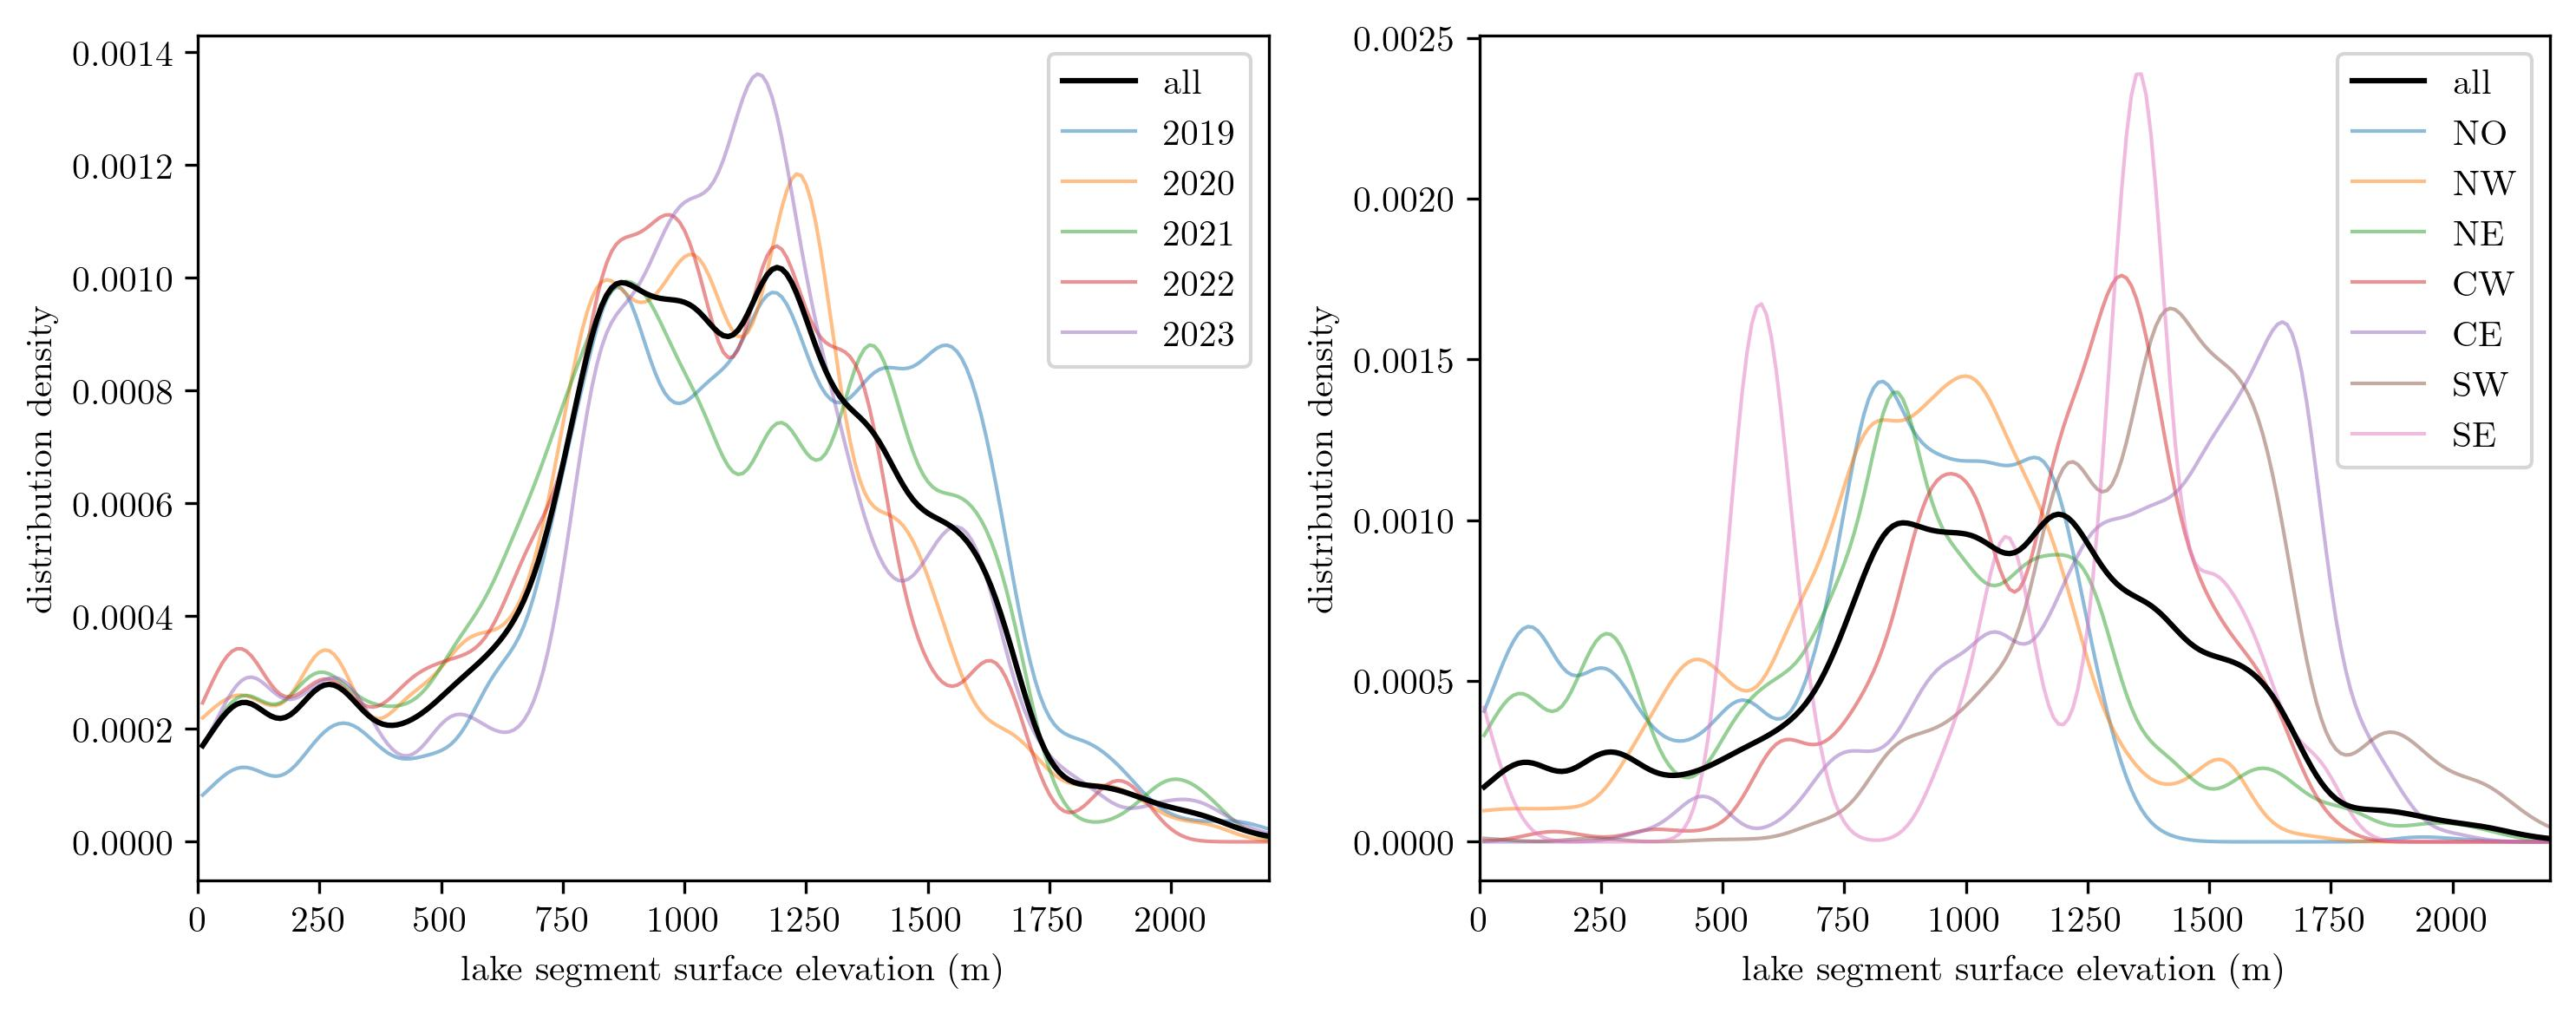

In [113]:
plt.close('all')

fig, axs = plt.subplots(ncols=2, figsize=[10,4])

maxelev = 2200
step_hist = 10
smooth_len = 50

# remove "zero-depth" lake segments and segments below elevation threshold (floating tongues)
gdfnnz = gdfg[gdfg.max_depth > 0].copy()
# gdfnnz = gdfnnz[gdfnnz.surface_elevation >= min_elev]
gdfnnz = gdfnnz[gdfnnz.is_grounded]

xl = [0, 2200]

bins = np.arange(0,maxelev+step_hist, step_hist)
mids = bins[:-1] + np.diff(bins)
ax = axs[0]
hist = np.histogram(gdfnnz.surface_elevation, bins=bins, density=True)
wdw = int(np.ceil(smooth_len/step_hist))
hist_smooth = pd.Series(hist[0]).rolling(window=wdw*10, min_periods=1, center=True, win_type='gaussian').mean(std=wdw)
ax.plot(mids, hist_smooth, 'k-', zorder=10, label='all')
for yr in year_list:
    dfy = gdfnnz[gdfnnz.melt_season==yr].copy()
    hist_yr = np.histogram(dfy.surface_elevation, bins=bins, density=True)
    hist_yr_smooth = pd.Series(hist_yr[0]).rolling(window=wdw*10, min_periods=1, center=True, win_type='gaussian').mean(std=wdw)
    ax.plot(mids, hist_yr_smooth, alpha=0.5, lw=1, label=yr)

ax.legend(loc='upper right')
ax.set_xlim(xl)
ax.set_xlabel('lake segment surface elevation (m)')
ax.set_ylabel('distribution density')

ax = axs[1]
ax.plot(mids, hist_smooth, 'k-', zorder=10, label='all')
for bas in basin_list:
    dfb = gdfnnz[gdfnnz.basin==bas].copy()
    hist_bs = np.histogram(dfb.surface_elevation, bins=bins, density=True)
    hist_bs_smooth = pd.Series(hist_bs[0]).rolling(window=wdw*10, min_periods=1, center=True, win_type='gaussian').mean(std=wdw)
    ax.plot(mids, hist_bs_smooth, alpha=0.5, lw=1, label=bas)

ax.legend(loc='upper right')
ax.set_xlim(xl)
ax.set_xlabel('lake segment surface elevation (m)')
ax.set_ylabel('distribution density')

fig.tight_layout()
figname = 'figures/others/elev_distributions_by_basin_year.jpg'
fig.savefig(figname, dpi=300, bbox_inches='tight')
plt.close(fig)
display(Image(figname))

In [119]:
min_thresh = 750
max_thresh = 1700
frac_elevband = len(gdfnnz[(gdfnnz.surface_elevation >= min_thresh) & (gdfnnz.surface_elevation <= max_thresh)]) / len(gdfnnz)
print('Of grounded lakes, %.0f%% are found between %.0fm and %.0fm elevation.' % (frac_elevband*100, min_thresh, max_thresh))

Of grounded lakes, 75% are found between 750m and 1700m elevation.


In [128]:
min_thresh = 0
max_thresh = 200
gdf_no_ne = gdfg[(gdfg.basin == 'NO') | (gdfg.basin == 'NE')]
frac_elevband = len(gdf_no_ne[(gdf_no_ne.surface_elevation >= min_thresh) & (gdf_no_ne.surface_elevation <= max_thresh)]) / len(gdf_no_ne)
print('Of all lakes in NO and NE, %.0f%% are found between %.0fm and %.0fm elevation.' % (frac_elevband*100, min_thresh, max_thresh))

Of all lakes in NO and NE, 19% are found between 0m and 200m elevation.


In [122]:
gdffloat = gdfg[(gdfg.max_depth > 0) & (~gdfg.is_grounded)]
gdffloat.surface_elevation.mean()

73.81999107538452

# depth - elevation relationship

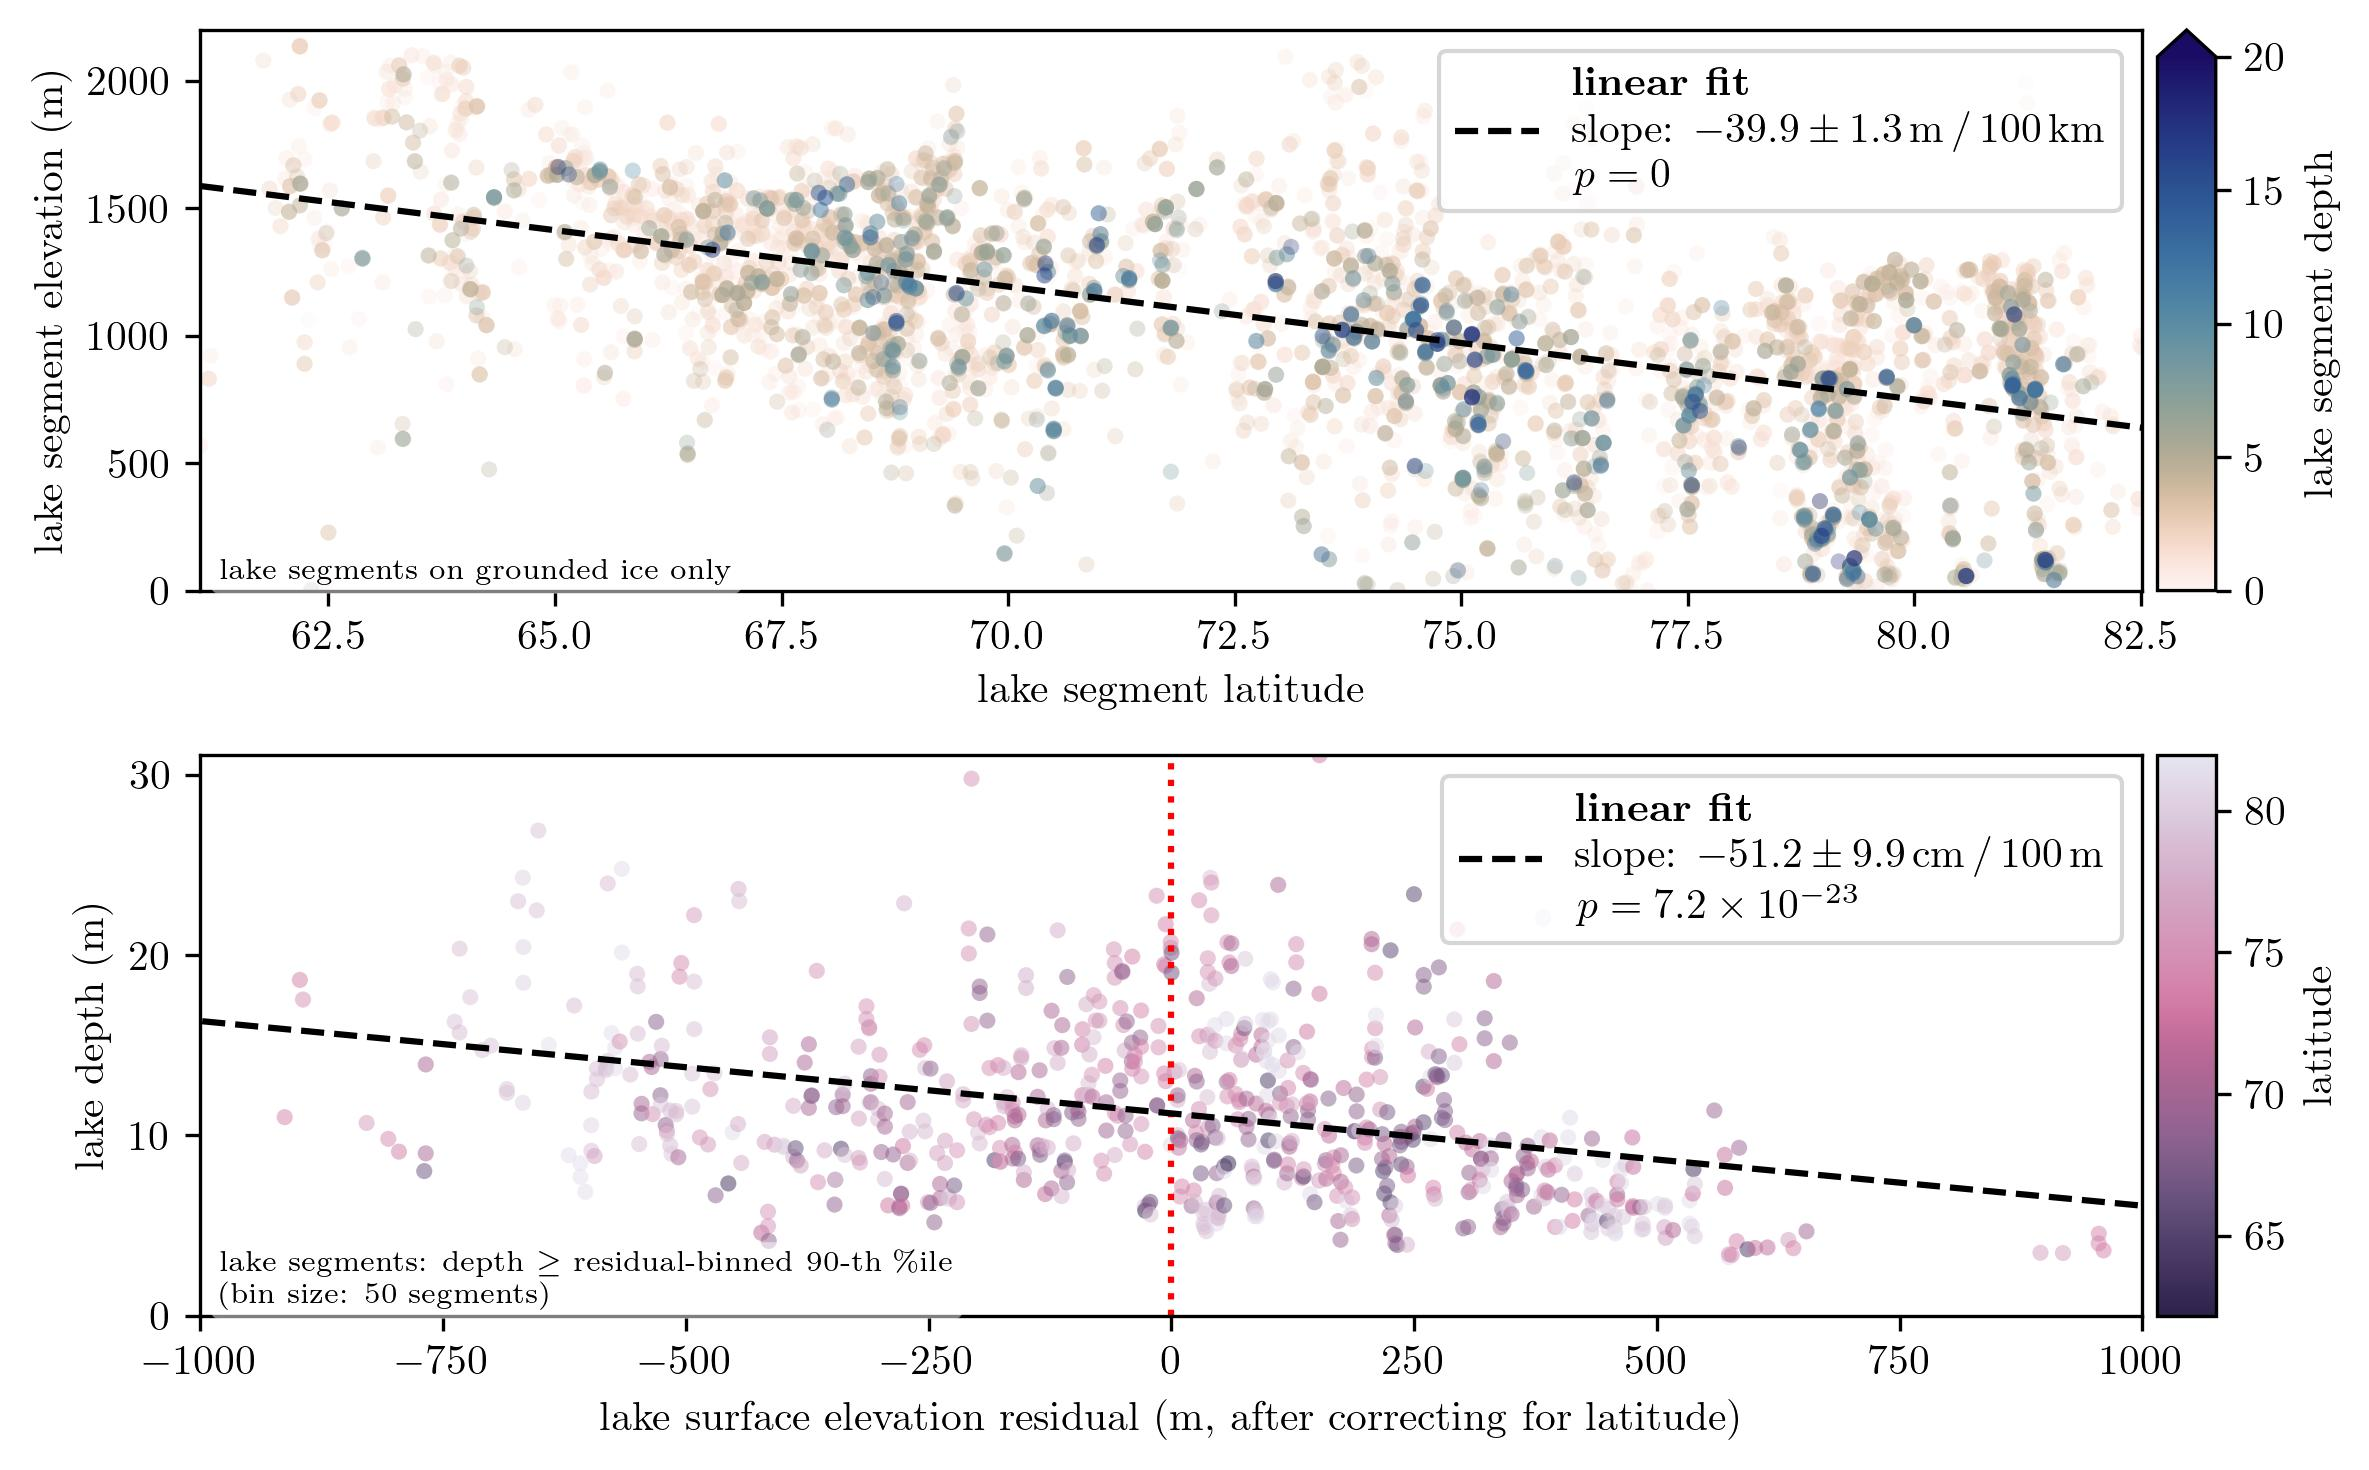

In [22]:
group_size = 50
min_elev = 0
quantile = 0.9

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima",
    'font.size': 10,
})
plt.close('all')

descr_fsz = 7

# remove "zero-depth" lake segments and segments below elevation threshold (floating tongues)
gdfnnz = gdfg[gdfg.max_depth > 0].copy()
# gdfnnz = gdfnnz[gdfnnz.surface_elevation >= min_elev]
gdfnnz = gdfnnz[gdfnnz.is_grounded]

# get the linear fit to elevation vs. latitude
elevation_lat_model = sm.OLS(gdfnnz['surface_elevation'], sm.add_constant(gdfnnz['lat'])).fit()
gdfnnz['elevation_residuals'] = elevation_lat_model.resid
km_per_lat = 111
slope_elev = elevation_lat_model.params.lat / km_per_lat * 100 # m / 100 km
ci = np.abs(elevation_lat_model.params.lat - elevation_lat_model.conf_int().iloc[1,0])
ci_slope_elev = ci / km_per_lat * 100 # m / 100 km
pval = ('%.2g' % elevation_lat_model.pvalues[1]).replace('e', '\\times 10^{')
if '{' in pval:
    pval = pval + '}'
elev_lat_label = '\\textbf{linear fit}\nslope: $%.1f \\pm %.1f \\mathrm{\\,m\\,/\\,100\\,km}$\n$p=%s$' % (slope_elev, ci_slope_elev, pval)

df_sorted = gdfnnz.copy().sort_values(by='surface_elevation').reset_index(drop=True)
df_sorted['elev_group'] = get_ordered_groups(group_size=group_size, length=len(df_sorted))
dfs = []
for g in df_sorted.elev_group.unique():
    thisdf = df_sorted[df_sorted.elev_group == g]
    dfs.append(thisdf[thisdf.max_depth >= thisdf.max_depth.quantile(quantile)])
dfdeep = pd.concat(dfs)

df_sorted = gdfnnz.copy().sort_values(by='elevation_residuals').reset_index(drop=True)
df_sorted['elev_group'] = get_ordered_groups(group_size=group_size, length=len(df_sorted))
dfs = []
for g in df_sorted.elev_group.unique():
    thisdf = df_sorted[df_sorted.elev_group == g]
    dfs.append(thisdf[thisdf.max_depth >= thisdf.max_depth.quantile(quantile)])
dfdeep_res = pd.concat(dfs)
    
# Now regress depth on elevation and the elevation residuals
depth_elev_model = sm.OLS(dfdeep['max_depth'], sm.add_constant(dfdeep['surface_elevation'])).fit()
depth_elev_res_model = sm.OLS(dfdeep_res['max_depth'], sm.add_constant(dfdeep_res['elevation_residuals'])).fit()

slope_depth_elev = depth_elev_model.params[1] * 10000 # cm / 100 m
ci_depth_elev = np.abs(depth_elev_model.params[1] - depth_elev_model.conf_int().iloc[1,0]) * 10000 # cm / 100 m
pval = ('%.2g' % depth_elev_model.pvalues[1]).replace('e', '\\times 10^{')
if '{' in pval:
    pval = pval + '}'
depth_elev_label = '\\textbf{linear fit}\nslope: $%.1f \\pm %.1f \\mathrm{\\,cm\\,/\\,100\\,m}$\n$p=%s$' % (slope_depth_elev, ci_depth_elev, pval)

slope_depth_elevres = depth_elev_res_model.params[1] * 10000 # cm / 100 m
ci_depth_elevres = np.abs(depth_elev_res_model.params[1] - depth_elev_res_model.conf_int().iloc[1,0]) * 10000 # cm / 100 m
pval = ('%.2g' % depth_elev_res_model.pvalues[1]).replace('e', '\\times 10^{')
if '{' in pval:
    pval = pval + '}'
depth_elevres_label = '\\textbf{linear fit}\nslope: $%.1f \\pm %.1f \\mathrm{\\,cm\\,/\\,100\\,m}$\n$p=%s$' % (slope_depth_elevres, ci_depth_elevres, pval)

pred_lats = np.linspace(gdfnnz.lat.min(), gdfnnz.lat.max())
pred_elevs = np.linspace(0, 2200)
pred_resid = np.linspace(-1100, 1100)
elevs_predicted = elevation_lat_model.predict(sm.add_constant(pred_lats))
depths_predicted = depth_elev_model.predict(sm.add_constant(pred_elevs))
depths_predicted_resid = depth_elev_res_model.predict(sm.add_constant(pred_resid))

fig, axs = plt.subplots(figsize=[8,5], nrows=2)
cmap_depth = cmc.lapaz_r
cmap_lat = cmc.acton

#################################################################################
ax = axs[0]
km_per_lat = 111
vmax = 20
slope_elev = elevation_lat_model.params.lat / km_per_lat * 100 # m / 100 km
dfsort = gdfnnz.sort_values(by='max_depth').reset_index(drop=True)
scatt = ax.scatter(dfsort.lat, dfsort.surface_elevation, s=15, c=dfsort.max_depth, alpha=0.3, edgecolors='none', 
                   cmap=cmap_depth, vmin=0, vmax=25)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
smap = plt.cm.ScalarMappable(cmap=cmap_depth, norm=plt.Normalize(vmin=0, vmax=vmax))
smap._A = []
cbar = plt.colorbar(smap, cax=cax, orientation='vertical', extend='max')
cax.set_ylabel('lake segment depth')

ax.plot(pred_lats, elevs_predicted, 'k--', label=elev_lat_label)

txt_bbx = dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle="Round, pad=0.3")
# txt = 'lake segments: $h_\\mathrm{surf} \\geq %i\\mathrm{\\,m}$' % min_elev
txt = 'lake segments on grounded ice only'
ax.text(0.01, 0.01, txt, ha='left', va='bottom', transform=ax.transAxes, bbox=txt_bbx, fontsize=descr_fsz)

ax.set_xlabel('lake segment latitude')
ax.set_ylabel('lake segment elevation (m)')
ax.set_xlim((gdfnnz.lat.min(), gdfnnz.lat.max()))
ax.set_ylim((0,2200))
ax.legend(loc='upper right')

#################################################################################
# ax = axs[1]
# scatt = ax.scatter(dfdeep.surface_elevation, dfdeep.max_depth, s=15, c=dfdeep.lat, alpha=0.5, edgecolors='none', cmap=cmc.roma)
# ax.plot(pred_elevs, depths_predicted, 'k--', label=depth_elev_label)

# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='3%', pad=0.05)
# fig.colorbar(scatt, cax=cax, orientation='vertical')
# cax.set_ylabel('latitude')

# ax.legend(loc='upper right')
# ax.set_xlabel('lake surface elevation (m)')
# ax.set_ylabel('lake depth (m)')
# ax.set_xlim((0, 2200))
# ax.set_ylim((0,dfdeep.max_depth.max()))

#################################################################################
# plot residuals
ax = axs[1]
scatt = ax.scatter(dfdeep_res.elevation_residuals, dfdeep_res.max_depth, s=15, c=dfdeep_res.lat, alpha=0.5, edgecolors='none', cmap=cmap_lat)

ax.axvline(0, color='red', ls=':')
ax.plot(pred_resid, depths_predicted_resid, 'k--', label=depth_elevres_label)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
smap = plt.cm.ScalarMappable(cmap=cmap_lat, norm=plt.Normalize(vmin=dfdeep_res.lat.min(), vmax=dfdeep_res.lat.max()))
smap._A = []
cbar = plt.colorbar(smap, cax=cax, orientation='vertical')
cax.set_ylabel('latitude')

txt = 'lake segments: depth $\\geq$ residual-binned $%g$-th \\%%ile\n(bin size: %i segments)' % (quantile*100, group_size)
ax.text(0.01, 0.01, txt, ha='left', va='bottom', transform=ax.transAxes, bbox=txt_bbx, fontsize=descr_fsz)

ax.legend(loc='upper right')
ax.set_xlabel('lake surface elevation residual (m, after correcting for latitude)')
ax.set_ylabel('lake depth (m)')
ax.set_xlim((-1000, 1000))
ax.set_ylim((0,dfdeep_res.max_depth.max()))

fig.tight_layout()

figfn = 'figures/others/elev_vs_depth.jpg'
fig.savefig(figfn, dpi=300, bbox_inches='tight')
plt.close(fig)
display(Image(figfn))

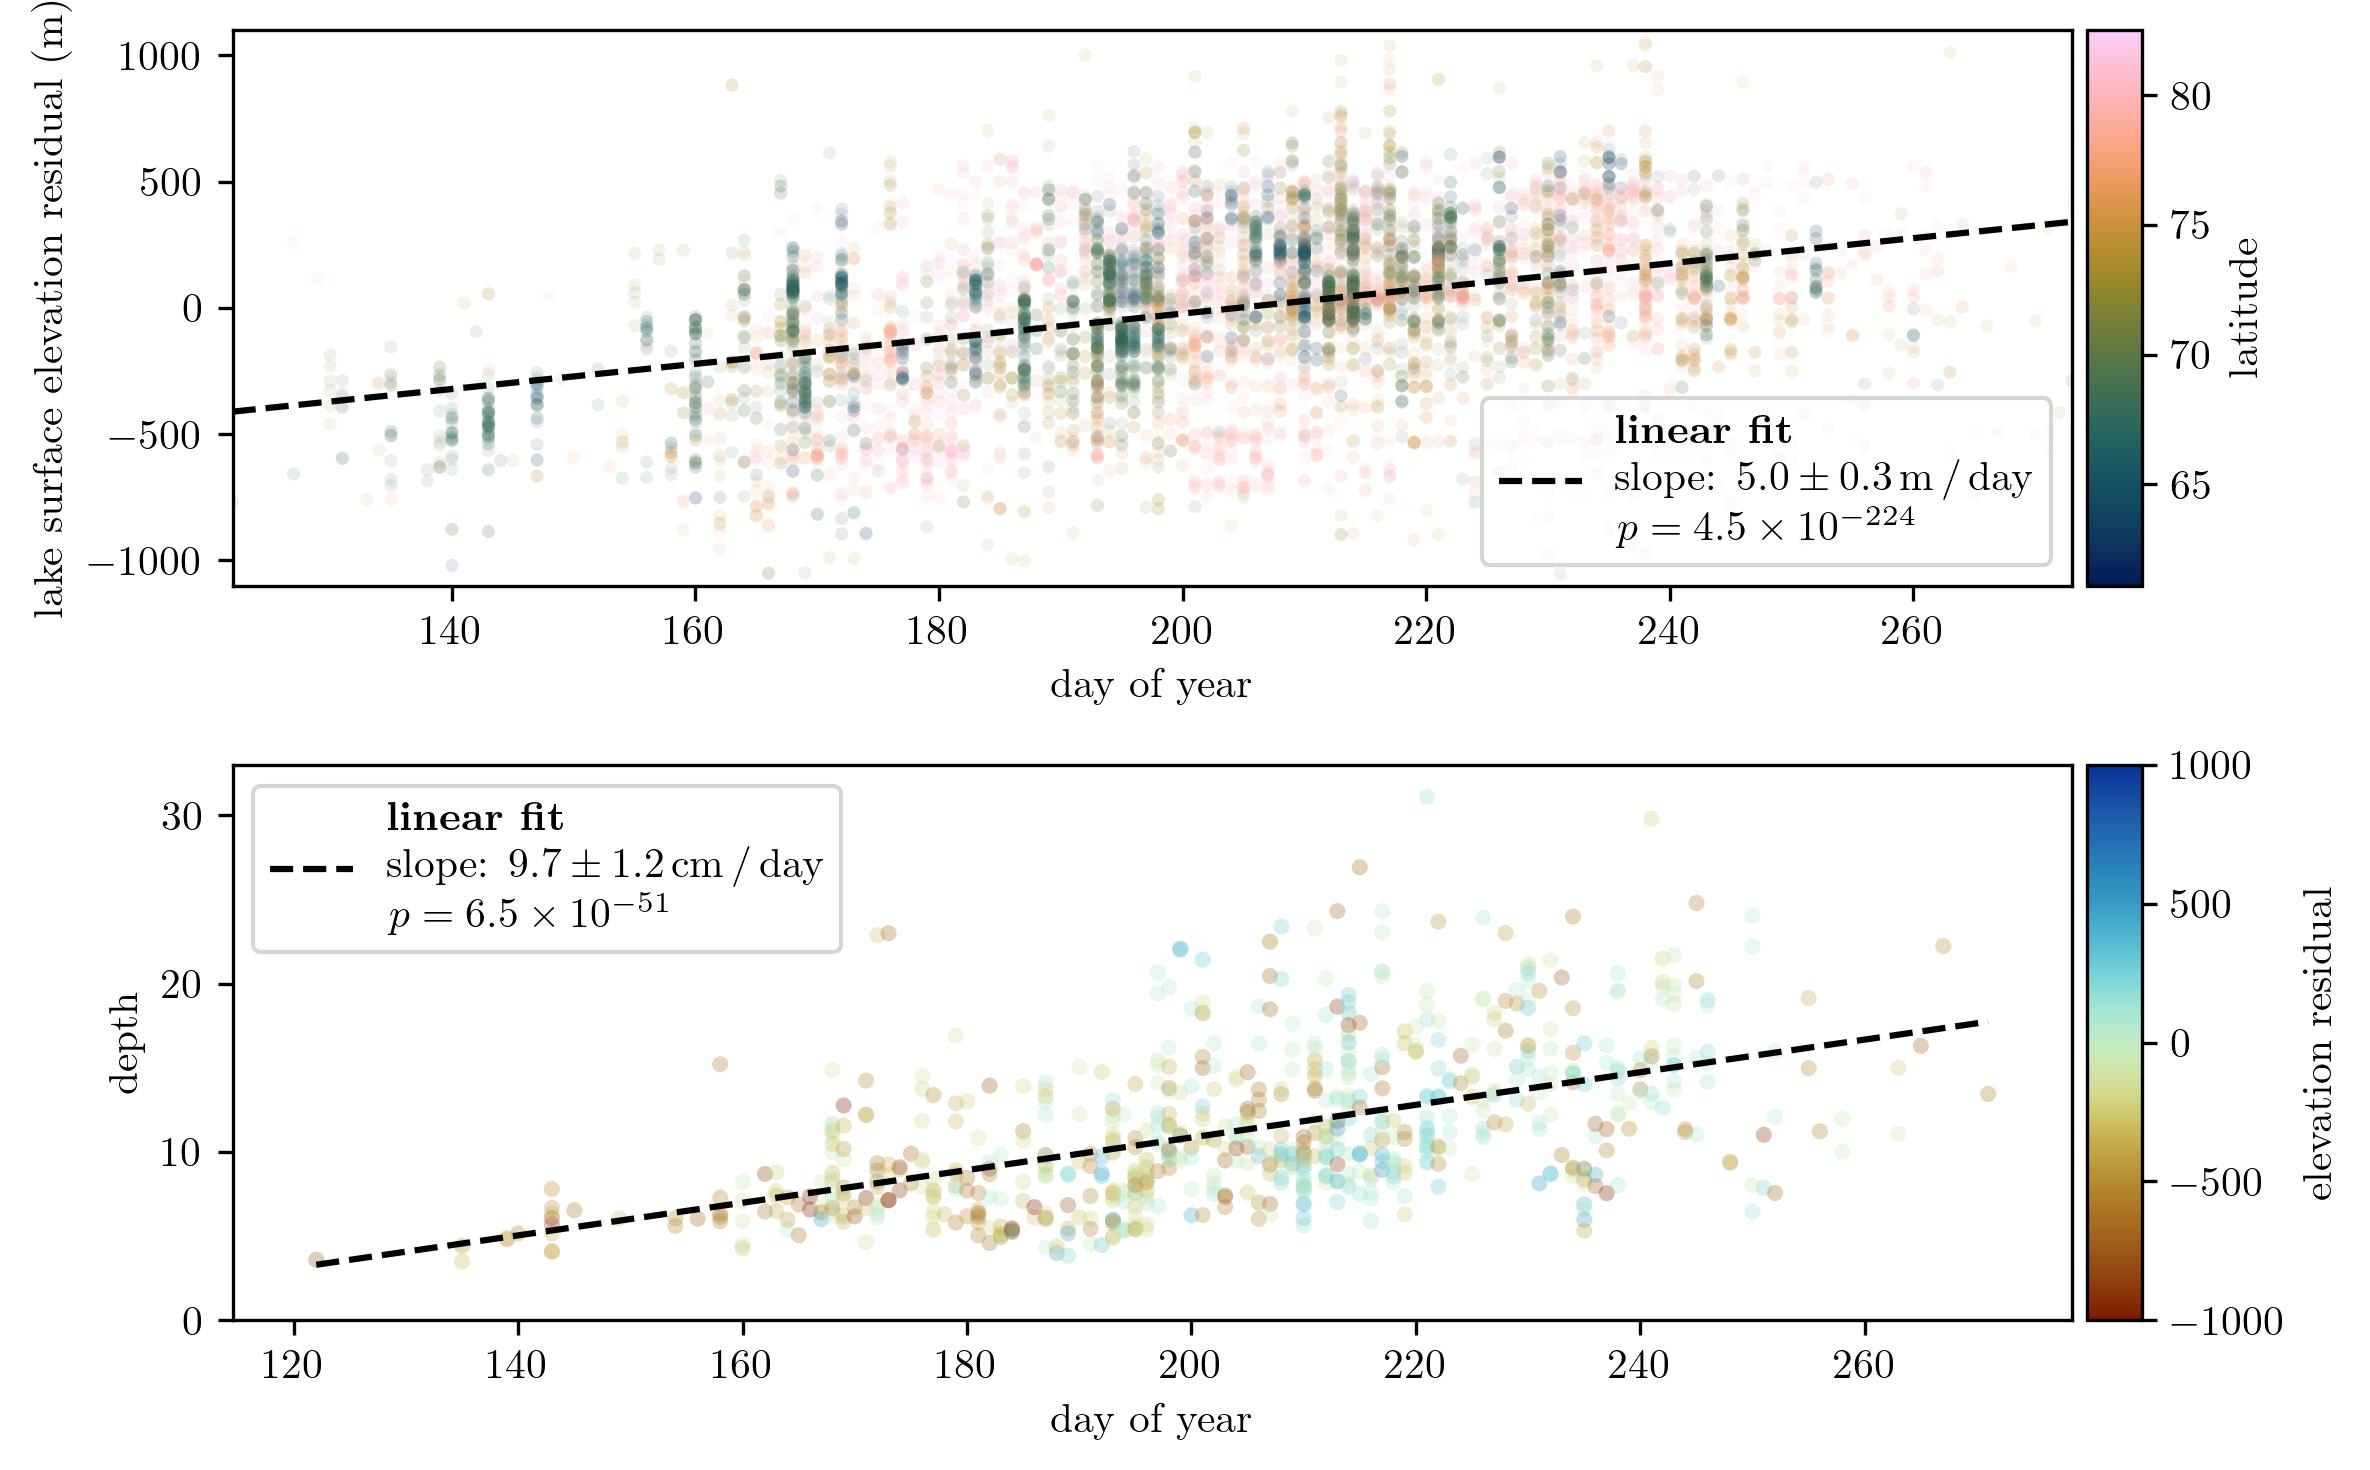

In [23]:
fig, axs = plt.subplots(figsize=[8,5], nrows=2)

doy_elev_res_model = sm.OLS(gdfnnz['elevation_residuals'], sm.add_constant(gdfnnz['doy'])).fit()
slope_doy_elev = doy_elev_res_model.params[1] # m / day
ci_doy_elev = np.abs(doy_elev_res_model.params[1] - doy_elev_res_model.conf_int().iloc[1,0]) # m / day
pval = ('%.2g' % doy_elev_res_model.pvalues[1]).replace('e', '\\times 10^{')
if '{' in pval:
    pval = pval + '}'
doy_elev_label = '\\textbf{linear fit}\nslope: $%.1f \\pm %.1f \\mathrm{\\,m\\,/\\,day}$\n$p=%s$' % (slope_doy_elev, ci_doy_elev, pval)
pred_resid = np.linspace(-1100, 1100)
pred_doy_elev = np.linspace(gdfnnz.doy.min(), gdfnnz.doy.max())
resid_predicted_doy = doy_elev_res_model.predict(sm.add_constant(pred_doy_elev))
# doy_predicted_resid = doy_elev_res_model.predict(sm.add_constant(pred_resid))
#gdfnnz['doy_rediduals'] = gdfnnz.doy - doy_elev_res_model.predict(sm.add_constant(gdfnnz.elevation_residuals))

quantile=0.9
df_sorted = gdfnnz.copy().sort_values(by='doy').reset_index(drop=True)
df_sorted['doy_group'] = get_ordered_groups(group_size=group_size, length=len(df_sorted))
dfs = []
for g in df_sorted.doy_group.unique():
    thisdf = df_sorted[df_sorted.doy_group == g]
    dfs.append(thisdf[thisdf.max_depth >= thisdf.max_depth.quantile(quantile)])
dfdeep_doy = pd.concat(dfs)
doy_depth_model = sm.OLS(dfdeep_doy['max_depth'], sm.add_constant(dfdeep_doy['doy'])).fit()
slope_doy_depth = doy_depth_model.params[1] * 100 # cm / day
ci_doy_depth = np.abs(doy_depth_model.params[1] - doy_depth_model.conf_int().iloc[1,0]) * 100 # cm / day
pval = ('%.2g' % doy_depth_model.pvalues[1]).replace('e', '\\times 10^{')
if '{' in pval:
    pval = pval + '}'
doy_depth_label = '\\textbf{linear fit}\nslope: $%.1f \\pm %.1f \\mathrm{\\,cm\\,/\\,day}$\n$p=%s$' % (slope_doy_depth, ci_doy_depth, pval)
pred_doy = np.linspace(dfdeep_doy.doy.min(), dfdeep_doy.doy.max())
depth_predicted_doy = doy_depth_model.predict(sm.add_constant(pred_doy))

## jk, this makes no sense, double correcting here
# doy_lat_model = sm.OLS(gdfnnz['doy_rediduals'], sm.add_constant(gdfnnz['lat'])).fit()
# slope_doy_lat = doy_lat_model.params[1] # days / lat
# ci_doy_lat = np.abs(doy_lat_model.params[1] - doy_lat_model.conf_int().iloc[1,0]) # days / lat
# pval = ('%.2g' % doy_lat_model.pvalues[1]).replace('e', '\\times 10^{')
# if '{' in pval:
#     pval = pval + '}'
# doy_lat_label = '\\textbf{linear fit}\nslope: $%.1f \\pm %.1f \\mathrm{\\,days\\,/\\,lat}$\n$p=%s$' % (slope_doy_lat, ci_doy_lat, pval)
# pred_lat = np.linspace(gdfnnz.lat.min(), gdfnnz.lat.max())
# doy_predicted_lat = doy_lat_model.predict(sm.add_constant(pred_lat))

ax = axs[0]
ax.scatter(gdfnnz.doy, gdfnnz.elevation_residuals, s=10, edgecolors='none', alpha=0.1, c=gdfnnz.lat, 
           vmin=gdfnnz.lat.min(), vmax=gdfnnz.lat.max(), cmap=cmc.batlow)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
smap = plt.cm.ScalarMappable(cmap=cmc.batlow, norm=plt.Normalize(vmin=gdfnnz.lat.min(), vmax=gdfnnz.lat.max()))
smap._A = []
cbar = plt.colorbar(smap, cax=cax, orientation='vertical')
cax.set_ylabel('latitude')

ax.axvline(0, color='red', ls=':')
ax.plot(pred_doy_elev, resid_predicted_doy, 'k--', label=doy_elev_label)
ax.set_ylabel('lake surface elevation residual (m)')
ax.set_xlabel('day of year')
ax.set_xlim((gdfnnz.doy.min(), gdfnnz.doy.max()))
ax.set_ylim((-1100, 1100))
ax.legend(loc='lower right')

ax= axs[1]
ax.scatter(dfdeep_doy.doy, dfdeep_doy.max_depth, s=15, edgecolors='none', alpha=0.3, c=dfdeep_doy.elevation_residuals, 
           vmin=-1000, vmax=1000, cmap=cmc.roma)
ax.plot(pred_doy, depth_predicted_doy, 'k--', label=doy_depth_label)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
smap = plt.cm.ScalarMappable(cmap=cmc.roma, norm=plt.Normalize(vmin=-1000, vmax=1000))
smap._A = []
cbar = plt.colorbar(smap, cax=cax, orientation='vertical')
cax.set_ylabel('elevation residual')

ax.set_ylim((0,33))
ax.set_xlabel('day of year')
ax.set_ylabel('depth')
ax.legend(loc='upper left')

# ax= axs[2]
# ax.scatter(gdfnnz.lat, gdfnnz.doy_rediduals, s=15, edgecolors='none', alpha=0.3, c=gdfnnz.elevation_residuals, 
#            vmin=-1100, vmax=1100, cmap=cmc.roma)
# ax.plot(pred_lat, doy_predicted_lat, 'k--', label=doy_lat_label)

# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='3%', pad=0.05)
# smap = plt.cm.ScalarMappable(cmap=cmc.roma, norm=plt.Normalize(vmin=-1100, vmax=1100))
# smap._A = []
# cbar = plt.colorbar(smap, cax=cax, orientation='vertical')
# cax.set_ylabel('elevation residual')

# ax.set_xlabel('latitude')
# ax.set_ylabel('day of year')
# ax.legend(loc='lower right')

fig.tight_layout()

figfn = 'figures/others/timing_vs_depth.jpg'
fig.savefig(figfn, dpi=300, bbox_inches='tight')
plt.close(fig)
display(Image(figfn))

In [80]:

doy_depth_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              max_depth   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     265.4
Date:                Wed, 21 Aug 2024   Prob (F-statistic):           6.50e-51
Time:                        20:09:16   Log-Likelihood:                -1985.6
No. Observations:                 710   AIC:                             3975.
Df Residuals:                     708   BIC:                             3984.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.5165      1.225     -6.952      0.000     -10.922      -6.111
doy            0.0969      0.006     16.291      0.000       0.085       0.109
==============================================================================
Omnibus:                      101.650   Durbin-Watson:                   1.403
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.961
Skew:                           0.934   Prob(JB):                     1.12e-35
Kurtosis:                       4.397   Cond. No.                     1.69e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
print('\nELEVATION REGRESSED ON LAT:\n', elevation_lat_model.summary())
# print('\nDEPTH REGRESSED ON ELEVATION:\n', depth_elev_model.summary())
print('\n______________________________________________________________________________________________________________________')
print('______________________________________________________________________________________________________________________')
print('\nDEPTH REGRESSED ON ELEVATION RESIDUALS:\n', depth_elev_res_model.summary())


ELEVATION REGRESSED ON LAT:
                             OLS Regression Results                            
Dep. Variable:      surface_elevation   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     3722.
Date:                Wed, 14 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:47:30   Log-Likelihood:                -49055.
No. Observations:                6785   AIC:                         9.811e+04
Df Residuals:                    6783   BIC:                         9.813e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4292.6069 

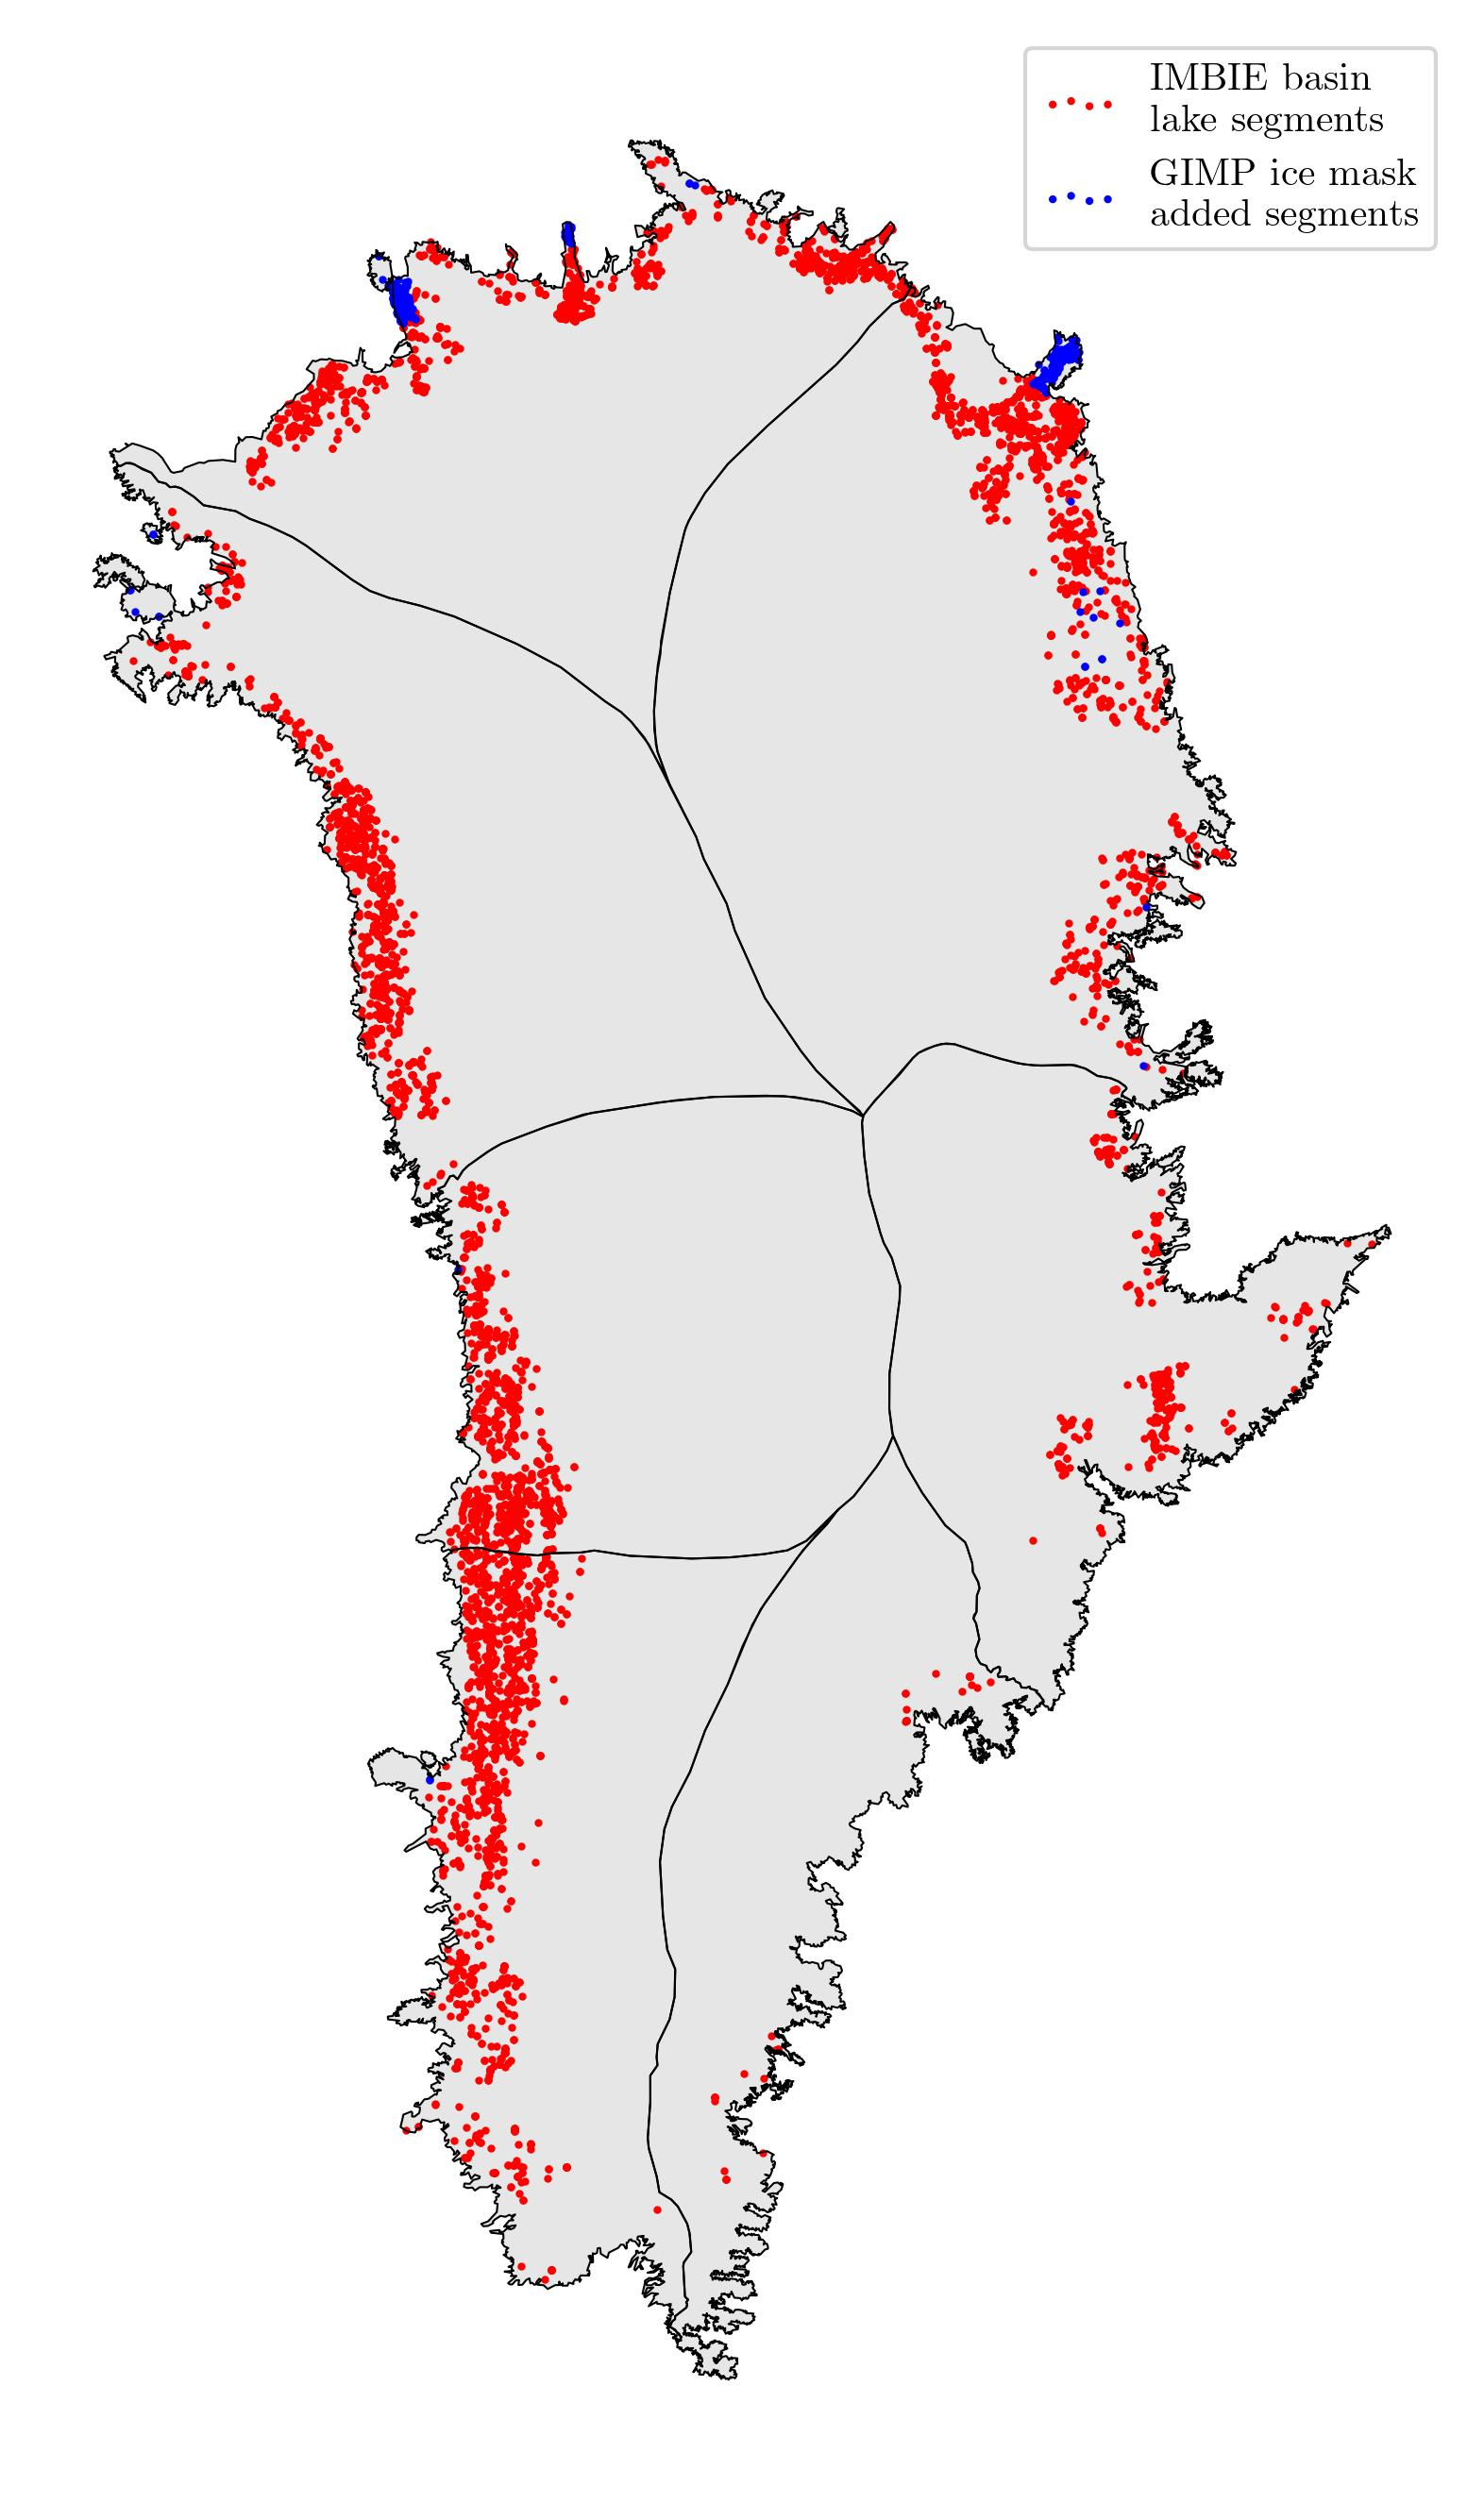

In [20]:
fig, ax = plt.subplots(figsize=[6,9], dpi=70)
ax.axis('off')
crsp = 'EPSG:3413'
gdf_basins.to_crs(crsp).plot(color=[0.9]*3, ax=ax)
gdf_basins.to_crs(crsp).plot(ax=ax, color='none', edgecolors='k', lw=0.5, zorder=10)
gdfg[gdfg.is_grounded].plot(ax=ax, markersize=1, color='r', alpha=1, label='IMBIE basin\nlake segments')
gdfg[~gdfg.is_grounded].plot(ax=ax, markersize=1, color='b', alpha=1, label='GIMP ice mask\nadded segments')

ax.legend(loc='upper right', scatterpoints=4)

fig.tight_layout()
figfn = 'figures/others/lakes_imbie_basins_vs_gimp_icemask.jpg'
fig.savefig(figfn, dpi=300, bbox_inches='tight')
plt.close(fig)
display(Image(figfn))

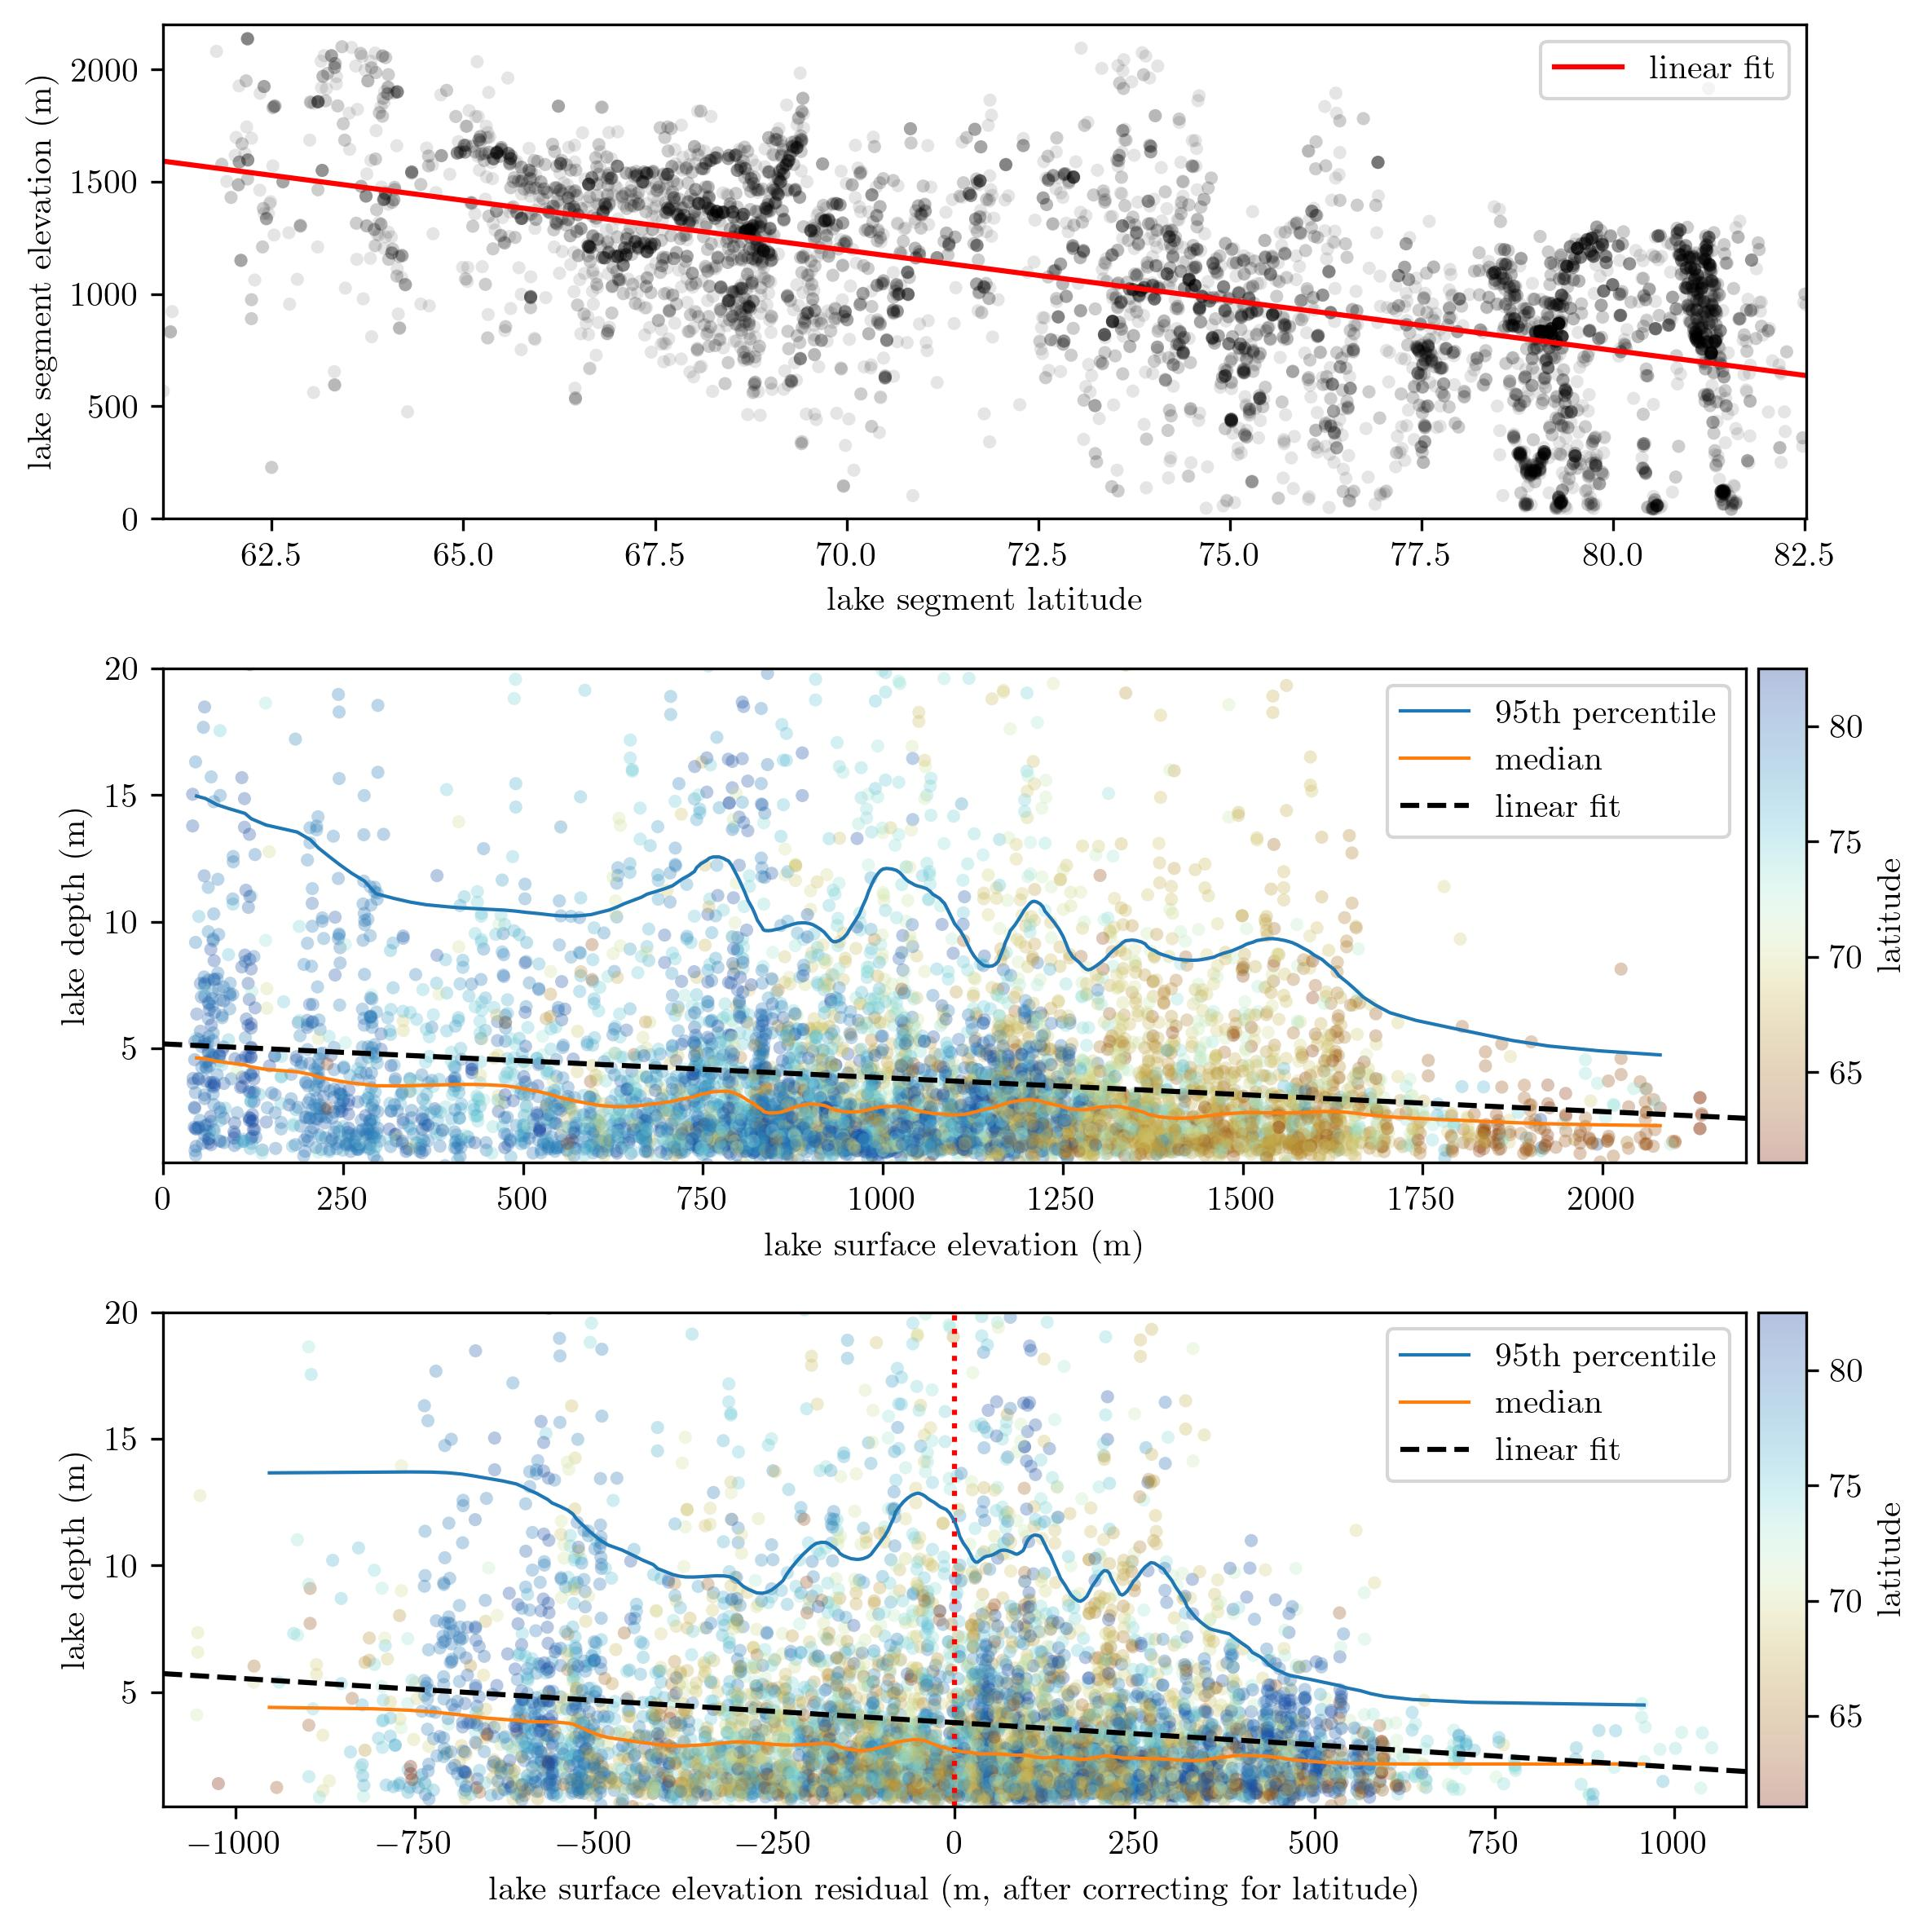


ELEVATION REGRESSED ON LAT:
                             OLS Regression Results                            
Dep. Variable:      surface_elevation   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     3826.
Date:                Wed, 14 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:47:51   Log-Likelihood:                -49218.
No. Observations:                6813   AIC:                         9.844e+04
Df Residuals:                    6811   BIC:                         9.845e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4311.4811 

In [28]:
plt.close('all')

group_size = 30
smoothing = 5
min_periods = 30
min_elev = 40

gdfnnz = gdfg[gdfg.max_depth > 0].copy()
gdfnnz = gdfnnz[gdfnnz.surface_elevation > 40]

elevation_lat_model = sm.OLS(gdfnnz['surface_elevation'], sm.add_constant(gdfnnz['lat'])).fit()
depth_elev_model = sm.OLS(gdfnnz['max_depth'], sm.add_constant(gdfnnz['surface_elevation'])).fit()
gdfnnz['elevation_residuals'] = elevation_lat_model.resid

# Now regress depth on the residuals
depth_model = sm.OLS(gdfnnz['max_depth'], sm.add_constant(gdfnnz['elevation_residuals'])).fit()

pred_lats = np.linspace(gdfnnz.lat.min(), gdfnnz.lat.max())
pred_elevs = np.linspace(0, 2200)
pred_resid = np.linspace(-1100, 1100)
elevs_predicted = elevation_lat_model.predict(sm.add_constant(pred_lats))
depths_predicted = depth_elev_model.predict(sm.add_constant(pred_elevs))
depths_predicted_resid = depth_model.predict(sm.add_constant(pred_resid))

fig, axs = plt.subplots(figsize=[8,8], nrows=3)

#################################################################################
ax = axs[0]
ax.scatter(gdfnnz.lat, gdfnnz.surface_elevation, s=15, color='k', alpha=0.1, edgecolors='none')
ax.plot(pred_lats, elevs_predicted, 'r-', label='linear fit')
ax.set_xlabel('lake segment latitude')
ax.set_ylabel('lake segment elevation (m)')
ax.set_xlim((gdfnnz.lat.min(), gdfnnz.lat.max()))
ax.set_ylim((0,2200))
ax.legend(loc='upper right')

#################################################################################
ax = axs[1]
scatt = ax.scatter(gdfnnz.surface_elevation, gdfnnz.max_depth, s=15, c=gdfnnz.lat, alpha=0.3, edgecolors='none', cmap=cmc.roma)
df_sorted = gdfnnz.copy().sort_values(by='surface_elevation').reset_index(drop=True)
df_sorted['group_elev'] = get_ordered_groups(group_size=group_size, length=len(df_sorted))
elev_stats = df_sorted.groupby('group_elev').agg({
    'surface_elevation': 'mean',
    'max_depth': ['mean', 'median', lambda x: np.quantile(x, 0.95)]
})
elev_stats.columns = ['elev', 'depth_mean', 'depth_median', 'depth_q95']

for val in ['depth_mean', 'depth_median', 'depth_q95']:
    elev_stats['%s_smooth'%val] = elev_stats[val].rolling(window=100, min_periods=min_periods, center=True, win_type='gaussian').mean(std=smoothing)

ax.plot(elev_stats.elev, elev_stats.depth_q95_smooth, lw=1, label='95th percentile')
ax.plot(elev_stats.elev, elev_stats.depth_median_smooth, lw=1, label='median')

ax.plot(pred_elevs, depths_predicted, 'k--', label='linear fit')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
fig.colorbar(scatt, cax=cax, orientation='vertical')
cax.set_ylabel('latitude')

ax.legend(loc='upper right')
ax.set_xlabel('lake surface elevation (m)')
ax.set_ylabel('lake depth (m)')
ax.set_xlim((0, 2200))
ax.set_ylim((0.5,20))

#################################################################################
# plot residuals
ax = axs[2]
scatt = ax.scatter(gdfnnz.elevation_residuals, gdfnnz.max_depth, s=15, c=gdfnnz.lat, alpha=0.3, edgecolors='none', cmap=cmc.roma)
df_sorted = gdfnnz.copy().sort_values(by='elevation_residuals').reset_index(drop=True)
df_sorted['group_elev_resid'] = get_ordered_groups(group_size=group_size, length=len(df_sorted))
res_stats = df_sorted.groupby('group_elev_resid').agg({
    'elevation_residuals': 'mean',
    'max_depth': ['mean', 'median', lambda x: np.quantile(x, 0.95)]
})
res_stats.columns = ['elev', 'depth_mean', 'depth_median', 'depth_q95']

for val in ['depth_mean', 'depth_median', 'depth_q95']:
    res_stats['%s_smooth'%val] = res_stats[val].rolling(window=100, min_periods=min_periods, center=True, win_type='gaussian').mean(std=smoothing)

ax.axvline(0, color='red', ls=':')
ax.plot(res_stats.elev, res_stats.depth_q95_smooth, lw=1, label='95th percentile')
ax.plot(res_stats.elev, res_stats.depth_median_smooth, lw=1, label='median')
ax.plot(pred_resid, depths_predicted_resid, 'k--', label='linear fit')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
fig.colorbar(scatt, cax=cax, orientation='vertical')
cax.set_ylabel('latitude')

ax.legend(loc='upper right')
ax.set_xlabel('lake surface elevation residual (m, after correcting for latitude)')
ax.set_ylabel('lake depth (m)')
ax.set_xlim((-1100, 1100))
ax.set_ylim((0.5,20))

fig.tight_layout()
figfn = 'figures/others/elev_vs_depth_full.jpg'
fig.savefig(figfn, dpi=300, bbox_inches='tight')
plt.close(fig)
display(Image(figfn))

print('\nELEVATION REGRESSED ON LAT:\n', elevation_lat_model.summary())
print('\nDEPTH REGRESSED ON ELEVATION:\n', depth_elev_model.summary())
print('\nDEPTH REGRESSED ON ELEVATION RESIDUALS:\n', depth_model.summary())

In [ ]:
# dfstats = pd.read_csv('data/GLD3_stats_combined.csv')
# dfstats['ice_sheet'] = dfstats.polygon.apply(lambda x: 'GrIS' if x.startswith('GRE_') else 'AIS')
# dfstats = dfstats[dfstats.ice_sheet == 'GrIS'].reset_index(drop=True)
# dfstats['basin'] = dfstats.polygon.apply(lambda x: x.split('_')[-1].replace('.geojson', ''))
# dfstats['gran_identify'] = dfstats.apply(lambda x: x.basin + x.granule.split('_')[2], axis=1)
# keys_stats = ['length_granule_xatc_meters', 'length_FLUID_detected_lakes_xatc_meters',
#               'number_photons_granule', 'number_photons_FLUID_detected_lakes',
#               'gran_identify']
# dfstats = dfstats[keys_stats]

# dfsize = pd.read_csv('data/GLD3-granule_sizes.csv')
# dfsize = dfsize[dfsize.ice_sheet=='GrIS']
# dfsize['basin'] = dfsize.polygon.apply(lambda x: x.split('_')[-1].replace('.geojson', ''))
# dfsize['gran_identify'] = dfsize.apply(lambda x: x.basin + x.granule_id.split('_')[2], axis=1)
# keys_size = ['ice_sheet', 'melt_season', 'basin', 'granule_id', 'polygon', 'size_mb', 'gran_identify']
# dfsize = dfsize[keys_size]

# dfreq = pd.read_csv('data/request_info_GLD3-GRE-0.csv')
# dfreq['gran_identify'] = dfreq.apply(lambda x: x.basin + x.granule_id.split('_')[2], axis=1)
# dfreq = dfreq.rename(columns={'size_mb': 'size_mb_subsetted'})
# keys_req = ['size_mb_subsetted', 'mem_request', 'dsk_request', 'start_date', 'end_date', 'orderID', 'status',
#             'ngranules_request', 'nprocessed', 'n_links', 'available_until', 'granule_url', 'status_url', 
#             'gran_list_url', 'order_overview_url', 'order_summary_url', 'gran_identify']
# dfreq = dfreq[keys_req]

# dfgranules = dfsize.merge(dfstats, on='gran_identify', how='left').merge(dfreq, on='gran_identify', how='left')
# dfgranules.loc[dfgranules.length_granule_xatc_meters.isna(), 'length_granule_xatc_meters'] = 0.0 
# dfgranules.loc[dfgranules.length_granule_xatc_meters == 0, ['length_FLUID_detected_lakes_xatc_meters', 'number_photons_FLUID_detected_lakes']] = 0
# dfgranules = dfgranules.set_index('gran_identify')
# # dfgranules.to_csv('data/FLUID-SuRRF_GrIS2019-23_granulestats.csv')

In [115]:
# grounded = False

# dfgranules = pd.read_csv('data/FLUID-SuRRF_GrIS2019-23_granulestats.csv')

# # df = pd.read_csv('data/FLUID-SuRRF_GrIS2019-23_lakestats.csv')
# # df['geometry'] = df['geometry'].apply(wkt.loads)
# # gdf = gpd.GeoDataFrame(df, crs='EPSG:3413')
# # gdfg = gdf[gdf.label=='good_lake'].copy()
# # gdfg['lid'] = gdfg.apply(lambda x: '_'.join(x.lake_id.split('_')[4:]), axis=1)

# dfg = pd.read_csv('data/FLUID-SuRRF_GrIS2019-23_lakestats_goodlakes.csv')
# dfg['geometry'] = dfg['geometry'].apply(wkt.loads)
# gdfg = gpd.GeoDataFrame(dfg, crs=gdf_basins.crs)
# if grounded:
#     gdfg = gdfg[gdfg.is_grounded]

# cols_rename = {'length_granule_xatc_meters': 'xatc_total_m',
#                'number_photons_granule': 'nphot_total',
#                'size_mb': 'data_mb'}
# col_grp = 'basin'
# df_grps = dfgranules.rename(columns={col_grp: 'group'}).groupby('group')[list(cols_rename)].sum().rename(columns=cols_rename)
# df_grps['n_granules'] = dfgranules.groupby(col_grp)['granule_id'].count()

# dftot = pd.DataFrame(df_grps.sum()).transpose()
# dftot['group'] = 'total'
# dftot = dftot.set_index('group', drop=True)

# col_grp = 'melt_season'
# df_yrs = dfgranules.rename(columns={col_grp: 'group'}).groupby('group')[list(cols_rename)].sum().rename(columns=cols_rename)
# df_yrs['n_granules'] = dfgranules.groupby(col_grp)['granule_id'].count()

# df_grps = pd.concat((dftot, df_grps, df_yrs))

# colname = 'xatc_water'
# df_grps[colname] = np.nan
# df_grps.loc['total', colname] = gdfg.length_water.sum()
# basin_xatcwater = gdfg.groupby('basin').length_water.sum()
# df_grps.loc[basin_xatcwater.index, colname] = basin_xatcwater
# yr_xatcwater = gdfg.groupby('melt_season').length_water.sum()
# df_grps.loc[yr_xatcwater.index, colname] = yr_xatcwater
# df_grps['pct_xatc_water'] = df_grps.xatc_water / df_grps.xatc_total_m * 100

# quant = 0.9
# colname = 'depth_%ipctl' % int(np.round(quant*100))
# df_grps[colname] = np.nan
# gdfnnz = gdfg[gdfg.max_depth>0]
# df_grps.loc['total', colname] = gdfnnz.max_depth[gdfnnz.max_depth > gdfnnz.max_depth.quantile(quant)].mean()
# basin_depth = gdfnnz.groupby('basin').max_depth.apply(lambda x: x[x>=x.quantile(quant)].mean())
# df_grps.loc[basin_depth.index, colname] = basin_depth
# yr_depth = gdfnnz.groupby('melt_season').max_depth.apply(lambda x: x[x>=x.quantile(quant)].mean())
# df_grps.loc[yr_depth.index, colname] = yr_depth

# colname = 'elev_mean'
# df_grps[colname] = np.nan
# df_grps.loc['total', colname] = gdfg.surface_elevation.mean()
# basin_elev = gdfg.groupby('basin').surface_elevation.mean()
# df_grps.loc[basin_elev.index, colname] = basin_elev
# yr_elev = gdfg.groupby('melt_season').surface_elevation.mean()
# df_grps.loc[yr_elev.index, colname] = yr_elev

# colname = 'log_qual_mean'
# gdfg['log_qual'] = np.log1p(gdfg.depth_quality_sort)
# df_grps[colname] = np.nan
# df_grps.loc['total', colname] = np.log1p(gdfg.depth_quality_sort).mean()
# basin_qual = gdfg.groupby('basin').depth_quality_sort.apply(lambda x: np.log1p(x).mean())
# df_grps.loc[basin_qual.index, colname] = basin_qual
# yr_qual = gdfg.groupby('melt_season').depth_quality_sort.apply(lambda x: np.log1p(x).mean())
# df_grps.loc[yr_qual.index, colname] = yr_qual

# dtformat = '%Y-%m-%dT%H:%M:%SZ'
# gdfg['datetime'] = gdfg.date_time.apply(lambda x: datetime.strptime(x, dtformat))
# def is_leap_year(year):
#     return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)
# def get_doy(x):
#     doy = x.timetuple().tm_yday
#     if is_leap_year(x.year):
#         if doy == 60: # feb 29
#             doy = np.nan
#         if doy > 60:
#             doy -= 1
#     return doy
# gdfg['doy'] = gdfg.datetime.apply(get_doy)

# colname = 'doy_mean'
# df_grps[colname] = np.nan
# df_grps.loc['total', colname] = gdfg.doy.mean()
# basin_doy = gdfg.groupby('basin').doy.mean()
# df_grps.loc[basin_doy.index, colname] = basin_doy
# yr_doy = gdfg.groupby('melt_season').doy.mean()
# df_grps.loc[yr_doy.index, colname] = yr_doy

# fn_out_groupstats = 'data/FLUID-SuRRF_GrIS2019-23_groupstats.csv'
# if grounded:
#     fn_out_groupstats = fn_out_groupstats.replace('.csv','_grounded.csv')

# df_grps.to_csv(fn_out_groupstats)
# display(df_grps)

/var/folders/8_/l1xn6w9502gfjh2zxy01thdc0000gr/T/ipykernel_50497/177312825.py:40: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_grps.loc[yr_xatcwater.index, colname] = yr_xatcwater
/var/folders/8_/l1xn6w9502gfjh2zxy01thdc0000gr/T/ipykernel_50497/177312825.py:51: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_grps.loc[yr_depth.index, colname] = yr_depth
/var/folders/8_/l1xn6w9502gfjh2zxy01thdc0000gr/T/ipykernel_50497/177312825.py:59: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df_grps.loc[yr_elev.index, colname] = yr_elev
/var/folders/8_/l1xn6w9502gfjh2zxy01thdc0000gr/T/ipykernel_50497/177312825.py:68: FutureWarning: In a future version, the Index constructor will not

xatc_total_m   nphot_total       data_mb  n_granules  xatc_water  \
group                                                                     
total  1.224240e+10  1.709707e+11  3.145494e+07     11304.0   4209735.0   
CE     9.845941e+08  2.528115e+10  3.115251e+06       902.0    163665.0   
CW     8.237589e+08  8.372163e+09  1.551389e+06       532.0    729780.0   
NE     2.769508e+09  3.961249e+10  6.408843e+06      2245.0   1038800.0   
NO     3.306321e+09  3.881244e+10  1.259195e+07      4930.0    759570.0   
NW     2.128533e+09  3.101740e+10  4.572173e+06      1486.0    700150.0   
SE     7.141371e+08  1.493961e+10  1.579615e+06       646.0     12240.0   
SW     1.515548e+09  1.293542e+10  1.635720e+06       563.0    805530.0   
2019   2.259661e+09  3.103321e+10  5.198778e+06      2083.0   1129105.0   
2020   2.522613e+09  3.208271e+10  6.029418e+06      2329.0    759050.0   
2021   2.457307e+09  3.903215e+10  7.222613e+06      2283.0    835860.0   
2022   2.506308e+09  3.458637e+10  6.593101e+06      2305.0    701575.0   
2023   2.496511e+09  3.423623e+10  6.411036e+06      2304.0    784145.0   

       pct_xatc_water  depth_90pctl    elev_mean  log_qual_mean    doy_mean  
group                                                                        
total        0.034387     12.149372   981.138823       1.175579  203.924408  
CE           0.016623     11.965937  1349.694652       1.061594  202.008130  
CW           0.088591     12.596210  1164.333057       1.363038  198.766221  
NE           0.037508     11.269271   782.002881       1.115739  208.409910  
NO           0.022973     10.898492   678.171570       1.120981  204.036120  
NW           0.032894     15.940344   878.679362       1.257276  210.984362  
SE           0.001714      9.598809  1095.409968       0.988867  204.052632  
SW           0.053151      9.278767  1392.942646       1.135231  196.632050  
2019         0.049968     13.811320  1066.798382       1.229964  199.159468  
2020         0.030090     12.311791   944.072730       1.185656  199.574737  
2021         0.034015     10.875665   991.185845       1.205091  207.698953  
2022         0.027992     11.707670   889.688314       1.085578  209.055982  
2023         0.031410     11.297028   982.653562       1.145313  205.684685

In [ ]:
# gdfg = gdf[gdf.label=='good_lake'].copy()
# gdfg['lid'] = gdfg.apply(lambda x: '_'.join(x.lake_id.split('_')[4:]), axis=1)

# gdf_imbie = gpd.read_file('data/shapefiles/Greenland_Basins_PS_v1.4.2.shp').to_crs(gdf_basins.crs)
# gdf_imbie = gdf_imbie[~gdf_imbie.NAME.apply(lambda x: x.startswith('ICE_CAPS_'))]
# grounded_poly = gdf_imbie.dissolve().geometry.iloc[0]
# gdfg['is_grounded'] = gdfg.geometry.within(grounded_poly)

# dtformat = '%Y-%m-%dT%H:%M:%SZ'
# gdfg['datetime'] = gdfg.date_time.apply(lambda x: datetime.strptime(x, dtformat))
# def is_leap_year(year):
#     return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)
# def get_doy(x):
#     doy = x.timetuple().tm_yday
#     if is_leap_year(x.year):
#         if doy == 60: # feb 29
#             doy = np.nan
#         if doy > 60:
#             doy -= 1
#     return doy
# gdfg['doy'] = gdfg.datetime.apply(get_doy)

In [ ]:
# import fiona
# fiona.drvsupport.supported_drivers['libkml'] = 'rw' 
# fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'

# searchdir = 'data/shapefiles/zzz_kmls/cycle12kmls/IS2_RGTs_cycle12_date_time/'
# searchfor = '.kml'
# filelist = [searchdir+f for f in os.listdir(searchdir) \
#             if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f)]
# filelist.sort()
# listlength = len(filelist)
# print('number *%s:' % searchfor, listlength)

# gdfs_kml = []
# for fn_kml in filelist:
#     gdf_kml = gpd.read_file(fn_kml)[['Name', 'geometry']]
#     print('%8s / %4i' % (gdf_kml.Name.iloc[0], listlength), end='\r')
#     gdfs_kml.append(gdf_kml)
# gdf_kmls = pd.concat(gdfs_kml)
# print('\n--> done.')

# gdf_kmls['rgt'] = gdf_kmls.Name.apply(lambda x: int(x.split(' ')[-1]))
# gdf_kmls = gdf_kmls.set_index('rgt', drop=True)
# bounds_gre = gdf_basins.buffer(3e5).total_bounds
# bbox = Polygon([(bounds_gre[i], bounds_gre[j]) for i, j in [(0,1), (2,1), (2,3), (0,3), (0,1)]])
# rgt_arctic = gdf_kmls.to_crs(gdf_basins.crs)
# rgt_arctic.to_file('data/shapefiles/zzz_kmls/rgts_arctic.shp')
# rgt_gre = rgt_arctic.clip(bbox)
# rgt_gre.to_file('data/shapefiles/rgts_gris.shp')
# rgt_gre.clip(gdf_basins).to_file('data/shapefiles/rgts_gris_clipped.shp')